# Библиотеки

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from scipy.interpolate import interp1d

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer

from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor

from scipy.stats import norm

import math

In [ ]:
import sys
import os
import glob

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.3 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [ ]:
import hdbscan

In [ ]:
!pip install plotly

# Общие функции

## Обработки

In [ ]:
# @title Изменение типов колонок
def preprocessing(data):
    """
    Функция для предварительной обработки данных окулограмм.

    Args:
    data (pandas.DataFrame): Данные окулограмм, требующие предварительной обработки.

    Returns:
    pandas.DataFrame: Обработанные данные окулограмм.
    """
    data = data.replace({',': '.'}, regex=True)
    data[['LX', 'LY', 'RX', 'RY']] = data[['LX', 'LY', 'RX', 'RY']].apply(pd.to_numeric, errors='coerce')
    return data

In [ ]:
# @title Интерполяция
def interpolate(data):

    new_time_range = np.arange(0, len(data) * 20 - 19, 1)

    # Создаем функции интерполяции для каждого признака
    f_LX = interp1d(data['T'], data['LX'])
    f_LY = interp1d(data['T'], data['LY'])
    f_RX = interp1d(data['T'], data['RX'])
    f_RY = interp1d(data['T'], data['RY'])
    f_X_mean = interp1d(data['T'], data['X_mean'])
    f_Y_mean = interp1d(data['T'], data['Y_mean'])

    # Выполняем интерполяцию
    new_LX = f_LX(new_time_range)
    new_LY = f_LY(new_time_range)
    new_RX = f_RX(new_time_range)
    new_RY = f_RY(new_time_range)
    new_X_mean = f_X_mean(new_time_range)
    new_Y_mean = f_Y_mean(new_time_range)

    new_df = pd.DataFrame({'T': new_time_range,
                         'LX': new_LX,
                         'LY': new_LY,
                         'RX': new_RX,
                         'RY': new_RY,
                         'X_mean': new_X_mean,
                         'Y_mean': new_Y_mean})

    new_df['id_patient'] = data['id_patient'].iloc[0]
    new_df['gender'] = data['gender'].iloc[0]
    new_df['disabled'] = data['disabled'].iloc[0]
    new_df['lenght'] = data['lenght'].iloc[0]

    # Создаем новый фрейм данных с интерполированными значениями
    return new_df

In [ ]:
# @title Функция объедененения окуллограм пациентов в общий набор данных
def get_data_all(length=None):
    """
    Args:
    length (int): Длина для обрезки данных.

    Функция для объединения данных из нескольких файлов окулограмм в общий набор данных.

    Returns:
    pandas.DataFrame: Общий набор данных, содержащий информацию из всех файлов окулограмм.
    """
    df_all = pd.DataFrame()
    root_dir = '/content/drive/MyDrive/lectures/diplom/RecordingData/Recording Data/'
    data_files = glob.glob(os.path.join(root_dir, '**', '*.txt'), recursive=True)
    dfs = []

    for data_file in data_files:
        folder_id = os.path.basename(os.path.dirname(data_file))
        file_df = pd.read_csv(data_file, header=0, delimiter='\t')

        # Ограничение длины датасета
        if length is not None:
            file_df = file_df[:length]

        # Обработка колонок
        file_df = preprocessing(file_df)
        # Центрирование взгляда
        file_df['X_mean'] = file_df[['LX', 'RX']].mean(axis=1)
        file_df['Y_mean'] = file_df[['LY', 'RY']].mean(axis=1)

        # Добавление идентификатора пациента
        file_df['id_patient'] = folder_id
        file_df = patient_id_decoding(file_df.copy())
        file_df['lenght'] = len(file_df)

        dfs.append(file_df)

    df_all = pd.concat(dfs, ignore_index=True)

    return  df_all

## Визуализации

In [ ]:
# @title Визуализация Глазных эвентов
def plot_events(data, methods):
    colors = {
        'fixation': 'lightgray',
        'saccade': 'lightgreen',
        'peripheral': 'b',
        'foveal': 'm',
        'parafoveal': 'c',
        'other': 'orange',
        'distortions': 'black',
        'fixation_progressive': 'lightgray',
        'fixation_regressive': 'b',
        'saccade_progressive': 'lightgreen',
        'saccade_regressive': 'maroon',
        'transition': 'blue',
        'event': 'red',
    }

    alphas = {
        'fixation': 0.05,
        'saccade': 0.5,
        'peripheral': 1,
        'foveal': 0.1,
        'parafoveal': 0.1,
        'other': 1,
        'distortions': 1,
        'fixation_progressive': 0.5,
        'fixation_regressive': 0.1,
        'saccade_progressive': 0.5,
        'saccade_regressive': 0.1,
        'transition': 0.5,
        'event': 0.5
    }

    fig, axes = plt.subplots(len(methods), 1, figsize=(24, 5 * len(methods)))

    for i, method in enumerate(methods):
        ax = axes[i] if len(methods) > 1 else axes
        ax.plot(data['T'], data['X_mean'], label='X_mean', alpha=1)
        ax.plot(data['T'], data['Y_mean'], label='Y_mean', alpha=1)

        ax.set_xlabel('Time')
        ax.set_ylabel(f'{method}_events')
        ax.set_title(f'{method}_events by Time')

        for j, row in data.iterrows():
            time = row['T']
            event_type = row[method]
            color = colors.get(event_type, 'none')
            alpha = alphas.get(event_type, 0.5)

            ax.axvspan(time, time, color=color, alpha=alpha)

        ax.legend(loc="upper right")

    plt.show()

In [ ]:
# @title Визуализация EOG по осям - plot_eog
def plot_eog(data):
    """
    Функция для построения графиков окулограмм.

    Args:
    data (pandas.DataFrame): Данные окулограмм для построения графиков.

    Returns:
    None
    """
    plt.figure(figsize=(14, 6))

    plt.subplot(4, 1, 1)
    plt.plot(data['T'], data['LX'], label='Горизонтальное EOG (левый)')
    plt.title('Горизонтальное EOG (левый)')
    plt.xlabel('Время (сек)')
    plt.ylabel('Амплитуда')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(data['T'], data['LY'], label='Вертикальное EOG (левый)', color='green')
    plt.title('Вертикальное EOG (левый)')
    plt.xlabel('Время (сек)')
    plt.ylabel('Амплитуда')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(data['T'], data['RX'], label='Горизонтальное EOG (правый)', color='yellow')
    plt.title('Горизонтальное EOG (правый)')
    plt.xlabel('Время (сек)')
    plt.ylabel('Амплитуда')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(data['T'], data['RY'], label='Вертикальное EOG (правый)', color='orange')
    plt.title('Вертикальное EOG (правый)')
    plt.xlabel('Время (сек)')
    plt.ylabel('Амплитуда')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# @title EOG Левого и Правого глаза - plot_eog_lr
def plot_eog_lr(data):
    """
    Функция для построения графиков горизонтального и вертикального движения глаз для обоих глаз.

    Args:
    data (pandas.DataFrame): Данные окулограмм для построения графиков.

    Returns:
    None
    """
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(data['LX'], data['LY'], label='Левый глаз')
    plt.title('Левый глаз EOG')
    plt.xlabel('LX')
    plt.ylabel('LY')
    plt.legend()
    plt.xlim([min(data['LX'].min(), data['RX'].min()), max(data['LX'].max(), data['RX'].max())])
    plt.ylim([min(data['LY'].min(), data['RY'].min()), max(data['LY'].max(), data['RY'].max())])

    plt.subplot(2, 2, 2)
    plt.plot(data['RX'], data['RY'], label='Правый глаз', color='orange')
    plt.title('Правый глаз EOG')
    plt.xlabel('RX')
    plt.ylabel('RY')
    plt.legend()
    plt.xlim([min(data['LX'].min(), data['RX'].min()), max(data['LX'].max(), data['RX'].max())])
    plt.ylim([min(data['LY'].min(), data['RY'].min()), max(data['LY'].max(), data['RY'].max())])

    plt.tight_layout()
    plt.show()

In [ ]:
# @title Общее с обоих глаз - plot_eog_lr_union
def plot_eog_lr_union(data):
    """
    Функция для построения графиков горизонтального и вертикального движения глаз для обоих глаз на одном графике.

    Args:
    data (pandas.DataFrame): Данные окулограмм для построения графиков.

    Returns:
    None
    """
    plt.figure(figsize=(9, 8))

    plt.subplot(2, 2, 1)
    plt.plot(data['LX'], data['LY'], label='Левый глаз')
    plt.title('Левый глаз EOG')
    plt.xlabel('LX')
    plt.ylabel('LY')
    plt.legend()

    plt.subplot(2, 2, 1)
    plt.plot(data['RX'], data['RY'], label='Правый глаз', color='orange')
    plt.title('Оба глаза EOG')
    plt.xlabel('RX')
    plt.ylabel('RY')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# @title Визуализация статистик обоих глаз - plot_stats_xy
def plot_stats_xy(change_data, initial_data, slice_len=0):
    """
    Функция для построения графиков статистических значений X и Y для обоих глаз.

    Args:
    change_data (pandas.DataFrame): Измененные данные окулограмм.
    initial_data (pandas.DataFrame): Исходные данные окулограмм.
    slice_len (int, optional): Длина среза данных для отображения. По умолчанию 0.

    Returns:
    None
    """
    def plot_stats(stats, label_prefix):
        plt.plot(stats.loc['min'][0], stats.loc['min'][1], 'ro', label=label_prefix + ' Min')
        plt.plot(stats.loc['25%'][0], stats.loc['25%'][1], 'bo', label=label_prefix + ' 25%')
        plt.plot(stats.loc['50%'][0], stats.loc['50%'][1], 'go', label=label_prefix + ' Median')
        plt.plot(stats.loc['75%'][0], stats.loc['75%'][1], 'yo', label=label_prefix + ' 75%')
        plt.plot(stats.loc['max'][0], stats.loc['max'][1], 'ro', label=label_prefix + ' Max')

        plt.plot([stats.loc['min'][0], stats.loc['min'][0], 0],
                 [0, stats.loc['min'][1], stats.loc['min'][1]], linestyle='--', color='grey')

        plt.plot([stats.loc['25%'][0], stats.loc['25%'][0], 0],
                 [0, stats.loc['25%'][1], stats.loc['25%'][1]], linestyle='--', color='grey')

        plt.plot([0, stats.loc['50%'][0], stats.loc['50%'][0]],
                 [stats.loc['50%'][1], stats.loc['50%'][1], 0], linestyle='--', color='grey')

        plt.plot([stats.loc['75%'][0], stats.loc['75%'][0], 0],
                 [0, stats.loc['75%'][1], stats.loc['75%'][1]], linestyle='--', color='grey')

        plt.plot([0, stats.loc['max'][0], stats.loc['max'][0]],
                 [stats.loc['max'][1], stats.loc['max'][1], 0], linestyle='--', color='grey')

    plt.figure(figsize=(14, 6))
    change_data_len = slice_len if slice_len else len(change_data)

    plt.plot(change_data['LX'][:change_data_len], change_data['LY'][:change_data_len], label='Левый глаз', alpha=0.3)
    plt.plot(change_data['RX'][:change_data_len], change_data['RY'][:change_data_len], label='Правый глаз', alpha=0.3)

    stats = initial_data[['LX', 'LY']].describe().loc['min': 'max']
    plot_stats(stats, 'L')

    stats = initial_data[['RX', 'RY']].describe().loc['min': 'max']
    plot_stats(stats, 'R')

    plt.xlabel('Statistical Values')
    plt.ylabel('Y')
    plt.title('Min, 25%, 50%, 75%, Max of X and Y')
    plt.legend()

    plt.axhline(0, color='black', linewidth=1.5)
    plt.axvline(0, color='black', linewidth=1.5)

    plt.minorticks_on()
    plt.xlabel(r'$x$', fontsize=16)

    plt.grid(which='major')
    plt.grid(which='minor', linestyle=':')
    plt.tight_layout()

    plt.show()

In [ ]:
# @title Визуализация 3d графика во времени - plotly_3d
def plotly_3d(data, axes=['T', 'LX', 'LY'], color='T'):
    """
    Функция для построения интерактивного трехмерного графика.

    Args:
    data (pandas.DataFrame): Данные для построения графика.
    axes (list, optional): Список осей. По умолчанию ['T', 'LX', 'LY'].
    color (str, optional): Параметр цвета. По умолчанию 'T'.

    Returns:
    None
    """
    axis_x, axis_y, axis_z = axes
    color_map = {'event': 'red', 'other': 'orange',}

    fig = go.Figure(data=[go.Scatter3d(
        x=data[axis_x],
        y=data[axis_y],
        z=data[axis_z],
        mode='markers',
        marker=dict(
            size=3,
            color=[color_map[val] for val in data[color]] if color != 'T' else data[color],
            colorscale='Viridis',
            opacity=0.8
        ),
        text=[f'X: {lx}, Y: {ly}, T: {t}' for lx, ly, t in zip(data[axes[1]], data[axes[2]], data[axes[0]])],
        hoverinfo='text'
    )])

    # Создаем данные для плоскости
    xx, yy = np.meshgrid(np.linspace(data[axes[1]].min(), data[axes[1]].max(), 10),
                         np.linspace(data[axes[2]].min(), data[axes[2]].max(), 10))
    zz = np.zeros_like(xx)

    offset = -0.01

    # Добавляем плоскость
    fig.add_trace(go.Surface(x=zz + offset, y=xx, z=yy, opacity=0.05, hoverinfo='none'))

    fig.update_layout(scene=dict(
        xaxis_title=axes[1],
        yaxis_title=axes[0],
        zaxis_title=axes[2],
        xaxis_visible=False,  # убираем ось
        yaxis_visible=False,
        zaxis_visible=False,
        # xaxis=dict(range=[offset, 1],autorange=False)  # Отключение автоматического масштабирования для оси z)
    ),
        title='3D Visualization',
        width=1200,
        height=800)

    fig.show()

In [ ]:
# @title Метод для визуализации результатов кластеризации
def plot_clusters(data, method, axis):
    """
    Метод для визуализации результатов кластеризации методом DBSCAN.

    Параметры:
    - data: DataFrame, содержащий данные окулографии.
    - labels: массив меток кластеров для каждой точки данных.
    """
    cmap = {'event': 'red', 'other': 'orange'}

    # Отображение кластеров
    plt.figure(figsize=(12, 6))
    plt.scatter(data[axis[0]], data[axis[1]], c=[cmap[label] for label in data[method]], cmap='viridis')
    plt.title(f'{method} Clustering')
    plt.xlabel(axis[0])
    plt.ylabel(axis[1])
    plt.colorbar(label='Cluster Label')
    plt.show()

In [ ]:
# @title Визуализация типов зрения - plot_field_view
def plot_field_view(data):
    """
    Рисует график поля зрения окулографических данных.

    Параметры:
    - data (pd.DataFrame): Окулографические данные с колонками 'FV', 'LX', 'LY'.

    Возвращает:
    - None: Отображает график поля зрения.
    """
    plt.figure(figsize=(14, 6))

    #############################
    # Plot foveal points and radius
    categories = {'other': {'color': 'b', 'alpha': 0.1, 'size': 10},
                  'peripheral': {'color': 'orange', 'alpha': 0.1, 'size': 10},
                  'parafoveal': {'color': 'c', 'alpha': 1, 'size': 10},
                  'foveal': {'color': 'm', 'alpha': 1, 'size': 0.2}}

    for category, props in categories.items():
        for side in ['L', 'R']:
            plt.scatter(data[data['FV'] == category][f'LX'],
                        data[data['FV'] == category][f'LY'],
                        s=props['size'],
                        alpha=props['alpha'],
                        color=props['color'],
                        label=f'FV_{side}_{category}')
    ############################

    # Add labels and title
    plt.xlabel('Statistical Values')
    plt.ylabel('Y')
    plt.title('Field of vision')
    plt.legend()

    # Highlight the axes OX and OY
    plt.axhline(0, color='black', linewidth=1.5)
    plt.axvline(0, color='black', linewidth=1.5)

    # Additional axis marks
    plt.minorticks_on()
    plt.xlabel(r'$x$', fontsize=16)

    # Major grid
    plt.grid(which='major')
    # Minor grid
    plt.grid(which='minor', linestyle=':')
    plt.tight_layout()

    plt.show()

In [ ]:
# @title Распределение признака по количеству
def get_grouped_data(data, column):
    grouped_data = data.groupby('disabled')[column].value_counts()

    # Отрисуем распределение признака DB
    grouped_data.plot(kind='bar', x='disabled', y=column, title=f'Distribution of {column} by disabled', figsize=(10, 5))
    plt.show()

## Добавления признаков

In [ ]:
# @title Расшифровка id пациентов
def patient_id_decoding(data):
    """
    Функция для декодирования идентификатора пациента и добавления информации о поле и наличии инвалидности.

    Args:
    data (pandas.DataFrame): Данные, включающие идентификаторы пациентов.

    Returns:
    pandas.DataFrame: Данные с добавленными столбцами 'gender' и 'disabled', содержащими информацию о поле и наличии инвалидности пациентов.
    """
    folder_map = {
        '1': (0, 1),
        '2': (1, 1),
        '3': (0, 0),
        '4': (1, 0)
    }

    data['gender'] = data['id_patient'].str[-1].map(lambda x: folder_map.get(x, (None, None))[0])
    data['disabled'] = data['id_patient'].str[-1].map(lambda x: folder_map.get(x, (None, None))[1])

    return data

In [ ]:
# @title IVT
def add_event_features_ivt(data, velocity_threshold):
    """
    Рассчитывает скорость между парами точек и определяет фиксации и саккады на основе порога скорости.

    Параметры:
    data (pandas.DataFrame): Входные данные, содержащие столбцы 'X_mean', 'Y_mean' и 'T'.
    velocity_threshold (float): Порог скорости для различения фиксаций и саккад.

    Возвращает:
    pandas.DataFrame: Входные данные с добавленными столбцами 'velocity' и 'IVT'.

    Примечания:
    - Столбец 'velocity' вычисляется как евклидово расстояние между последовательными точками, разделенное на квадрат временного интервала.
    - Столбец 'IVT' помечается как 'фиксация', если скорость находится ниже порога, и 'саккада' в противном случае.
    """
    # Рассчитываем скорость между каждой парой точек
    data['velocity'] = np.sqrt((data['X_mean'].diff() ** 2 + data['Y_mean'].diff() ** 2) / (data['T'].diff() ** 2)).fillna(0)

    # Метки фиксации и саккады на основе порога скорости
    data['IVT'] = np.where(data['velocity'] <= velocity_threshold, 'fixation', 'saccade')

    return data

In [ ]:
# @title IDT
def add_event_features_idt(data, window_size=50, dispersion_threshold=0.5):
    """
    Рассчитывает дисперсию для окна размером window_size и определяет фиксации и саккады на основе порога дисперсии.

    Параметры:
    data (pandas.DataFrame): Входные данные, содержащие столбцы 'X_mean' и 'Y_mean'.
    window_size (int): Размер окна для расчета дисперсии. Значение по умолчанию - 50.
    dispersion_threshold (float): Порог дисперсии для различения фиксаций и саккад. Значение по умолчанию - 0.5.

    Возвращает:
    pandas.DataFrame: Входные данные с добавленным столбцом 'IDT'.

    Примечания:
    - Для каждой точки в данных создается окно размером window_size, и рассчитывается дисперсия для каждого измерения.
    - Если дисперсия для какого-либо измерения превышает порог дисперсии, точка помечается как 'саккада'.
    - Если дисперсия для обоих измерений не превышает порог дисперсии, точка помечается как 'фиксация'.
    """
    for i, row in data.iterrows():
        window_start = max(data.index.min(), i - int(window_size / 2))
        window_end = min(data.index.max(), i + int(window_size / 2))

        x_window_values = data.loc[window_start:window_end, 'X_mean'].values
        y_window_values = data.loc[window_start:window_end, 'Y_mean'].values

        x_dispersion = np.var(x_window_values)
        y_dispersion = np.var(y_window_values)

        if dispersion_threshold < x_dispersion or dispersion_threshold < y_dispersion:
            data.loc[i, 'IDT'] = 'saccade'

        elif x_dispersion < dispersion_threshold and y_dispersion < dispersion_threshold:
            data.loc[i, 'IDT'] = 'fixation'

    return data

In [ ]:
# @title Знак производной
def get_sign(data, columns):
    """
    Рассчитывает производную и знак для указанных столбцов данных.

    Параметры:
    data (pandas.DataFrame): Входные данные, содержащие столбцы для расчета производной и знака.
    columns (list): Список имен столбцов для расчета производной и знака.

    Возвращает:
    pandas.DataFrame: Входные данные с добавленными столбцами '_derivative' и '_sign' для каждого столбца в columns.

    Примечания:
    - Для каждого столбца в columns рассчитывается производная по времени 'T' с помощью функции numpy.gradient.
    - Затем для каждого столбца в columns рассчитывается знак с помощью функции numpy.sign.
    - Результат сохраняется в новых столбцах '_derivative' и '_sign' соответственно.
    """
    for column in columns:
        data[column + '_derivative'] = np.gradient(data[column], data['T'])
        data[column + '_sign'] = np.sign(data[column + '_derivative'])

    return data

In [ ]:
# @title IDT MOD
def process_window(data, window_size, dispersion_threshold_prog, dispersion_threshold_reg, prefix):
    """
    Определяет тип события для окна размером window_size на основе порогов дисперсии и знака.

    Параметры:
    data (pandas.DataFrame): Входные данные, содержащие столбцы 'X_mean', 'Y_mean', 'X_mean_sign', 'Y_mean_sign', 'LX', 'LY', 'RX', 'RY' и 'T'.
    window_size (int): Размер окна для расчета дисперсии.
    dispersion_threshold_prog (float): Порог дисперсии для прогрессивных событий.
    dispersion_threshold_reg (float): Порог дисперсии для регрессивных событий.
    prefix (str): Префикс для имени столбца события.

    Возвращает:
    pandas.DataFrame: Входные данные с добавленным столбцом события с префиксом prefix.

    Примечания:
    - Для каждой точки в данных создается окно размером window_size, и рассчитывается дисперсия для каждого измерения.
    - Затем проверяется знак производной в конце окна и сравнивается с порогами дисперсии для определения типа события.
    - Результат сохраняется в новом столбце события с префиксом prefix.
    """
    for i, row in (data if prefix == 'NE' else data[::-1]).iterrows():
        window_start = max(data.index.min(), i - int(window_size / 2))
        window_end = min(data.index.max(), i + int(window_size / 2))

        x_window_values = data.loc[window_start:window_end, 'X_mean'].values
        y_window_values = data.loc[window_start:window_end, 'Y_mean'].values

        x_dispersion = np.var(x_window_values)
        y_dispersion = np.var(y_window_values)

        invert_sign = -1 if prefix == 'EN' else 1

        if row['LX'] == 0 and row['RX'] == 0 or row['LY'] == 0 and row['RY'] == 0:
            data.loc[i, f'{prefix}_event'] = 'other'  # distortions

        elif dispersion_threshold_prog < x_dispersion and data.loc[window_end, 'X_mean_sign'] * invert_sign > 0 or \
            dispersion_threshold_prog < y_dispersion and data.loc[window_end, 'Y_mean_sign'] * invert_sign > 0:
            data.loc[i, f'{prefix}_event'] = 'saccade_progressive'  # i

        elif dispersion_threshold_reg < x_dispersion and data.loc[window_end, 'X_mean_sign'] * invert_sign < 0 or \
            dispersion_threshold_reg < y_dispersion and data.loc[window_end, 'Y_mean_sign'] * invert_sign < 0:
            data.loc[i, f'{prefix}_event'] = 'saccade_regressive'  # i

        elif x_dispersion < dispersion_threshold_prog and data.loc[window_end, 'X_mean_sign'] * invert_sign > 0 or \
            y_dispersion < dispersion_threshold_prog and data.loc[window_end, 'Y_mean_sign'] * invert_sign > 0:
            data.loc[i, f'{prefix}_event'] = 'fixation_progressive'

        elif x_dispersion < dispersion_threshold_reg and data.loc[window_end, 'X_mean_sign'] * invert_sign < 0 or \
            y_dispersion < dispersion_threshold_reg and data.loc[window_end, 'Y_mean_sign'] * invert_sign < 0:
            data.loc[i, f'{prefix}_event'] = 'fixation_regressive'
        else:
            data.loc[i, f'{prefix}_event'] = 'other'

    return data

def add_event_features_idt_mod(data, window_size = 50, dispersion_threshold_prog = 0.5, dispersion_threshold_reg = 0.5):
    data = process_window(data, window_size, dispersion_threshold_prog, dispersion_threshold_reg, 'NE')
    data = process_window(data, window_size, dispersion_threshold_prog, dispersion_threshold_reg, 'EN')

    data['MEAN_event'] = data.apply(lambda row: row['EN_event'] if row['NE_event'] == row['EN_event'] else 'unknown', axis=1)

    return data

In [ ]:
# @title Транзитивные движения
def add_event_features_transition(data, windows_size_rms, distance_threshold, rms_threshold_factor):
    """
    Определяет тип события для окна размером windows_size_rms на основе среднеквадратичной ошибки RMS и расстояния.

    Параметры:
    data (pandas.DataFrame): Входные данные, содержащие столбцы 'X_mean' и 'Y_mean'.
    windows_size_rms (int): Размер окна для расчета среднеквадратичной ошибки RMS.
    distance_threshold (float): Порог расстояния для определения события.
    rms_threshold_factor (float): Коэффициент для умножения на среднеквадратичную ошибку RMS.

    Возвращает:
    pandas.DataFrame: Входные данные с добавленным столбцом события 'TRANS'.

    Примечания:
    - Для каждой точки в данных создается окно размером windows_size_rms, и рассчитывается среднеквадратичная ошибка RMS.
    - Затем проверяется расстояние между текущим значением и средним значением окна, и сравнивается с порогом расстояния и среднеквадратичной ошибкой RMS.
    - Результат сохраняется в новом столбце события 'TRANS'.
    """

    data['TRANS'] = 'other'

    # Вычисление среднеквадратичной ошибки RMS
    rms_errors = data[['X_mean', 'Y_mean']].rolling(window=windows_size_rms).std()
    rms_error = np.sqrt(rms_errors.mean(axis=1).iloc[windows_size_rms-1:])

    # Инициализация переменных состояния
    current_state_rx = []
    current_state_ry = []

    for i, row in data.iterrows():
        # Вычисление средних значений текущего состояния
        current_state_rx.append(row['X_mean'])
        current_state_ry.append(row['Y_mean'])

        if len(current_state_rx) > windows_size_rms:
            current_state_rx.pop(0)
            current_state_ry.pop(0)

        current_state_rx_avg = np.mean(current_state_rx)
        current_state_ry_avg = np.mean(current_state_ry)

        # Проверка, является ли текущий образец временным состоянием
        if current_state_rx_avg is not None and current_state_ry_avg is not None:
            if i >= min(rms_error.index):  # Проверка, что индекс существует в массиве rms_error
                if (np.abs(row['X_mean'] - current_state_rx_avg) > distance_threshold + rms_threshold_factor * rms_error[i]) and \
                   (np.abs(row['Y_mean'] - current_state_ry_avg) > distance_threshold + rms_threshold_factor * rms_error[i]):
                    data.at[i, 'TRANS'] = 'event'

    return data

In [ ]:
# @title DBSCAN
def find_fixations_DBSCAN(data, axis, prefix, lambda_func, eps=20, min_samples=5):
    """
    Метод для поиска глазодвигательных моментов с использованием DBSCAN.

    Параметры:
    - data: DataFrame, содержащий данные окулографии.
    - axis: Список с осями по которым происходит кластеризация
    - prefix: Тип поиска анамалий (Взгляд в точку и другие события, саккады и другие событияб торзионные и другие события)
    - lambda_func: Люмбда функция по которой обрабатываются полученные аномали из метода DBSCAN
    - eps: радиус окрестности для определения соседей в DBSCAN.
    - min_samples: минимальное количество точек в окрестности, необходимое для формирования кластера в DBSCAN.

    Возвращает:
    - data: DataFrame с добавленным столбцом 'DBSCAN_{prefix}', указывающим принадлежность к заданному типу событий
    """

    # Преобразование данных в двумерный массив (без временной метки)
    data_xy = data[axis].values
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    data[f'DBSCAN_{prefix}'] = dbscan.fit_predict(data_xy)
    data[f'DBSCAN_{prefix}'] = data[f'DBSCAN_{prefix}'].apply(lambda_func)
    return data

In [ ]:
# @title HDBSCAN
def find_fixations_hdbscan(data, axis, min_cluster_size, min_samples):
    """
    Метод для поиска аномалий, которые можно интерпритеровать как глазодвигательные события с использованием OPTHDBSCANICS.

    Параметры:
    - data: DataFrame, содержащий данные окулографии.
    - eps: максимальное расстояние для объединения точек в один кластер.
    - min_samples: минимальное количество точек, необходимое для формирования кластера.

    Возвращает:
    - data: DataFrame с добавленным столбцом 'HDBSCAN', указывающим принадлежность к евенту или другим событиям.
    """
    # Преобразование данных в двумерный массив (без временной метки)
    data_xy = data[axis].values
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples) # , metric='euclidean'
    clusterer.fit(data_xy)
    data['HDBSCAN'] = clusterer.labels_
    return data

In [ ]:
# @title LOF
def find_fixations_lof(data, axis, contamination=0.05):
    """
    Метод для поиска глазодвигательных моментов с использованием Local Outlier Factor (LOF).

    Параметры:
    - data: DataFrame, содержащий данные окулографии.
    - contamination: доля выбросов в данных.

    Возвращает:
    - data: DataFrame с добавленным столбцом 'LOF', указывающим принадлежность к фиксации или саккаду.
    """
    # Преобразование данных в двумерный массив (без временной метки)
    data_xy = data[axis].values
    # Выполнение Local Outlier Factor
    lof = LocalOutlierFactor(contamination=contamination)
    lof.fit_predict(data_xy)
    # Добавление меток выбросов в DataFrame
    data['LOF'] = lof.fit_predict(data_xy)
    return data

In [ ]:
# @title Функция извлечения признаков фовеальное и парафовеальное зрения
def get_foveal_parafoveal(data,
                          window_size=1,
                          radius_foveal=0.02,
                          radius_parafoveal=0.1,
                          radius_peripheral=0.6):
    """
    Функция для классификации каждой точки в окулографических данных как foveal, parafoveal, peripheral или other.

    Параметры:
    - data (pd.DataFrame): Окулографические данные с колонками 'LX', 'LY', 'RX', 'RY'.
    - window_size (int): Размер окна для вычисления средних значений координат точек. По умолчанию 1.
    - radius_foveal (float): Радиус фовеального поля зрения. По умолчанию 0.02.
    - radius_parafoveal (float): Радиус парафовеального поля зрения. По умолчанию 0.1.
    - radius_peripheral (float): Радиус периферического поля зрения. По умолчанию 0.6.

    Возвращает:
    - pd.DataFrame: Оригинальные окулографические данные с добавленными колонками 'X_mean_FV', 'Y_mean_FV' и 'FV'.
    """

    # Функция для вычисления расстояния между двумя точками
    def distance(x1, y1, x2, y2):
        return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    # Функция для вычисления типа поля зрения
    def get_field_vision(L_point_distance, R_point_distance):
        if L_point_distance <= radius_foveal and R_point_distance <= radius_foveal:
            return 'foveal'  # Фовеальное

        elif radius_foveal < L_point_distance <= radius_parafoveal and radius_foveal < R_point_distance <= radius_parafoveal:
            return 'parafoveal'  # Парафовеальное

        elif radius_parafoveal < L_point_distance <= radius_peripheral and radius_parafoveal < R_point_distance <= radius_peripheral:
            return 'peripheral'  # Периферическое

        else:
            return 'other'  # Иное

    window_size_str = str(window_size)

    for i, row in data.iterrows():
        # Если окно присутствует, вычисляем среднее значение координат точек в окне
        window_start = max(data.index.min(), i - int(window_size / 2))
        window_end = min(data.index.max() + 1, i + int(window_size / 2))

        LX_mean = data.loc[window_start:window_end, 'LX'].mean() # loc по 5 строк
        LY_mean = data.loc[window_start:window_end, 'LY'].mean()
        RX_mean = data.loc[window_start:window_end, 'RX'].mean()
        RY_mean = data.loc[window_start:window_end, 'RY'].mean()

        X_mean_window = (LX_mean + RX_mean) / 2
        Y_mean_window = (LY_mean + RY_mean) / 2

        data.loc[i, 'X_mean_FV'] = X_mean_window
        data.loc[i, 'Y_mean_FV'] = Y_mean_window

        # Расстояние между средними точками и текущей точкой
        L_point_distance = distance(X_mean_window, Y_mean_window, row['LX'], row['LY'])
        R_point_distance = distance(X_mean_window, Y_mean_window, row['RX'], row['RY'])

        # Вычисление поля зрения
        data.loc[i, 'FV'] = get_field_vision(L_point_distance, R_point_distance)

    return data

In [ ]:
# @title дисперсия между положением глаз
def calculate_dispersion_eyes(LX, LY, RX, RY):
    dx = RX - LX
    dy = RY - LY

    dx_squared = dx ** 2
    dy_squared = dy ** 2

    sum_squared_diff = dx_squared + dy_squared

    dispersion = np.mean(sum_squared_diff)

    return dispersion

In [ ]:
# @title Общие мат. признаки
def add_math_features(data, window_sizes=[5, 10, 20]):
    """
    Добавляет математические признаки к окулографическим данным.

    Параметры:
    - data (pd.DataFrame): Окулографические данные с колонками 'LX', 'LY', 'RX', 'RY', 'T'.
    - window_sizes (list): Размеры окон для вычисления признаков. По умолчанию [5, 10, 20].

    Возвращает:
    - pd.DataFrame: Оригинальные окулографические данные с добавленными математическими признаками.
    """
    eye_prefixes = ['L', 'R']
    axes_prefixes = ['X', 'Y']

    for axes_prefixe in axes_prefixes:
        # Абсолютная разница
        data[axes_prefixe + '_abs'] = abs(data[eye_prefixes[0] + axes_prefixe] - data[eye_prefixes[1] + axes_prefixe])

        for window_size in window_sizes:
            window_sizes_str = str(window_size)
            # скользящая среднее текущей позиции (Среднее с окном в 5 для того что бы было 50мс)
            data[axes_prefixe + '_mean_std_' + window_sizes_str] = data[axes_prefixe + '_mean'].rolling(window=window_size).std().fillna(0)
            # скользящая дисперсия текущей позиции
            data[axes_prefixe + '_mean_var_' + window_sizes_str] = data[axes_prefixe + '_mean'].rolling(window=window_size).var().fillna(0)

        for eye_prefixe in eye_prefixes:
            # Абсолютная разница между двумя соседними горизонтальными координатами левого глаза
            data[eye_prefixe + axes_prefixe + '_ch_abs'] = data[eye_prefixe + axes_prefixe].diff().abs().fillna(0)

            # Признаки со скользящими окнами
            for window_size in window_sizes:
                window_sizes_str = str(window_size)
                #RMS для обоих глаз с окном
                data[eye_prefixe + axes_prefixe + '_RMS_' + window_sizes_str] = data[eye_prefixe + axes_prefixe].rolling(window=window_size).apply(lambda x: np.sqrt(np.mean(np.square(x)))).fillna(0)
                # Разница между среднеквадратичными ошибками, расчитанными на окне до и после текущей точки
                data[eye_prefixe + axes_prefixe + '_MSE_before_' + window_sizes_str] = (data[eye_prefixe + axes_prefixe].rolling(window=window_size).mean()**2).fillna(0)
                data[eye_prefixe + axes_prefixe + '_MSE_after_' + window_sizes_str] = (data[eye_prefixe + axes_prefixe].rolling(window=window_size).mean().shift(-window_size)**2).fillna(0)
                data[eye_prefixe + axes_prefixe + '_MSE_diff_' + window_sizes_str] = data[eye_prefixe + axes_prefixe + '_MSE_after_' + window_sizes_str] - data[eye_prefixe + axes_prefixe + '_MSE_before_' + window_sizes_str]
                # скользящие среднее
                data[eye_prefixe + axes_prefixe + '_std_' + window_sizes_str] = data[eye_prefixe + axes_prefixe].rolling(window=window_size).std().fillna(0)
                # скользящая дисперсия
                data[eye_prefixe + axes_prefixe + '_var_' + window_sizes_str] = data[eye_prefixe + axes_prefixe].rolling(window=window_size).var().fillna(0)

    for eye_prefixe in eye_prefixes:
        # Вычисляем мгновенную скорость
        data[eye_prefixe + '_speed'] = (np.sqrt(np.square(data[eye_prefixe + axes_prefixes[0]].diff()) + np.square(data[eye_prefixe + axes_prefixes[1]].diff())) / data['T'].diff()).fillna(0)

        # Вычисляем мгновенное ускорение
        data[eye_prefixe + '_acceleration'] = ((data[eye_prefixe + '_speed'] - data[eye_prefixe + '_speed'].shift(1)) / data['T'].diff()).fillna(0)

    return data

## Группировок

In [ ]:
# @title gaus
def get_df_gaus_stats(data):
    drop_columns = ['id_patient', 'gender', 'disabled']

    for column in data.drop(columns=drop_columns).columns:
        mean = data[column].mean()
        std_dev = data[column].std()

        # Вычисляем CDF для 0
        data[column] = data[column].apply(lambda x: norm.cdf(x, loc=mean, scale=std_dev))
        #data[column] = data[column].apply(lambda x: norm.pdf(x, loc=mean, scale=std_dev))

    return data

In [ ]:
# @title Длительность Эвентов
def get_duration(column: pd.Series, unique_value: any) -> float:
    """
    Рассчитывает среднюю длительность уникального значения в столбце.

    Параметры:
    column (pandas.Series): Столбец, для которого необходимо рассчитать длительность.
    unique_value (any): Уникальное значение, для которого необходимо рассчитать длительность.

    Возвращает:
    float: Средняя длительность уникального значения.

    Примечания:
    Эта функция использует библиотеку pandas.
    """
    # Создаем серию, в которой 1 для каждого нового значения в столбце 'LOF' и 0 в противном случае
    is_new_group = column != column.shift(1)

    # Используем cumsum для накопления значений, чтобы получить уникальный идентификатор группы
    group_ids = is_new_group.cumsum()

    # Группируем по типу и по идентификаторам группы, затем считаем количество в каждой группе
    counts = group_ids.groupby([column, group_ids]).size()

    return counts[unique_value].mean()

In [ ]:
# @title Преобразуем общий дата сет в новый с усредненными значениями признаков
def average_by_characteristics(data, event_columns):
    """
    Рассчитывает средние значения для указанных столбцов по группам уникальных значений других столбцов.

    Параметры:
    data (pandas.DataFrame): Входные данные
    event_columns (list): Список столбцов для расчета средних значений

    Возвращает:
    pandas.DataFrame: Новые данные с рассчитанными средними значениями

    Примечания:
    Эта функция использует библиотеку pandas.
    """
    new_data = data.drop(columns=event_columns).mean()
    new_data['LX_std'] = data['LX'].std()
    new_data['LY_std'] = data['LY'].std()
    new_data['RX_std'] = data['RX'].std()
    new_data['RY_std'] = data['RY'].std()
    new_data['X_mean_std'] = data['X_mean'].std()
    new_data['Y_mean_std'] = data['Y_mean'].std()

    for column in event_columns:
        value_counts = data[column].value_counts()
        for unique_value, count in value_counts.items():
            new_data[column + '_' + str(unique_value) + '_count'] = count
            #new_data[column + '_' + str(unique_value) + '_count'] =  0 if np.isnan(count) else (count / len(data))
            new_data[column + '_' + str(unique_value) + '_mean_duration'] = get_duration(data[column], unique_value)



    # Добавляем ключ группировки к новым данным
    new_data['id_patient'] = data.name

    return pd.DataFrame(new_data).T

## Нормализации

In [ ]:
# @title Нормализация
def get_normalizer(data):
    index = data.index
    drop_columns = ['id_patient', 'gender', 'disabled']
    columns_to_scale = [col for col in data.columns if col not in drop_columns]
    scaler = Normalizer()
    df_grouped_scaler = scaler.fit_transform(data[columns_to_scale])

    df_grouped_scaler = pd.DataFrame(df_grouped_scaler, columns=columns_to_scale, index=index)
    df_grouped_scaler[drop_columns] = data[drop_columns]

    return df_grouped_scaler

In [ ]:
# @title Стандартизация
def standardize(data):
  index = data.index
  drop_columns = ['id_patient', 'gender', 'disabled']
  columns_to_scale = [col for col in data.columns if col not in drop_columns]

  scaler = StandardScaler()
  df_grouped_scaler = scaler.fit_transform(data[columns_to_scale])

  df_grouped_scaler = pd.DataFrame(df_grouped_scaler, columns=columns_to_scale, index=index)
  df_grouped_scaler[drop_columns] = data[drop_columns]

  return df_grouped_scaler

# Подготовка общего DF

In [ ]:
#length = int(0.50 * len(file_df))
#df_500 = get_data_all(500) #500 минимальное значение из испытуемых
#df_500.to_csv('/content/drive/MyDrive/lectures/diplom/df_general/df_500.csv', index=False)

df_500 = pd.read_csv('/content/drive/MyDrive/lectures/diplom/df_general/df_500.csv')

In [ ]:
#df_all = get_data_all() #500 минимальное значение из испытуемых
#df_all.to_csv('/content/drive/MyDrive/lectures/diplom/df_general/df_all.csv', index=False)

df_all = pd.read_csv('/content/drive/MyDrive/lectures/diplom/df_general/df_all.csv')

In [ ]:
round(df_all.describe(), 2)

T         LX         LY         RX         RY     X_mean  \
count  323250.00  323250.00  323250.00  323250.00  323250.00  323250.00   
mean    18046.84      38.26     -26.99      38.33     -26.98      38.30   
std     10945.03      55.62      56.79      55.63      56.81      55.50   
min         0.00     -67.50    -296.22     -77.33    -295.57     -72.42   
25%      8720.00      -1.31     -49.81      -1.31     -49.15      -1.31   
50%     17460.00      33.42     -16.38      33.42     -16.38      33.10   
75%     26680.00      74.71       7.21      75.37       7.21      75.04   
max     39980.00     294.26      64.88     294.26      64.23     294.26   

          Y_mean     gender   disabled     lenght  
count  323250.00  323250.00  323250.00  323250.00  
mean      -26.98       0.22       0.60    1805.68  
std        56.76       0.41       0.49     288.66  
min      -295.90       0.00       0.00    1000.00  
25%       -49.48       0.00       0.00    1500.00  
50%       -16.06       0.00       1.00    2000.00  
75%         7.21       0.00       1.00    2000.00  
max        64.55       1.00       1.00    2000.00

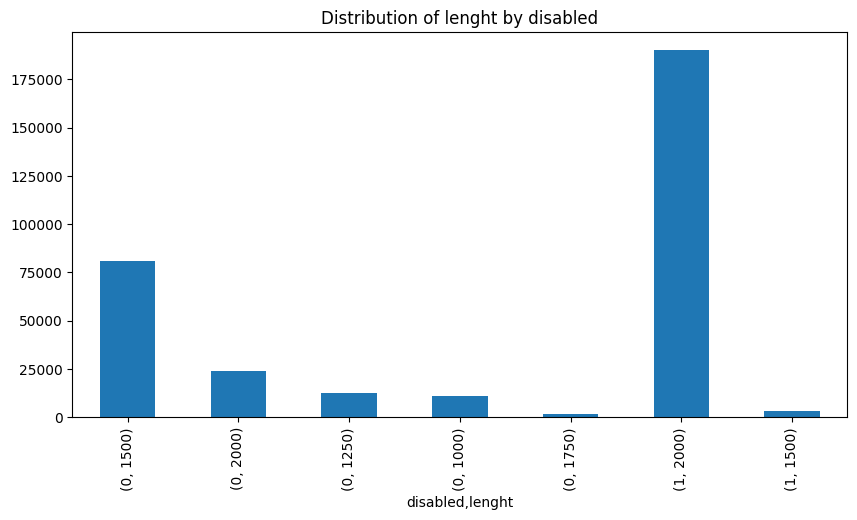

In [ ]:
get_grouped_data(df_all, 'lenght')

In [ ]:
df_all

T        LX        LY        RX        RY     X_mean     Y_mean  \
0           0   0.00000   0.00000   0.00000   0.00000   0.000000   0.000000   
1          20   0.00000  -0.65536  -0.00001   0.00000  -0.000005  -0.327680   
2          40  -0.00001  -0.65537   0.65534  -1.96609   0.327665  -1.310730   
3          60   0.65534  -2.62145   1.31070  -2.62146   0.983020  -2.621455   
4          80   1.31069  -2.62145   1.96605  -1.31074   1.638370  -1.966095   
...       ...       ...       ...       ...       ...        ...        ...   
323245  39900 -39.97774 -61.60447 -39.97773 -61.60446 -39.977735 -61.604465   
323246  39920 -39.97775 -60.94911 -39.97773 -61.60445 -39.977740 -61.276780   
323247  39940 -39.97774 -61.60447 -39.97774 -61.60446 -39.977740 -61.604465   
323248  39960 -39.97774 -60.94910 -39.97774 -60.94910 -39.977740 -60.949100   
323249  39980 -39.97774 -60.94910 -39.97774 -60.94910 -39.977740 -60.949100   

       id_patient  gender  disabled  lenght  
0          112KA1       0         1    2000  
1          112KA1       0         1    2000  
2          112KA1       0         1    2000  
3          112KA1       0         1    2000  
4          112KA1       0         1    2000  
...           ...     ...       ...     ...  
323245     826PP1       0         1    2000  
323246     826PP1       0         1    2000  
323247     826PP1       0         1    2000  
323248     826PP1       0         1    2000  
323249     826PP1       0         1    2000  

[323250 rows x 11 columns]

In [ ]:
df_all.groupby('disabled').size()

disabled
0    130250
1    193000
dtype: int64

In [ ]:
print("Общая информация по набору данных:")
df_500.describe().round(2)

Общая информация по набору данных:


T        LX        LY        RX        RY    X_mean    Y_mean  \
count  92500.00  92500.00  92500.00  92500.00  92500.00  92500.00  92500.00   
mean    4990.00     35.12     -3.97     35.25     -3.98     35.19     -3.98   
std     2886.76     45.27     28.12     45.21     28.13     45.09     28.10   
min        0.00    -67.50   -291.64    -77.33   -292.29    -63.24   -291.97   
25%     2495.00      0.66    -15.73      0.66    -15.73      0.66    -15.40   
50%     4990.00     28.18     -0.66     28.84     -0.66     28.51     -0.65   
75%     7485.00     66.85     10.49     67.50     10.49     67.17     10.49   
max     9980.00    294.26     64.88    294.26     64.23    294.26     63.90   

         gender  disabled  
count  92500.00  92500.00  
mean       0.22      0.52  
std        0.41      0.50  
min        0.00      0.00  
25%        0.00      0.00  
50%        0.00      1.00  
75%        0.00      1.00  
max        1.00      1.00

In [ ]:
print("Общая информация по набору данных:")
df_all.describe().round(2)

Общая информация по набору данных:


T         LX         LY         RX         RY     X_mean  \
count  323250.00  323250.00  323250.00  323250.00  323250.00  323250.00   
mean    18046.84      38.26     -26.99      38.33     -26.98      38.30   
std     10945.03      55.62      56.79      55.63      56.81      55.50   
min         0.00     -67.50    -296.22     -77.33    -295.57     -72.42   
25%      8720.00      -1.31     -49.81      -1.31     -49.15      -1.31   
50%     17460.00      33.42     -16.38      33.42     -16.38      33.10   
75%     26680.00      74.71       7.21      75.37       7.21      75.04   
max     39980.00     294.26      64.88     294.26      64.23     294.26   

          Y_mean     gender   disabled     lenght  
count  323250.00  323250.00  323250.00  323250.00  
mean      -26.98       0.22       0.60    1805.68  
std        56.76       0.41       0.49     288.66  
min      -295.90       0.00       0.00    1000.00  
25%       -49.48       0.00       0.00    1500.00  
50%       -16.06       0.00       1.00    2000.00  
75%         7.21       0.00       1.00    2000.00  
max        64.55       1.00       1.00    2000.00

# Выбор конкретного пациента для эксперементов

In [ ]:
#@title **Выбор параметров** { run: "auto" }
DATA_SET = df_all #@param ['df_500','df_all'] {type:"raw"}
for name, value in globals().items():
    if isinstance(value, pd.DataFrame) and value.equals(DATA_SET):
        df_name = name
        break
ID_PATIENT = '111GM3' #@param ["'112KA1'", "'111RP1'", "'112JU3'", "'131CV4'", "'111GM3'", "'132AD3'", "'111JA2'", "'125KM1'", "'132FJ1'", "'131SA2'", "'141BE2'", "'142EJ1'", "'142MM1'", "'141MS4'", "'132IM3'", "'133AM4'", "'133GJ3'", "'132SJ1'", "'141NK2'", "'141NH4'", "'224BE4'", "'143JM3'", "'224CM2'", "'211LJ1'", "'211ND1'", "'142OJ3'", "'143SM3'", "'211CF3'", "'311HL2'", "'142SJ3'", "'335HJ3'", "'322BJ3'", "'312BE1'", "'312BM4'", "'332PM1'", "'322RE1'", "'312HJ3'", "'332JH3'", "'322EM1'", "'322PS3'", "'342HM1'", "'343SJ1'", "'342GD1'", "'343BJ3'", "'343BL1'", "'343SF1'", "'335NJ1'", "'346KU1'", "'344LL1'", "'351LR1'", "'421LE2'", "'414JM3'", "'352KM1'", "'422JN3'", "'414FJ1'", "'422BC1'", "'351SS3'", "'421LS4'", "'421SP4'", "'421AT2'", "'512LM1'", "'511EE1'", "'512ED1'", "'511YD3'", "'512EO3'", "'423MM3'", "'423MD1'", "'511RD3'", "'512BM2'", "'512PM4'", "'533KM1'", "'522HD3'", "'523GM1'", "'533OA3'", "'522LA3'", "'523FM3'", "'533HM2'", "'532EJ2'", "'522NC1'", "'522BK1'", "'613KF1'", "'612SA1'", "'612LJ3'", "'622FD1'", "'534FT1'", "'621NL4'", "'613SP3'", "'621NP2'", "'622LB3'", "'534SR1'", "'622RM1'", "'623JA1'", "'623WL2'", "'711TA3'", "'623BM4'", "'701AA4'", "'712FJ1'", "'623GH1'", "'622SA3'", "'701LV2'", "'713VC3'", "'714GC4'", "'712WA1'", "'713PE4'", "'712KO3'", "'713PE2'", "'712HL3'", "'721AE4'", "'721AF1'", "'712SJ1'", "'724OP3'", "'724VS1'", "'721KJ2'", "'721HL2'", "'723DT1'", "'725MF1'", "'724SM3'", "'721SM3'", "'721JL4'", "'723SJ1'", "'726PT3'", "'745DJ1'", "'726HD1'", "'742EO3'", "'742AJ3'", "'726OG1'", "'725OM3'", "'732KD1'", "'741US2'", "'745CI4'", "'751GJ3'", "'745RK3'", "'753EM1'", "'752PJ3'", "'752LM3'", "'752AK1'", "'753HP1'", "'752NA1'", "'751AH1'", "'751GS1'", "'754WF3'", "'756FJ3'", "'761SJ1'", "'755TD3'", "'761SJ3'", "'761EL1'", "'761NM3'", "'754TD3'", "'753PJ3'", "'762ET3'", "'775SM1'", "'762VH1'", "'774HJ2'", "'772AK3'", "'771TJ1'", "'762LB3'", "'781PT1'", "'762SL1'", "'772CC1'", "'775DA3'", "'794HH3'", "'782SC3'", "'793MD1'", "'794EM1'", "'781SD3'", "'791LK3'", "'782PR1'", "'794GO3'", "'793LL3'", "'781SE4'", "'794SD1'", "'796PA3'", "'794LA3'", "'795MM1'", "'795SJ1'", "'796GA3'", "'796NT3'", "'826AL2'", "'795JM1'", "'825PA3'", "'826ES4'", "'831OK2'", "'831PA3'", "'826SJ1'", "'826PP1'"] {type:"raw"}



## Расспредление призаков

In [ ]:
DATA_SET[DATA_SET['disabled'] == 0].describe()

T             LX             LY             RX  \
count  130250.000000  130250.000000  130250.000000  130250.000000   
mean    15282.706334      41.946910     -29.304531      42.097034   
std      9365.408073      59.683420      64.708257      59.727010   
min         0.000000     -67.503200    -293.603960     -77.333810   
25%      7400.000000      -0.655310     -51.773820      -0.655000   
50%     14800.000000      38.012870     -15.073490      38.666670   
75%     22500.000000      79.955138       9.175330      79.955228   
max     39980.000000     292.293360      64.225980     292.293400   

                  RY         X_mean         Y_mean         gender  disabled  \
count  130250.000000  130250.000000  130250.000000  130250.000000  130250.0   
mean      -29.287561      42.021972     -29.296046       0.220729       0.0   
std        64.705030      59.544561      64.649224       0.414740       0.0   
min      -293.604130     -72.418505    -293.604010       0.000000       0.0   
25%       -51.773840      -0.570436     -51.773625       0.000000       0.0   
50%       -15.073480      38.338972     -15.073510       0.000000       0.0   
75%         9.175290      79.954970       9.502464       0.000000       0.0   
max        64.225930     292.293345      64.225925       1.000000       0.0   

              lenght  
count  130250.000000  
mean     1529.270633  
std       270.481250  
min      1000.000000  
25%      1500.000000  
50%      1500.000000  
75%      1500.000000  
max      2000.000000

In [ ]:
import numpy as np
import scipy.stats as st

# предположим, что у нас есть DataFrame с данными
df = DATA_SET[DATA_SET['disabled'] == 0]

# рассчитываем статистики для X_mean и Y_mean
stats = df.describe()
list_col = ['mean', 'min', '25%', '50%', '75%', 'max']


for item in list_col:
    x_ci = st.norm.interval(0.95, loc=stats['X_mean'][item], scale=stats['X_mean']['std'] / np.sqrt(stats['X_mean']['count']))
    y_ci = st.norm.interval(0.95, loc=stats['Y_mean'][item], scale=stats['Y_mean']['std'] / np.sqrt(stats['Y_mean']['count']))
    print(f"Интервальная оценка для {item}: {tuple(map(lambda x: round(x, 6), x_ci))}, {tuple(map(lambda x: round(x, 6), y_ci))}")

Интервальная оценка для mean: (41.698601, 42.345344), (-29.647139, -28.944952)
Интервальная оценка для min: (-72.741876, -72.095134), (-293.955103, -293.252917)
Интервальная оценка для 25%: (-0.893807, -0.247065), (-52.124718, -51.422532)
Интервальная оценка для 50%: (38.015601, 38.662344), (-15.424603, -14.722417)
Интервальная оценка для 75%: (79.631599, 80.278341), (9.15137, 9.853557)
Интервальная оценка для max: (291.969974, 292.616716), (63.874832, 64.577018)


In [ ]:
DATA_SET[DATA_SET['disabled'] == 1].describe()

T             LX             LY             RX  \
count  193000.000000  193000.000000  193000.000000  193000.000000   
mean    19912.279793      35.766675     -25.429678      35.794111   
std     11524.313992      52.546599      50.688309      52.541272   
min         0.000000     -64.224820    -296.224070     -64.225530   
25%      9940.000000      -1.965692     -48.496125      -1.965803   
50%     19880.000000      30.146640     -17.039320      30.146795   
75%     29840.000000      71.435210       5.898240      71.435200   
max     39980.000000     294.256690      64.881580     294.258830   

                  RY         X_mean         Y_mean         gender  disabled  \
count  193000.000000  193000.000000  193000.000000  193000.000000  193000.0   
mean      -25.415562      35.780393     -25.422620       0.217617       1.0   
std        50.725536      52.438093      50.679803       0.412626       0.0   
min      -295.568960     -64.223180    -295.896370       0.000000       1.0   
25%       -47.842100      -1.638580     -48.169300       0.000000       1.0   
50%       -17.039330      29.819545     -17.038913       0.000000       1.0   
75%         5.898270      71.434372       5.898220       0.000000       1.0   
max        64.226220     294.257560      64.553900       1.000000       1.0   

              lenght  
count  193000.000000  
mean     1992.227979  
std        61.851644  
min      1500.000000  
25%      2000.000000  
50%      2000.000000  
75%      2000.000000  
max      2000.000000

In [ ]:
import numpy as np
import scipy.stats as st

# предположим, что у нас есть DataFrame с данными
df = DATA_SET[DATA_SET['disabled'] == 1]

# рассчитываем статистики для X_mean и Y_mean
stats = df.describe()
list_col = ['mean', 'min', '25%', '50%', '75%', 'max']


for item in list_col:
    x_ci = st.norm.interval(0.95, loc=stats['X_mean'][item], scale=stats['X_mean']['std'] / np.sqrt(stats['X_mean']['count']))
    y_ci = st.norm.interval(0.95, loc=stats['Y_mean'][item], scale=stats['Y_mean']['std'] / np.sqrt(stats['Y_mean']['count']))
    print(f"Интервальная оценка для {item}: {tuple(map(lambda x: round(x, 6), x_ci))}, {tuple(map(lambda x: round(x, 6), y_ci))}")

Интервальная оценка для mean: (35.546447, 36.014339), (-25.648722, -25.196518)
Интервальная оценка для min: (-64.457126, -63.989234), (-296.122472, -295.670268)
Интервальная оценка для 25%: (-1.872526, -1.404634), (-48.395402, -47.943198)
Интервальная оценка для 50%: (29.585599, 30.053491), (-17.265014, -16.812811)
Интервальная оценка для 75%: (71.200426, 71.668319), (5.672118, 6.124322)
Интервальная оценка для max: (294.023614, 294.491506), (64.327798, 64.780002)


## Визуализация

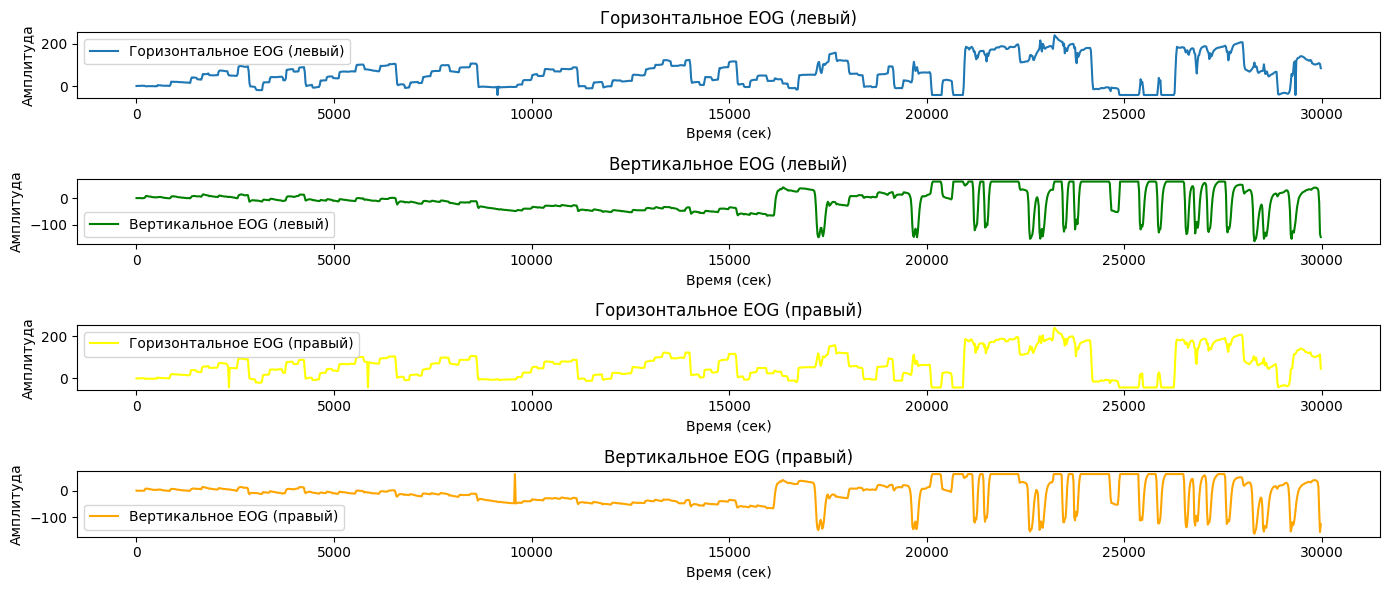

In [ ]:
plot_eog(DATA_SET[DATA_SET['id_patient'] == ID_PATIENT])

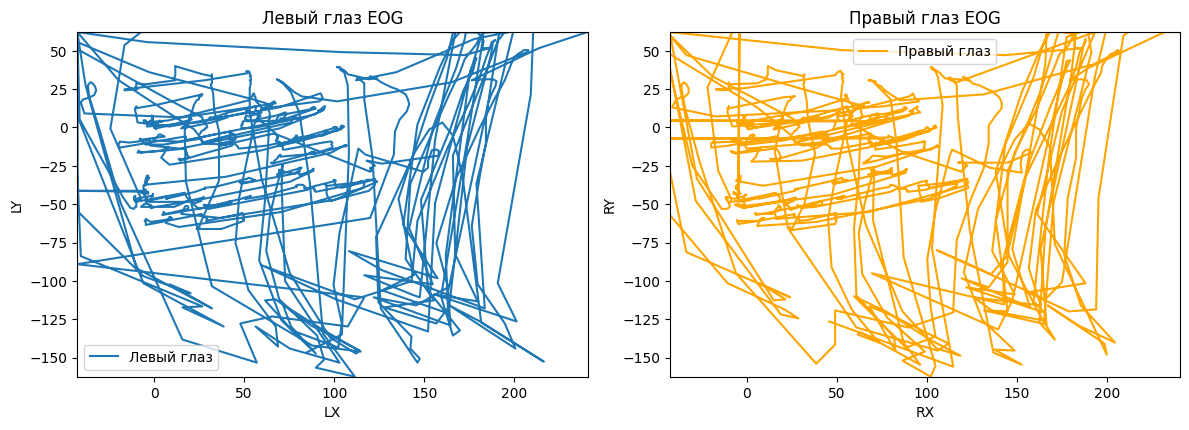

In [ ]:
plot_eog_lr(DATA_SET[DATA_SET['id_patient'] == ID_PATIENT])

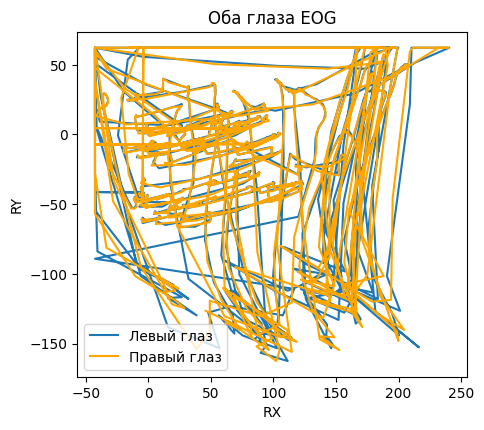

In [ ]:
plot_eog_lr_union(DATA_SET[DATA_SET['id_patient'] == ID_PATIENT])

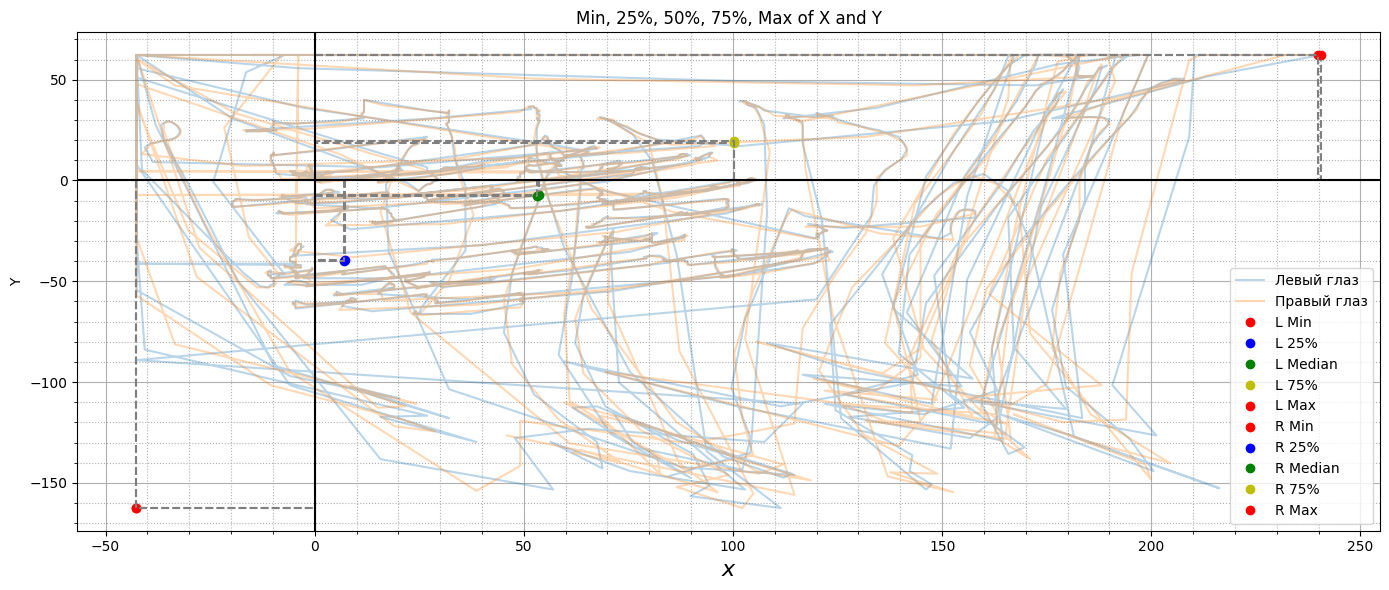

In [ ]:
plot_stats_xy(DATA_SET[DATA_SET['id_patient'] == ID_PATIENT], DATA_SET[DATA_SET['id_patient'] == ID_PATIENT])

In [ ]:
plotly_3d(DATA_SET[DATA_SET['id_patient'] == ID_PATIENT], ['T', 'X_mean', 'Y_mean'],)

# Извлечение признаков

In [ ]:
DF_TOTAL = DATA_SET.copy()

## Математические алгоритмы

### IVT

#### Ед. пац

In [ ]:
df_ivt_solo = add_event_features_ivt(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], 0.2) # 1, 2, 10, 60

<ipython-input-73-761f0c681370>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-73-761f0c681370>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_ivt_solo[df_ivt_solo['id_patient'] == ID_PATIENT]['IVT'].value_counts()

IVT
fixation    1619
saccade      381
Name: count, dtype: int64

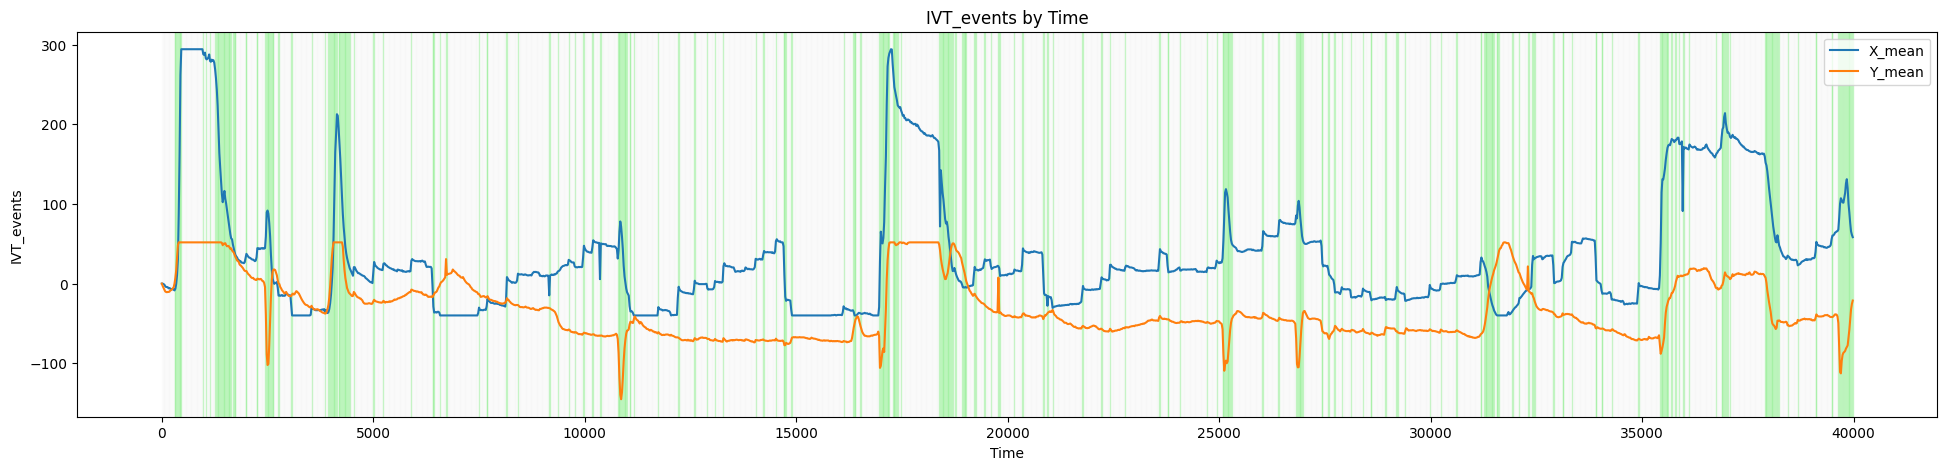

In [ ]:
plot_events(df_ivt_solo[df_ivt_solo['id_patient'] == ID_PATIENT], ['IVT'])

#### Общее

In [ ]:
DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: add_event_features_ivt(group, 0.2)) # 0.1257
DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_ivt.csv', index=False)

100%|██████████| 185/185 [00:00<00:00, 311.52it/s]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_ivt.csv')

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT].sample()

T        LX       LY        RX       RY     X_mean   Y_mean  \
73154  3080  33.42375  3.27685  32.76838  2.62149  33.096065  2.94917   

      id_patient  gender  disabled  velocity       IVT  
73154     761NM3       0         0  0.016384  fixation

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['IVT'].value_counts()

IVT
fixation    1619
saccade      381
Name: count, dtype: int64

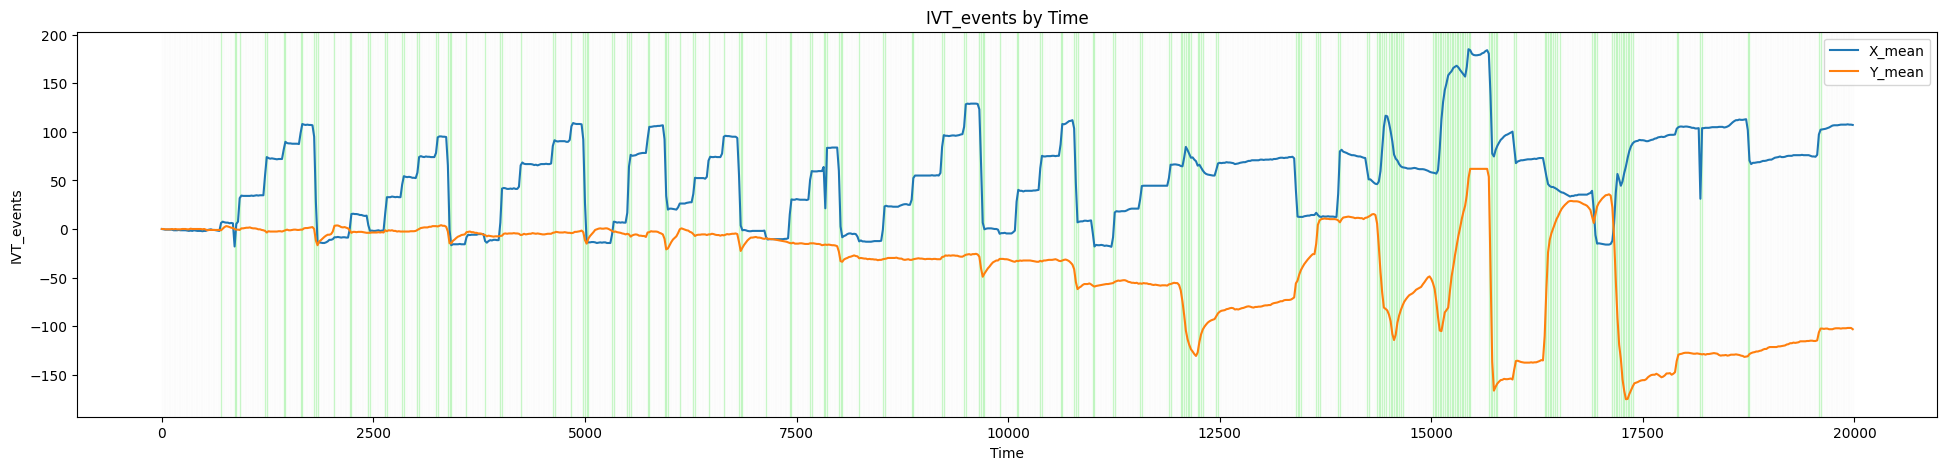

In [ ]:
plot_events(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['IVT'])

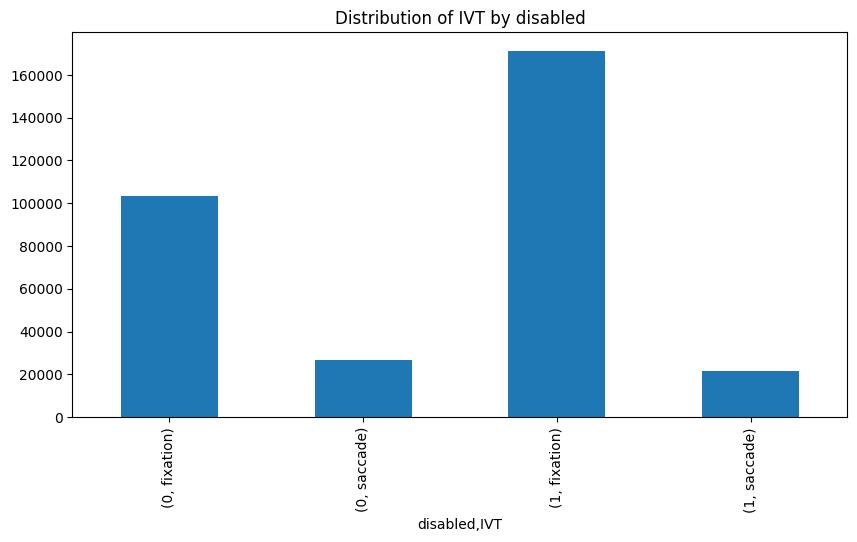

In [ ]:
get_grouped_data(DF_TOTAL, 'IVT')

In [ ]:
DF_TOTAL.isna().sum()

T             0
LX            0
LY            0
RX            0
RY            0
X_mean        0
Y_mean        0
id_patient    0
gender        0
disabled      0
velocity      0
IVT           0
dtype: int64

### IDT

#### Ед. пац

In [ ]:
df_idt_solo = add_event_features_idt(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], 5, 10) # 1, 2, 10, 60

<ipython-input-22-73f6142c82b4>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_idt_solo[df_idt_solo['id_patient'] == ID_PATIENT]['IDT'].value_counts()

IDT
fixation    758
saccade     742
Name: count, dtype: int64

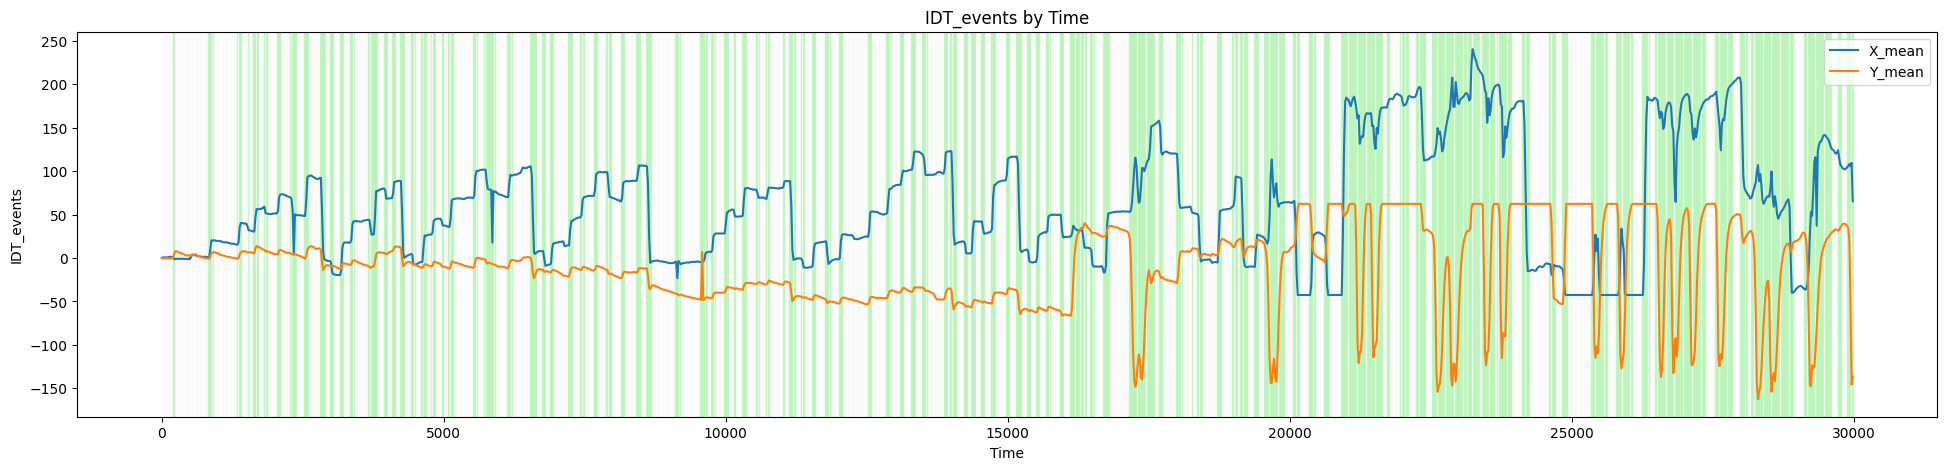

In [ ]:
plot_events(df_idt_solo[df_idt_solo['id_patient'] == ID_PATIENT], ['IDT'])

#### Общее

In [ ]:
DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: add_event_features_idt(group, 5, 10)) # 3, 5
DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_idt.csv', index=False)

100%|██████████| 185/185 [03:37<00:00,  1.18s/it]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_idt.csv')

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT].sample()

T       LX       LY       RX       RY    X_mean   Y_mean id_patient  \
73012  240  1.96607  0.00001  2.62142  0.00001  2.293745  0.00001     761NM3   

       gender  disabled  velocity       IVT       IDT  
73012       0         0  0.016384  fixation  fixation

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['IDT'].value_counts()

IDT
fixation    340
saccade     160
Name: count, dtype: int64

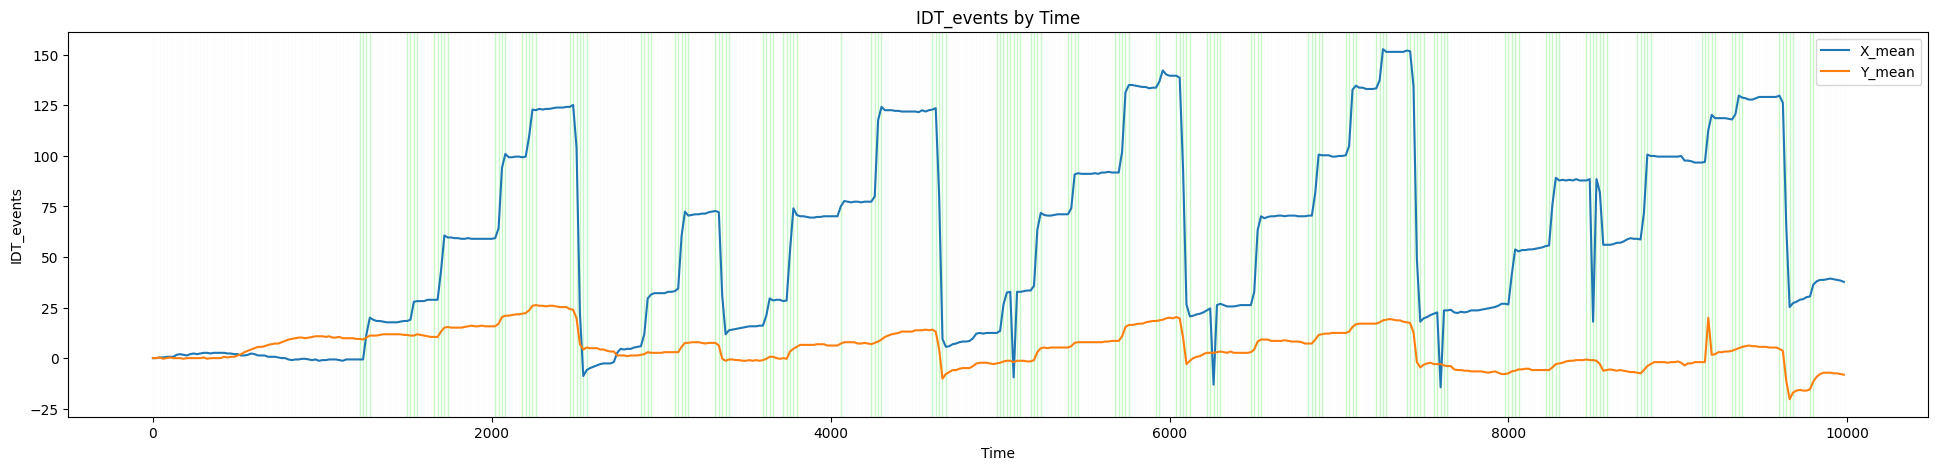

In [ ]:
plot_events(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['IDT'])

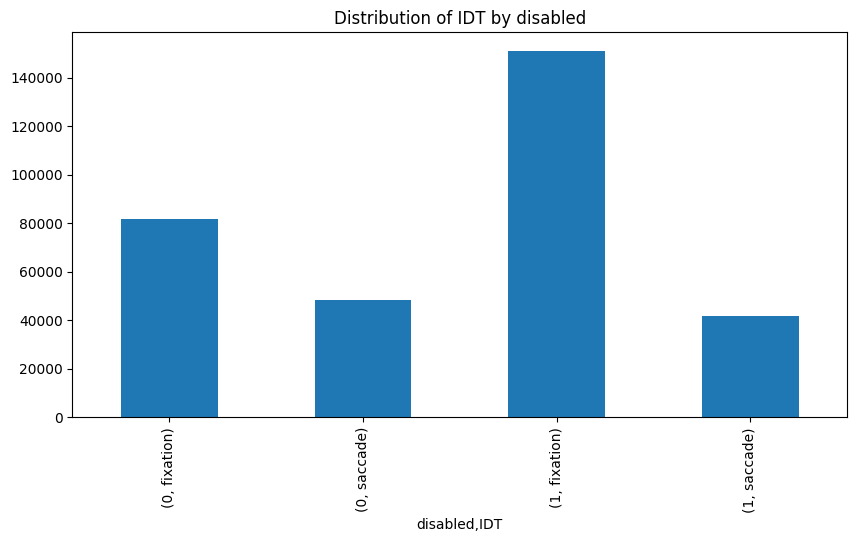

In [ ]:
get_grouped_data(DF_TOTAL, 'IDT')

In [ ]:
DF_TOTAL.isna().sum()

T             0
LX            0
LY            0
RX            0
RY            0
X_mean        0
Y_mean        0
id_patient    0
gender        0
disabled      0
velocity      0
IVT           0
IDT           0
dtype: int64

### IDT - MOD

#### Знак производной

In [ ]:
DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: get_sign(group, ['X_mean', 'Y_mean']))
DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_sign.csv', index=False)

100%|██████████| 185/185 [00:00<00:00, 337.74it/s]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_sign.csv')

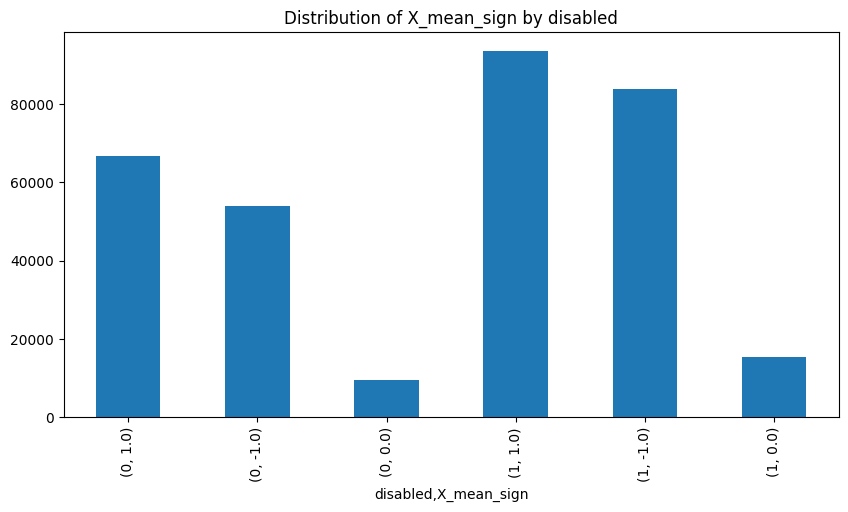

In [ ]:
get_grouped_data(DF_TOTAL, 'X_mean_sign')

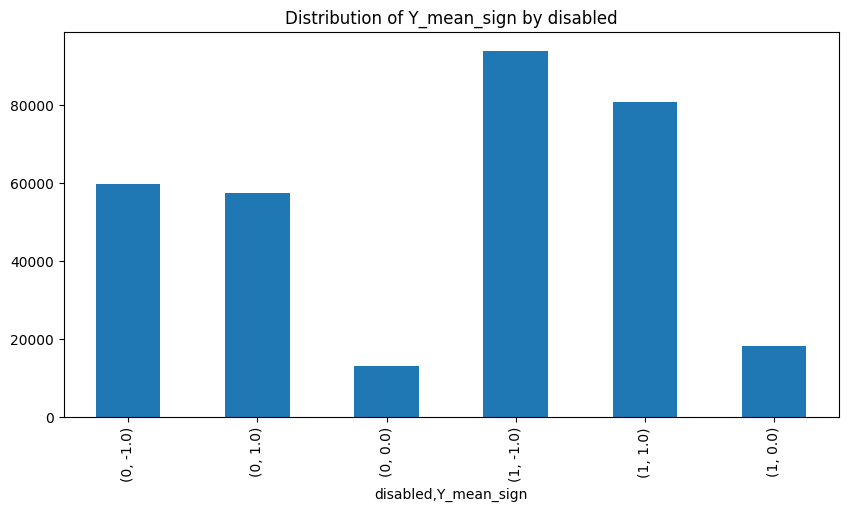

In [ ]:
get_grouped_data(DF_TOTAL, 'Y_mean_sign')

#### Ед. пац

In [ ]:
df_idt_mod_solo = add_event_features_idt_mod(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT],
                                            window_size = 5,
                                            dispersion_threshold_prog = 10,
                                            dispersion_threshold_reg = 10) # 1, 2, 10, 60

<ipython-input-24-edbbb86bfa9e>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-edbbb86bfa9e>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-edbbb86bfa9e>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_idt_mod_solo[df_idt_mod_solo['id_patient'] == ID_PATIENT]['NE_event'].value_counts()

NE_event
saccade_progressive     519
fixation_progressive    410
fixation_regressive     351
saccade_regressive      217
other                     3
Name: count, dtype: int64

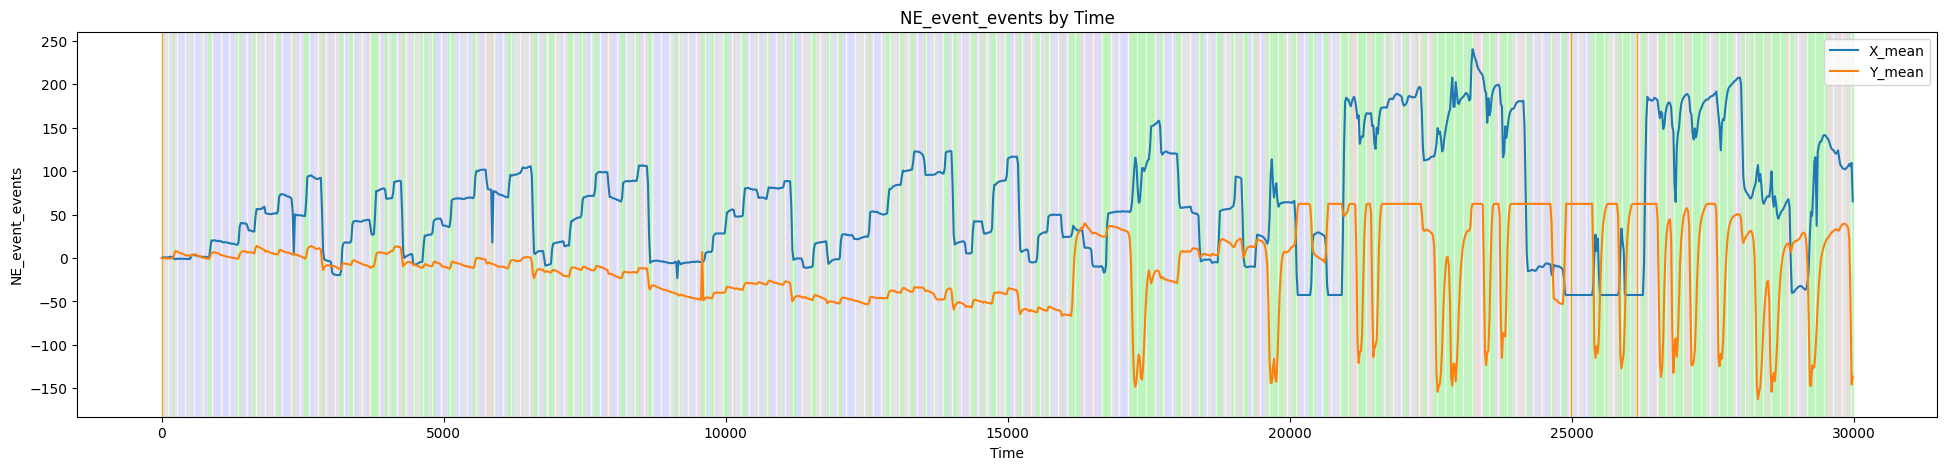

In [ ]:
plot_events(df_idt_mod_solo[df_idt_mod_solo['id_patient'] == ID_PATIENT], ['NE_event'])

In [ ]:
df_idt_mod_solo[df_idt_mod_solo.isna().any(axis=1)][df_idt_mod_solo['id_patient'] == ID_PATIENT][:50]

<ipython-input-1117-3e053a77ebde>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Empty DataFrame
Columns: [T, LX, LY, RX, RY, X_mean, Y_mean, id_patient, gender, disabled, velocity, IVT, IDT, X_mean_derivative, X_mean_sign, Y_mean_derivative, Y_mean_sign, NE_event, EN_event, MEAN_event]
Index: []

#### Общее

In [ ]:
DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: add_event_features_idt_mod(group,
                                                                                                    window_size = 5,
                                                                                                    dispersion_threshold_prog = 10,
                                                                                                    dispersion_threshold_reg = 10))
DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_idt_mod.csv', index=False)

100%|██████████| 185/185 [08:11<00:00,  2.66s/it]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_idt_mod.csv')

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['NE_event'].value_counts()

NE_event
saccade_progressive     519
fixation_progressive    410
fixation_regressive     351
saccade_regressive      217
other                     3
Name: count, dtype: int64

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['EN_event'].value_counts()

EN_event
fixation_progressive    623
saccade_progressive     370
saccade_regressive      366
fixation_regressive     138
other                     3
Name: count, dtype: int64

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['MEAN_event'].value_counts()

MEAN_event
unknown                 1072
fixation_progressive     272
saccade_progressive      153
other                      3
Name: count, dtype: int64

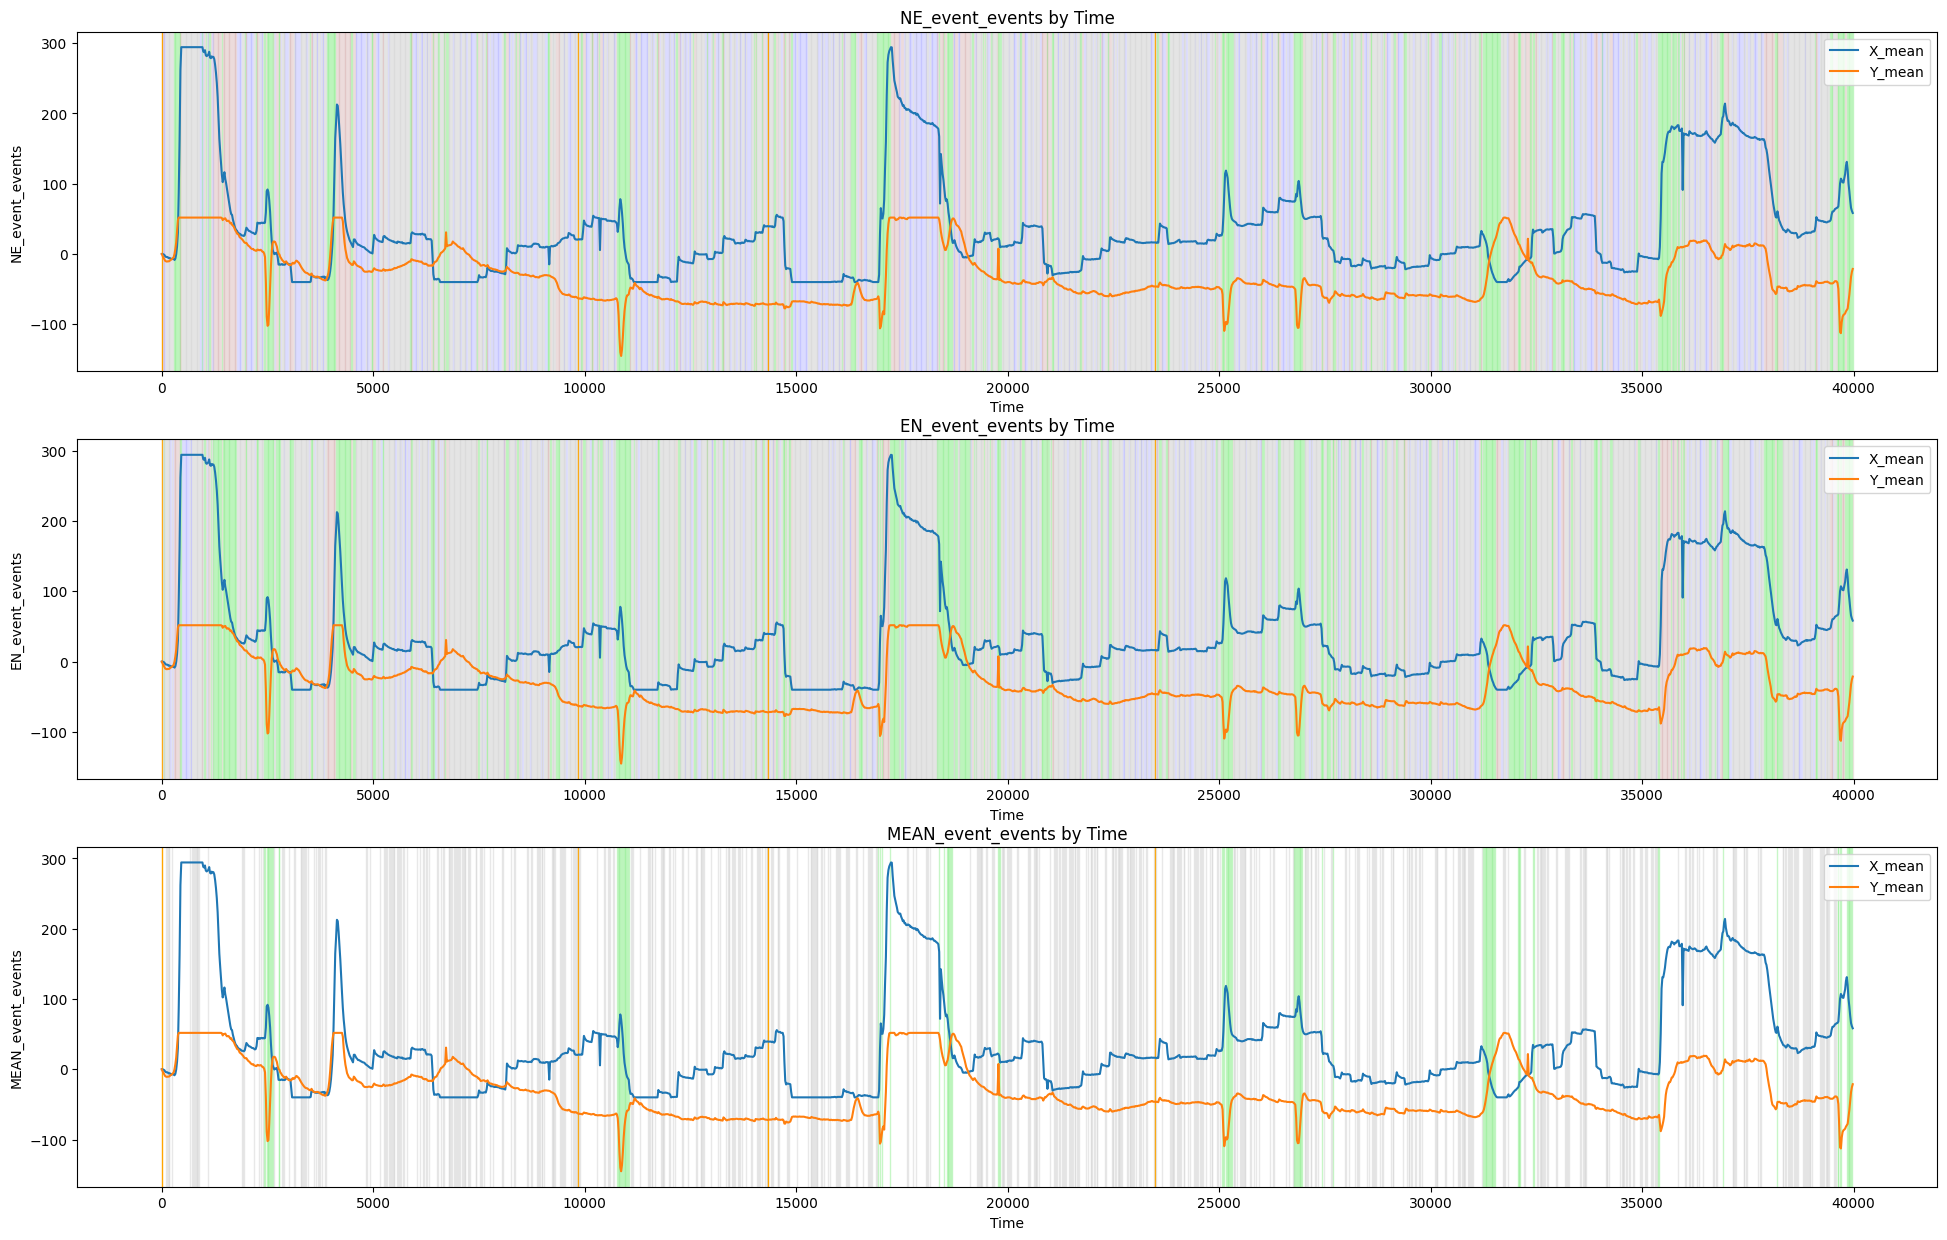

In [ ]:
plot_events(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['NE_event', 'EN_event', 'MEAN_event'])

In [ ]:
DF_TOTAL.isna().sum()

T                    0
LX                   0
LY                   0
RX                   0
RY                   0
X_mean               0
Y_mean               0
id_patient           0
gender               0
disabled             0
velocity             0
IVT                  0
IDT                  0
X_mean_derivative    0
X_mean_sign          0
Y_mean_derivative    0
Y_mean_sign          0
NE_event             0
EN_event             0
MEAN_event           0
dtype: int64

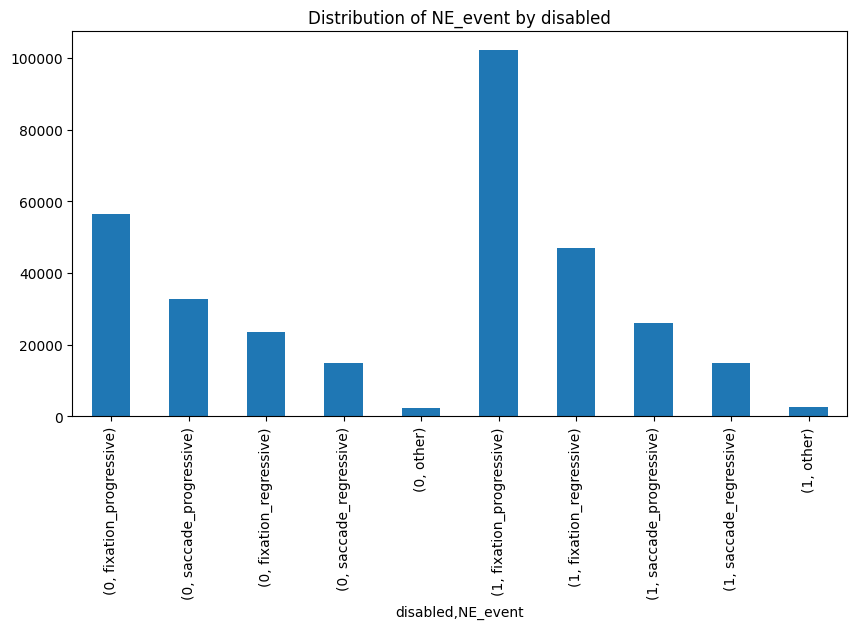

In [ ]:
get_grouped_data(DF_TOTAL, 'NE_event')

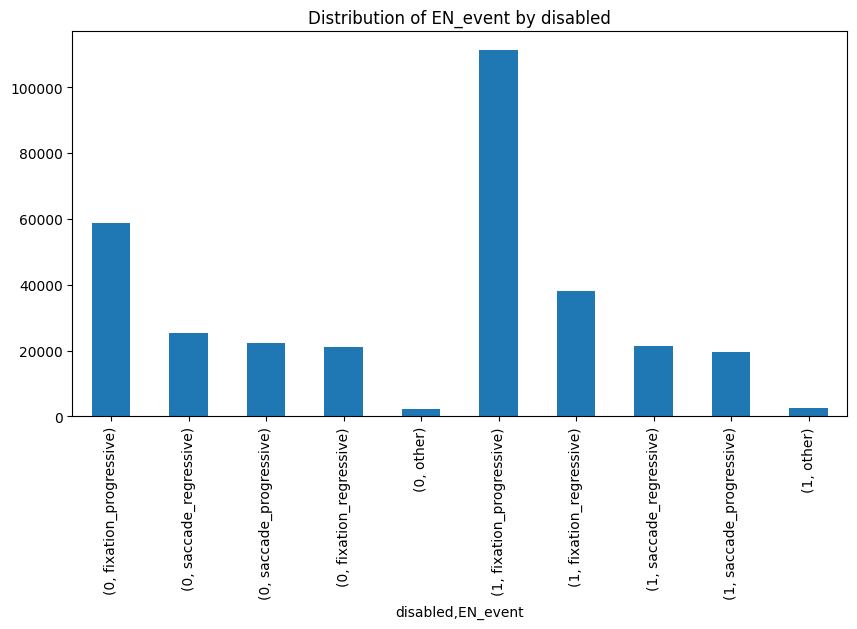

In [ ]:
get_grouped_data(DF_TOTAL, 'EN_event')

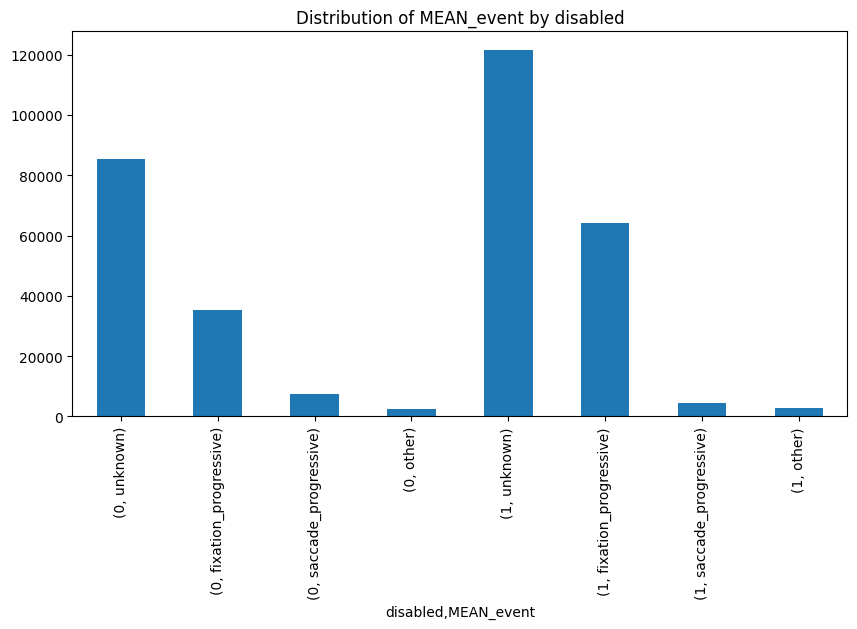

In [ ]:
get_grouped_data(DF_TOTAL, 'MEAN_event')

In [ ]:
DF_TOTAL[DF_TOTAL.isna().any(axis=1)][DF_TOTAL['id_patient'] == ID_PATIENT][:50]

<ipython-input-331-f328e6239456>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Empty DataFrame
Columns: [T, LX, LY, RX, RY, X_mean, Y_mean, id_patient, gender, disabled, velocity, IVT, IDT, X_mean_derivative, X_mean_sign, Y_mean_derivative, Y_mean_sign, NE_event, EN_event, MEAN_event]
Index: []

### Transition

#### Ед. пац

In [ ]:
df_trans_solo = add_event_features_transition(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], 25, 0.5, 2.5)

<ipython-input-25-f74ed9261a4d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_trans_solo[df_trans_solo['id_patient'] == ID_PATIENT]['TRANS'].value_counts()

TRANS
other    1603
event     397
Name: count, dtype: int64

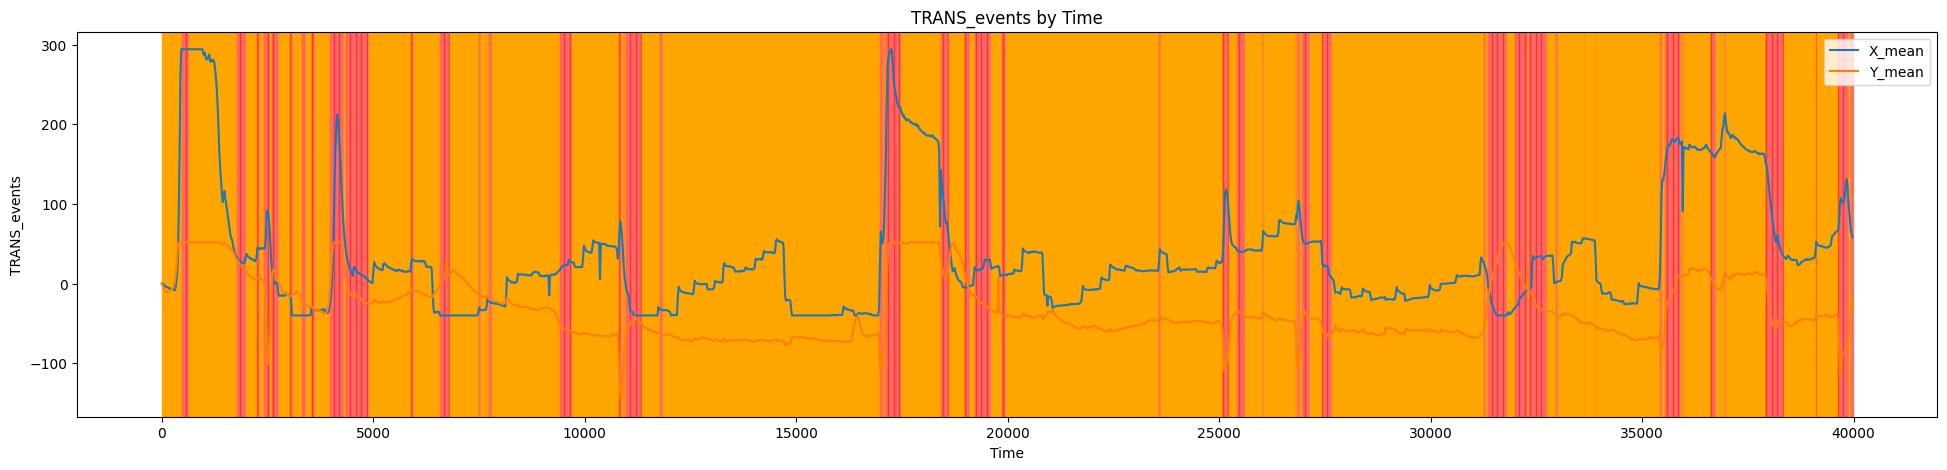

In [ ]:
plot_events(df_trans_solo[df_trans_solo['id_patient'] == ID_PATIENT], ['TRANS'])

#### Общее

In [ ]:
DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: add_event_features_transition(group, 25, 0.5, 2.5))
DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_trans.csv', index=False)

100%|██████████| 185/185 [02:05<00:00,  1.48it/s]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_trans.csv')

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['TRANS'].value_counts()

TRANS
other    1208
event     292
Name: count, dtype: int64

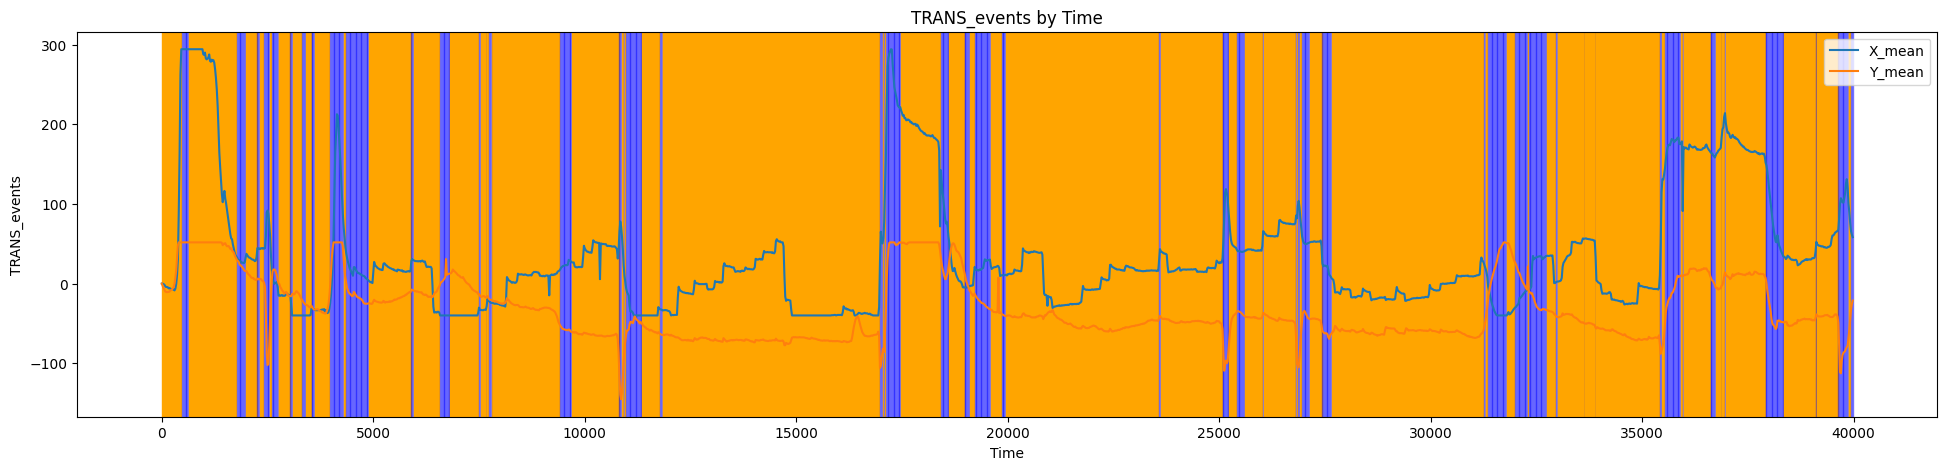

In [ ]:
plot_events(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['TRANS'])

In [ ]:
DF_TOTAL.isna().sum()

T                    0
LX                   0
LY                   0
RX                   0
RY                   0
X_mean               0
Y_mean               0
id_patient           0
gender               0
disabled             0
velocity             0
IVT                  0
IDT                  0
X_mean_derivative    0
X_mean_sign          0
Y_mean_derivative    0
Y_mean_sign          0
NE_event             0
EN_event             0
MEAN_event           0
TRANS                0
dtype: int64

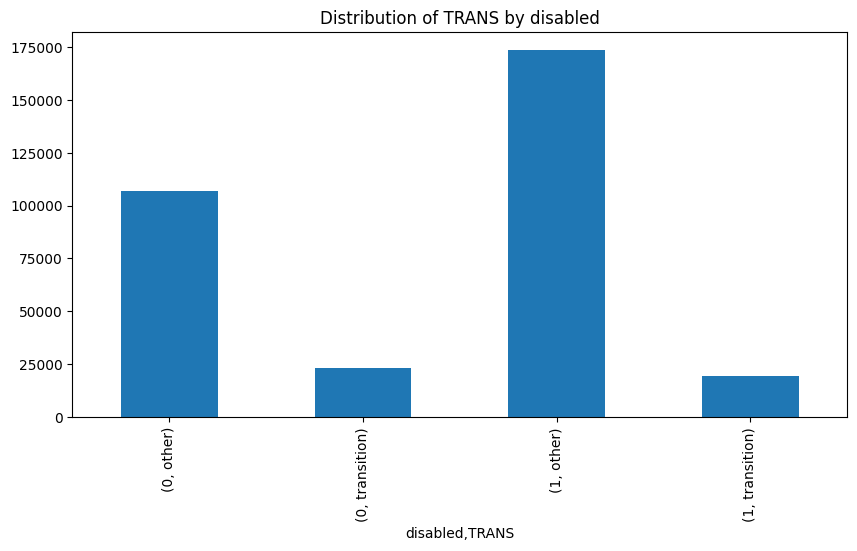

In [ ]:
get_grouped_data(DF_TOTAL, 'TRANS')

## Методы машинного обучения

### DBSCAN

#### Ед. пац

In [ ]:
df_dbscan_solo = find_fixations_DBSCAN(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT],
                                      ['T', 'X_mean', 'Y_mean'],
                                       'P',
                                        20.000000001,
                                        2)

<ipython-input-26-5f044e9f7504>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_dbscan_solo[df_dbscan_solo['id_patient'] == ID_PATIENT]['DBSCAN_P'].value_counts()

DBSCAN_P
-1     1829
 0       21
 26       5
 25       4
 31       4
       ... 
 30       2
 32       2
 33       2
 34       2
 70       2
Name: count, Length: 72, dtype: int64

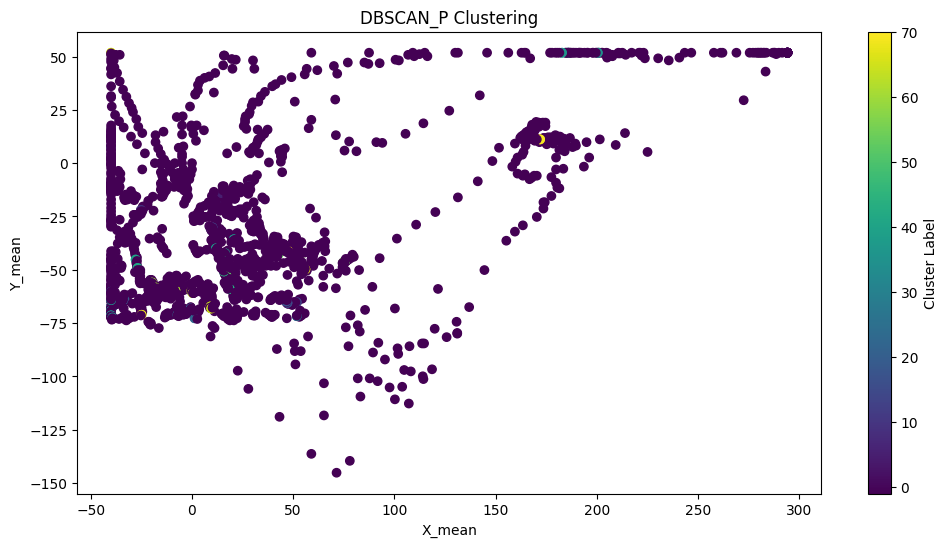

In [ ]:
plot_clusters(df_dbscan_solo[df_dbscan_solo['id_patient'] == ID_PATIENT], 'DBSCAN_P', ['X_mean', 'Y_mean'])

#### Общее

In [ ]:
prefix = 'P'
epsilon = 20.000000001
points = 2
lambda_func = lambda x: 'other' if x == -1 else 'event'

DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: find_fixations_DBSCAN(group,
                                                                                              ['T', 'X_mean', 'Y_mean'],
                                                                                              prefix,
                                                                                              lambda_func,
                                                                                              epsilon,
                                                                                              points)) # 3

DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_dbscan.csv', index=False)
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_dbscan.csv')

100%|██████████| 185/185 [00:02<00:00, 81.35it/s]


In [ ]:
prefix = 'FS'
epsilon = 20.01
points = 2
lambda_func = lambda x: 'event' if x == -1 else 'other'

DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: find_fixations_DBSCAN(group,
                                                                                              ['T', 'X_mean', 'Y_mean'],
                                                                                              prefix,
                                                                                              lambda_func,
                                                                                              epsilon,
                                                                                              points))

DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_dbscan.csv', index=False)
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_dbscan.csv')

100%|██████████| 185/185 [00:02<00:00, 69.91it/s]


In [ ]:
prefix = 'T'
epsilon = 30
points = 2
lambda_func = lambda x: 'event' if x == -1 else 'other'

DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: find_fixations_DBSCAN(group,
                                                                                              ['T', 'X_mean', 'Y_mean'],
                                                                                              prefix,
                                                                                              lambda_func,
                                                                                              epsilon,
                                                                                              points))

DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_dbscan.csv', index=False)

100%|██████████| 185/185 [00:02<00:00, 73.26it/s]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_dbscan.csv')

In [ ]:
DF_TOTAL

T        LX        LY        RX        RY     X_mean     Y_mean  \
0           0   0.00000   0.00000   0.00000   0.00000   0.000000   0.000000   
1          20   0.65535  -0.00001   0.65536  -0.65536   0.655355  -0.327685   
2          40   0.65534  -0.00001   0.65536  -0.65536   0.655350  -0.327685   
3          60   0.65534  -0.00001   0.65535  -0.65536   0.655345  -0.327685   
4          80   0.65534  -0.00001   0.65534   0.00000   0.655340  -0.000005   
...       ...       ...       ...       ...       ...        ...        ...   
323245  29900 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323246  29920 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323247  29940 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323248  29960 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323249  29980 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   

       id_patient  gender  disabled  ...  X_mean_sign  Y_mean_derivative  \
0          111GM3       0         0  ...          1.0          -0.016384   
1          111GM3       0         0  ...          1.0          -0.008192   
2          111GM3       0         0  ...         -1.0           0.000000   
3          111GM3       0         0  ...         -1.0           0.008192   
4          111GM3       0         0  ...         -1.0           0.000000   
...           ...     ...       ...  ...          ...                ...   
323245     831PA3       0         0  ...          0.0           0.000000   
323246     831PA3       0         0  ...          0.0           0.000000   
323247     831PA3       0         0  ...          0.0           0.000000   
323248     831PA3       0         0  ...          0.0           0.000000   
323249     831PA3       0         0  ...          0.0           0.000000   

       Y_mean_sign              NE_event              EN_event  \
0             -1.0                 other                 other   
1             -1.0  fixation_progressive  fixation_progressive   
2              0.0   fixation_regressive  fixation_progressive   
3              1.0  fixation_progressive  fixation_progressive   
4              0.0  fixation_progressive  fixation_progressive   
...            ...                   ...                   ...   
323245         0.0                 other                 other   
323246         0.0                 other                 other   
323247         0.0                 other                 other   
323248         0.0                 other                 other   
323249         0.0                 other                 other   

                  MEAN_event  TRANS  DBSCAN_P DBSCAN_FS DBSCAN_T  
0                      other  other     other     event    other  
1       fixation_progressive  other     event     other    other  
2                    unknown  other     event     other    other  
3       fixation_progressive  other     event     other    other  
4       fixation_progressive  other     other     other    other  
...                      ...    ...       ...       ...      ...  
323245                 other  other     event     other    other  
323246                 other  other     event     other    other  
323247                 other  other     event     other    other  
323248                 other  other     event     other    other  
323249                 other  other     event     other    other  

[323250 rows x 25 columns]

In [ ]:
plot_clusters(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], f'DBSCAN_{prefix}', ['X_mean', 'Y_mean'])

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['DBSCAN_P'].value_counts()

DBSCAN_P
other    856
event    144
Name: count, dtype: int64

<ipython-input-125-f1ae6447cbc2>:14: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



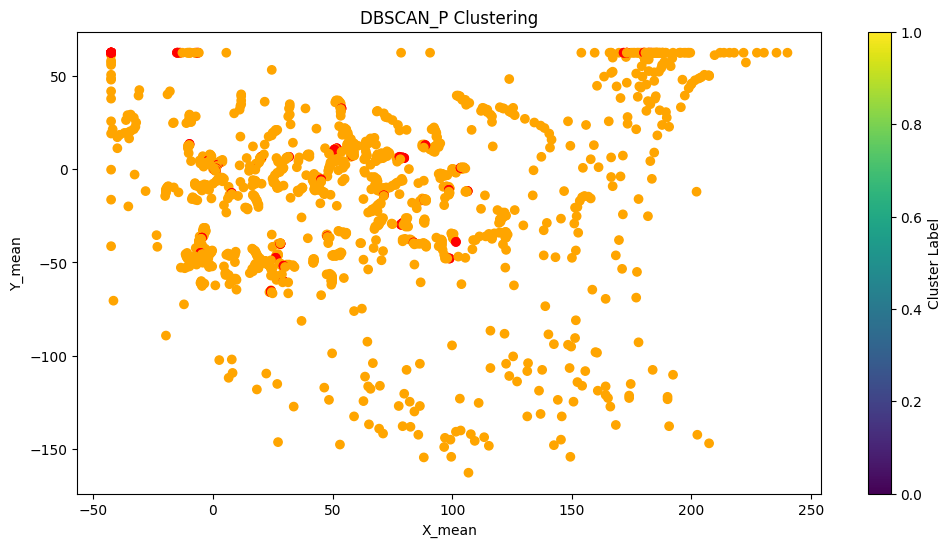

In [ ]:
plot_clusters(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], 'DBSCAN_P', ['X_mean', 'Y_mean'])

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['DBSCAN_FS'].value_counts()

DBSCAN_FS
other    797
event    203
Name: count, dtype: int64

<ipython-input-125-f1ae6447cbc2>:14: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



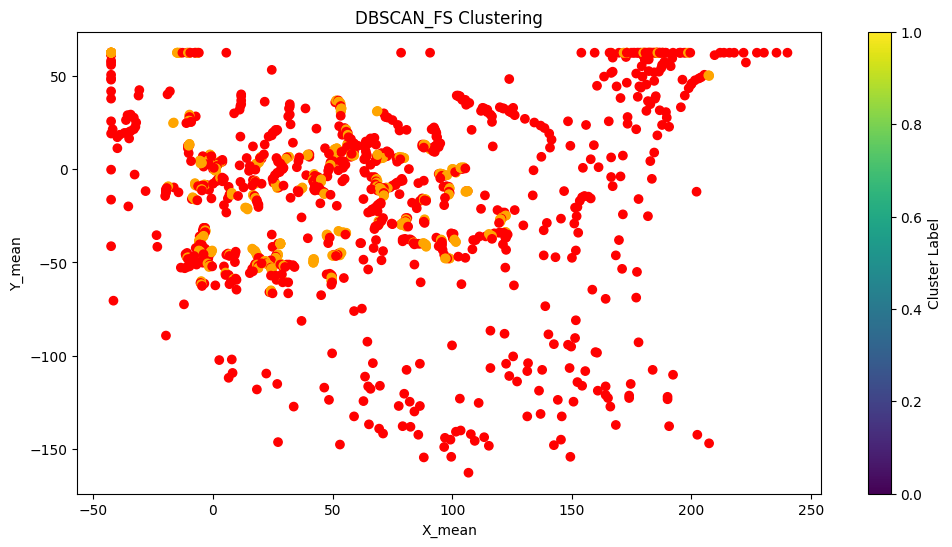

In [ ]:
plot_clusters(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], 'DBSCAN_FS', ['X_mean', 'Y_mean'])

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['DBSCAN_T'].value_counts()

DBSCAN_T
other    977
event     23
Name: count, dtype: int64

<ipython-input-125-f1ae6447cbc2>:14: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



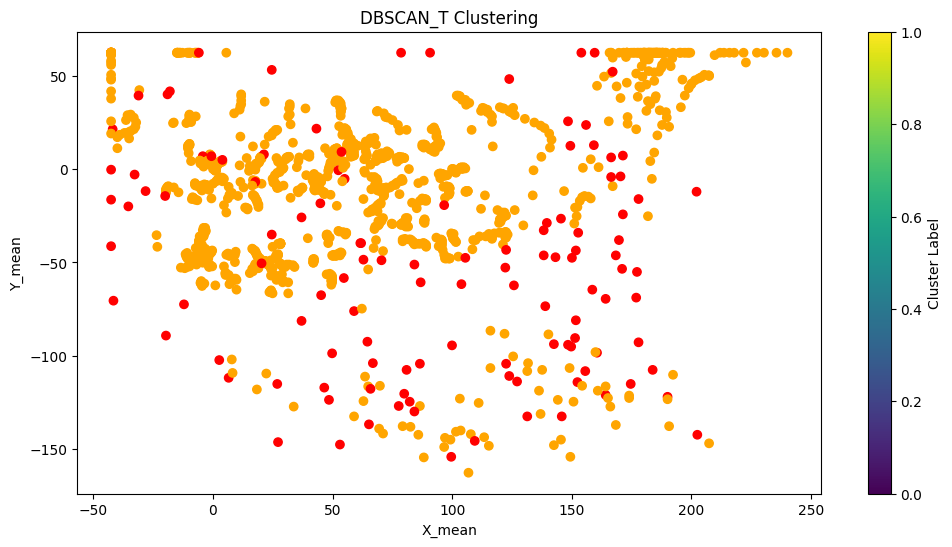

In [ ]:
plot_clusters(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], 'DBSCAN_T', ['X_mean', 'Y_mean'])

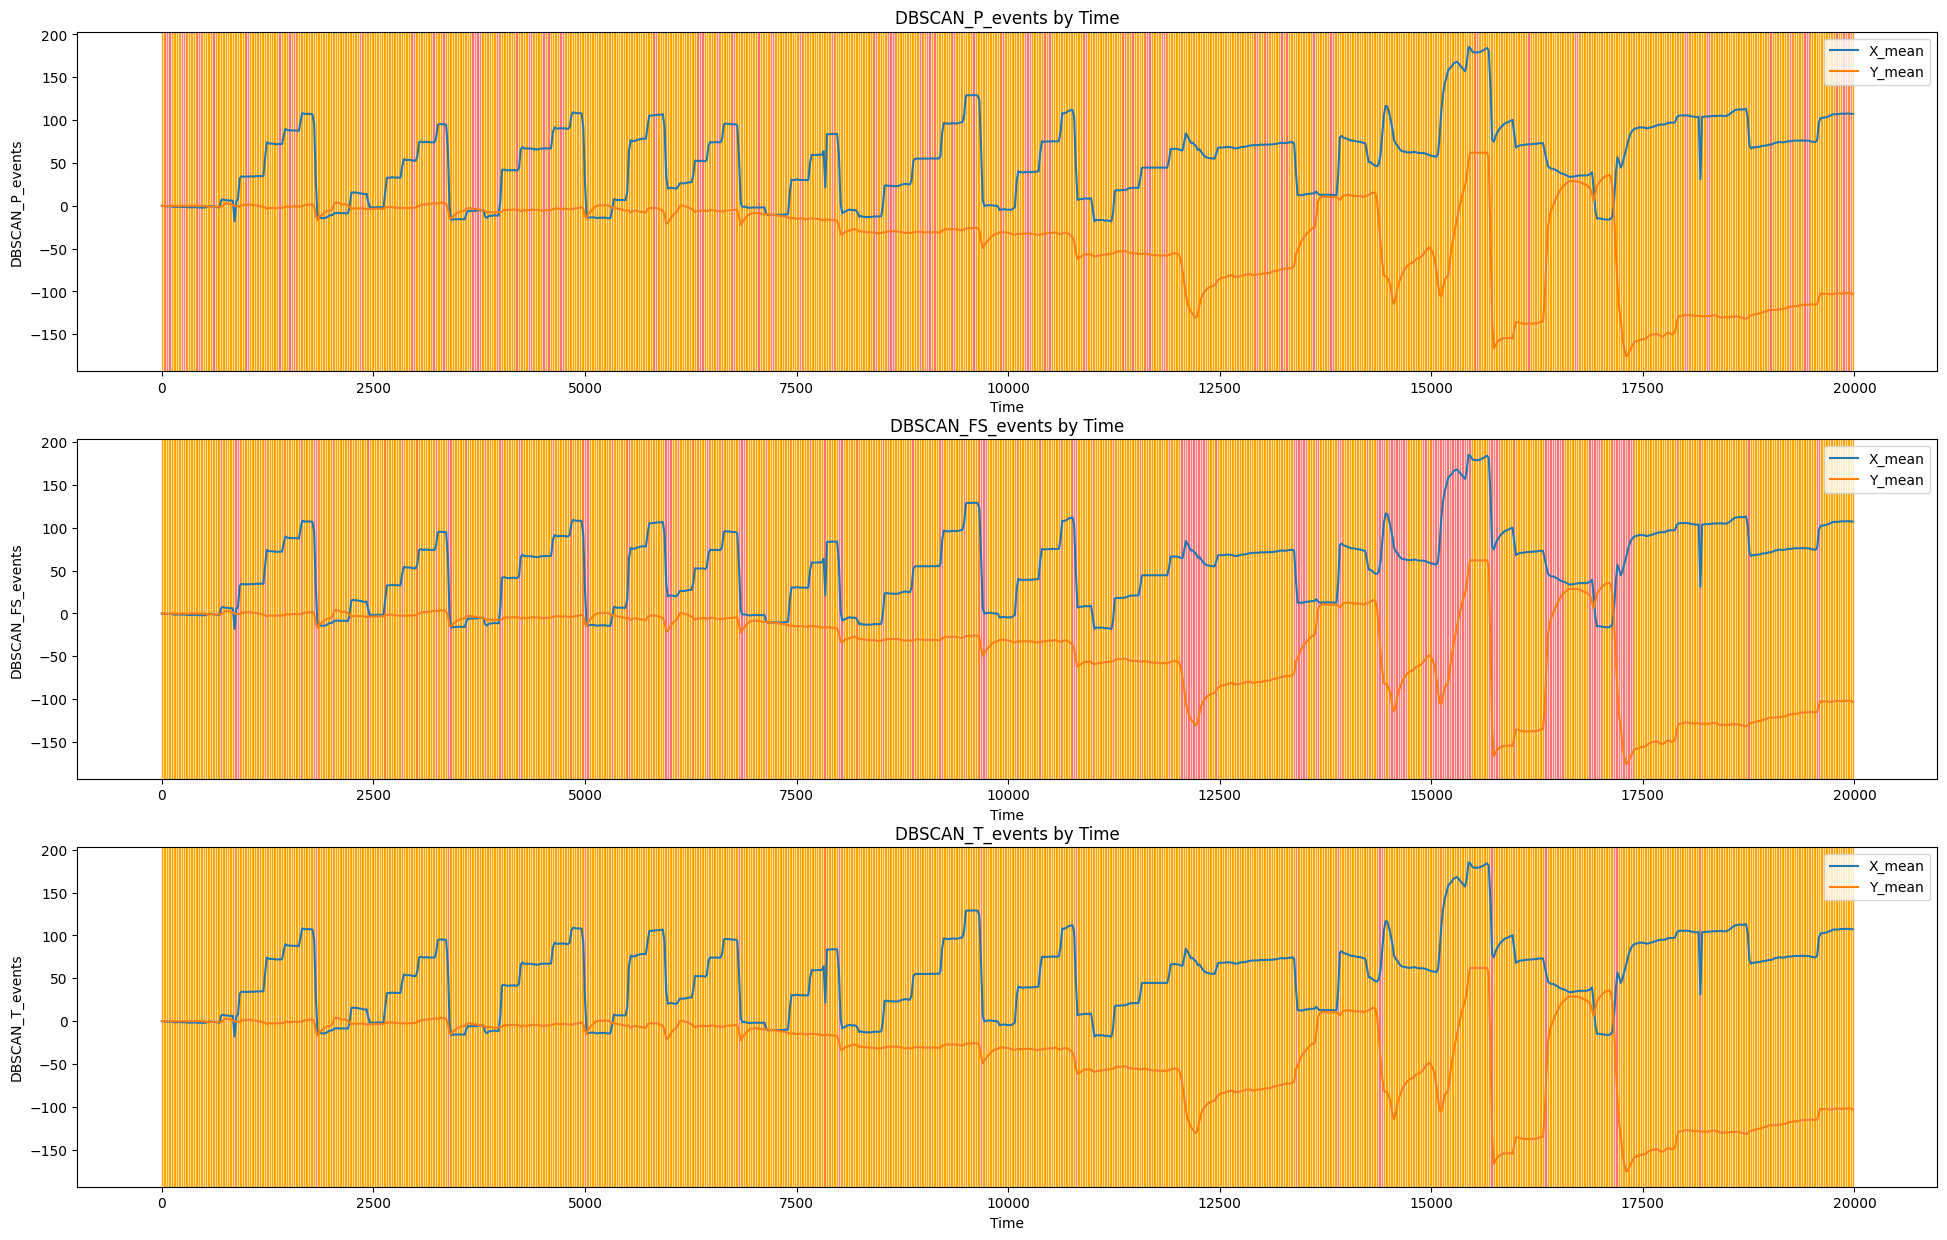

In [ ]:
plot_events(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['DBSCAN_P', 'DBSCAN_FS', 'DBSCAN_T'])

In [ ]:
plotly_3d(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['T', 'X_mean', 'Y_mean'], 'DBSCAN_P')

In [ ]:
plotly_3d(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['T', 'X_mean', 'Y_mean'], 'DBSCAN_FS')

In [ ]:
plotly_3d(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['T', 'X_mean', 'Y_mean'], 'DBSCAN_T')

In [ ]:
DF_TOTAL.isna().sum()

T                    0
LX                   0
LY                   0
RX                   0
RY                   0
X_mean               0
Y_mean               0
id_patient           0
gender               0
disabled             0
velocity             0
IVT                  0
IDT                  0
X_mean_derivative    0
X_mean_sign          0
Y_mean_derivative    0
Y_mean_sign          0
NE_event             0
EN_event             0
MEAN_event           0
TRANS                0
DBSCAN_P             0
DBSCAN_FS            0
DBSCAN_T             0
dtype: int64

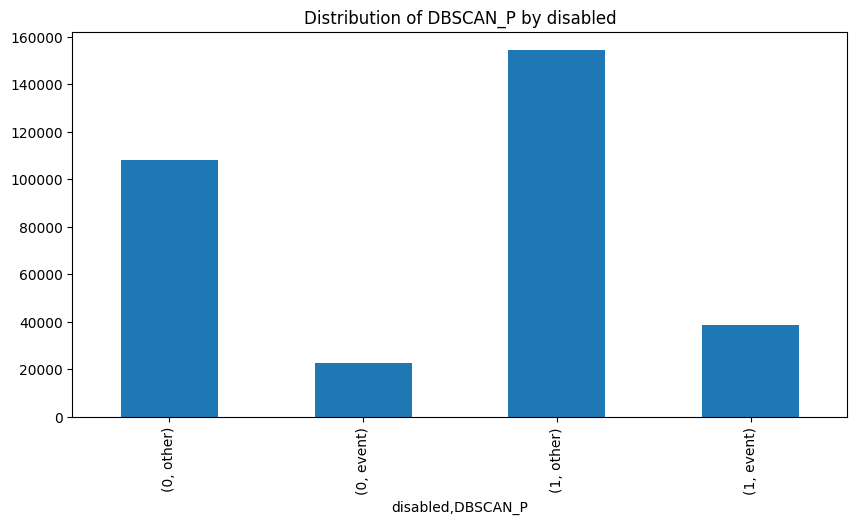

In [ ]:
get_grouped_data(DF_TOTAL, 'DBSCAN_P')

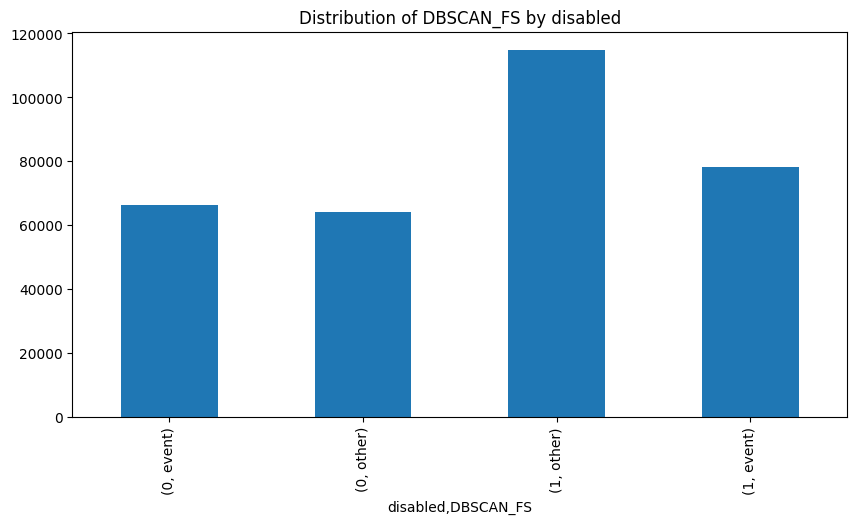

In [ ]:
get_grouped_data(DF_TOTAL, 'DBSCAN_FS')

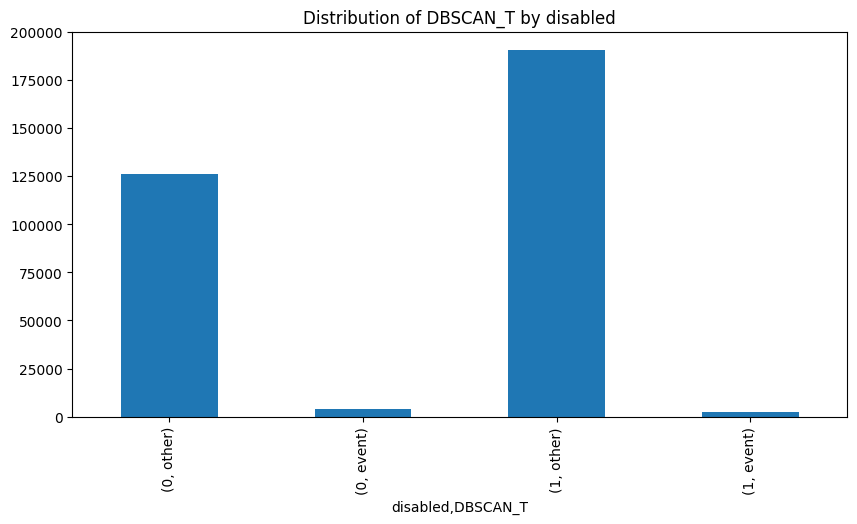

In [ ]:
get_grouped_data(DF_TOTAL, 'DBSCAN_T')

### Local Outlier Factor (LOF) - Саккады и фиксации с шумом, быстро

#### ДЛЯ всех ДАННЫХ

In [ ]:
df = DATA_SET.copy()
df = find_fixations_lof(df,
                        ['T', 'X_mean', 'Y_mean'],
                        contamination=0.2)

In [ ]:
df['LOF'] = df['LOF'].apply(lambda x: 'event' if x == -1 else 'other')
df[df['id_patient'] == ID_PATIENT]['LOF'].value_counts()

LOF
other    842
event    158
Name: count, dtype: int64

<ipython-input-125-f1ae6447cbc2>:14: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



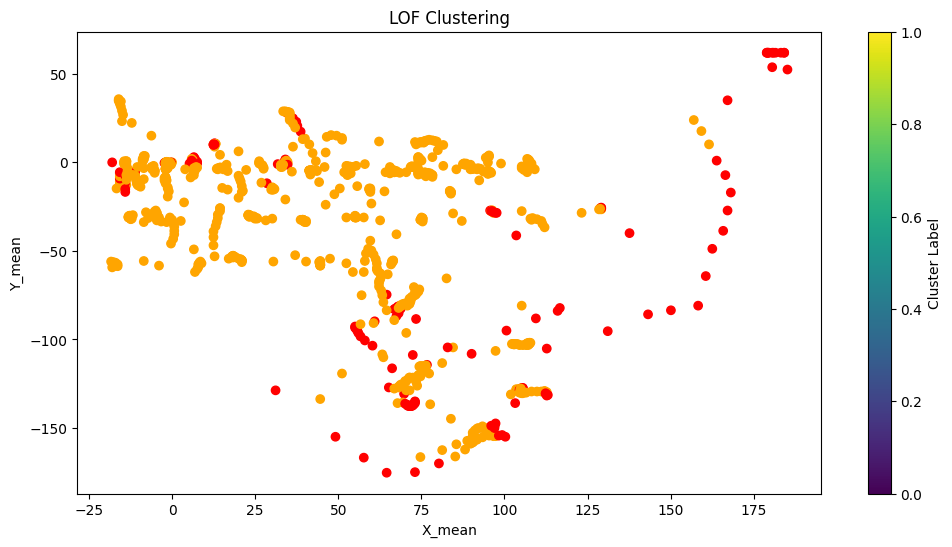

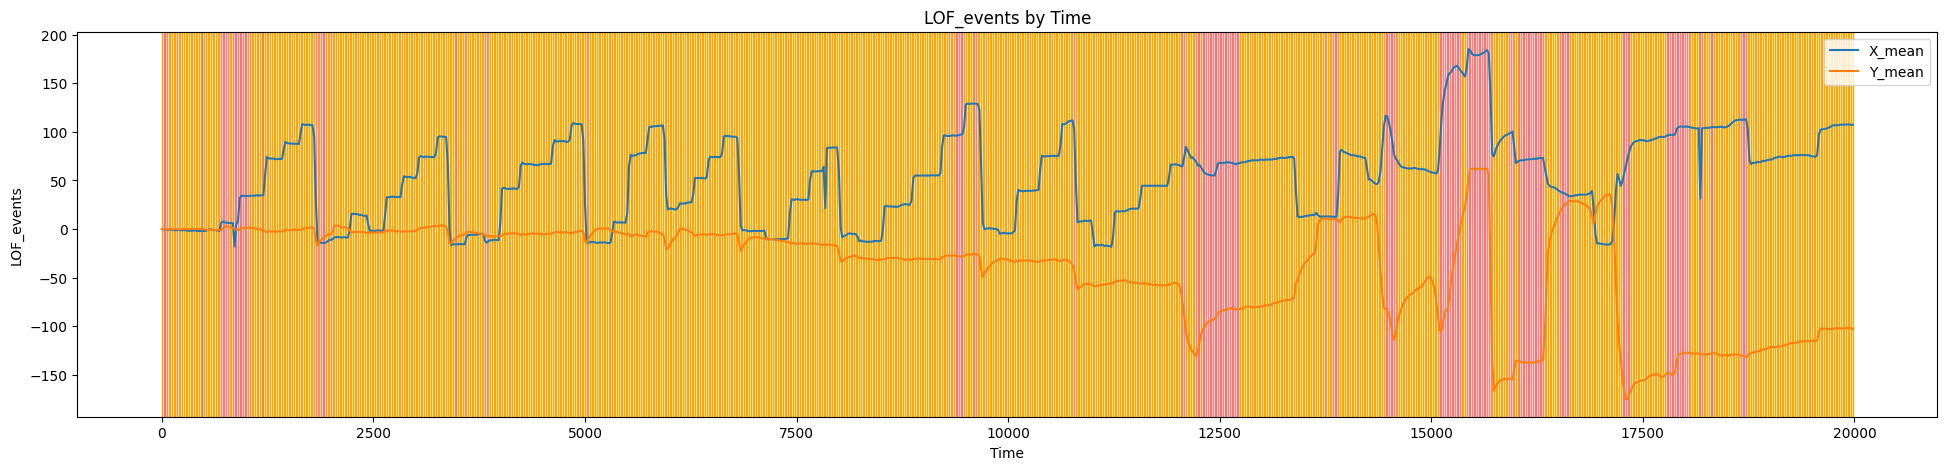

In [ ]:
plot_clusters(df[df['id_patient'] == ID_PATIENT], 'LOF', ['X_mean', 'Y_mean'])
plot_events(df[df['id_patient'] == ID_PATIENT], ['LOF'])
plotly_3d(df[df['id_patient'] == ID_PATIENT], ['T', 'X_mean', 'Y_mean'], 'LOF')

#### Ед. пац

In [ ]:
df_lof_solo = find_fixations_lof(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT],
                          ['T', 'X_mean', 'Y_mean'],
                          contamination=0.2) # 1, 2, 10, 60

<ipython-input-21-458047892f08>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_lof_solo['LOF'] = df_lof_solo['LOF'].apply(lambda x: 'saccade' if x == -1 else 'fixation')
df_lof_solo[df_lof_solo['id_patient'] == ID_PATIENT]['LOF'].value_counts()

LOF
fixation    1600
saccade      400
Name: count, dtype: int64

In [ ]:
plot_clusters(df_lof_solo[df_lof_solo['id_patient'] == ID_PATIENT], 'LOF', ['X_mean', 'Y_mean'])

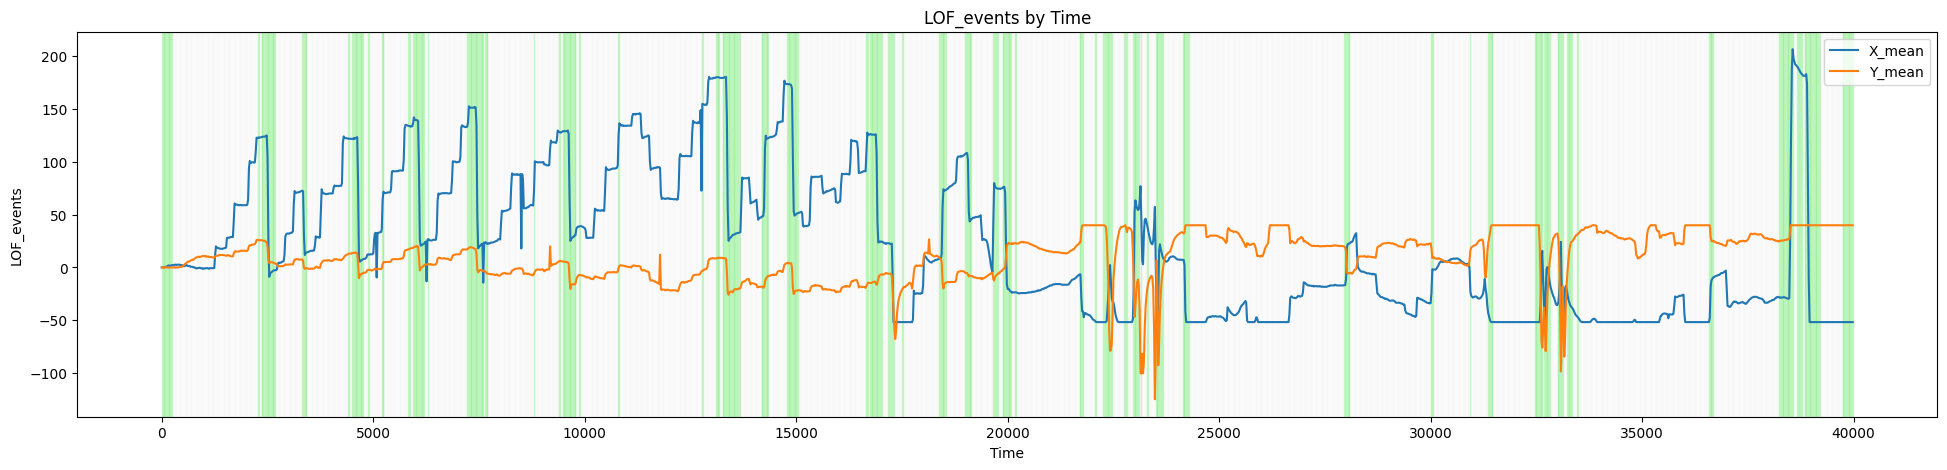

In [ ]:
plot_events(df_lof_solo[df_lof_solo['id_patient'] == ID_PATIENT], ['LOF'])

#### Общее

In [ ]:
DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: find_fixations_lof(group,
                                                                                          ['T', 'X_mean', 'Y_mean'],
                                                                                          contamination=0.2))
DF_TOTAL['LOF'] = DF_TOTAL['LOF'].apply(lambda x: 'event' if x == -1 else 'other')
DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_lof.csv', index=False)

100%|██████████| 185/185 [00:03<00:00, 53.58it/s]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_lof.csv')

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['LOF'].value_counts()

LOF
other    1200
event     300
Name: count, dtype: int64

<ipython-input-247-89838db643fc>:14: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



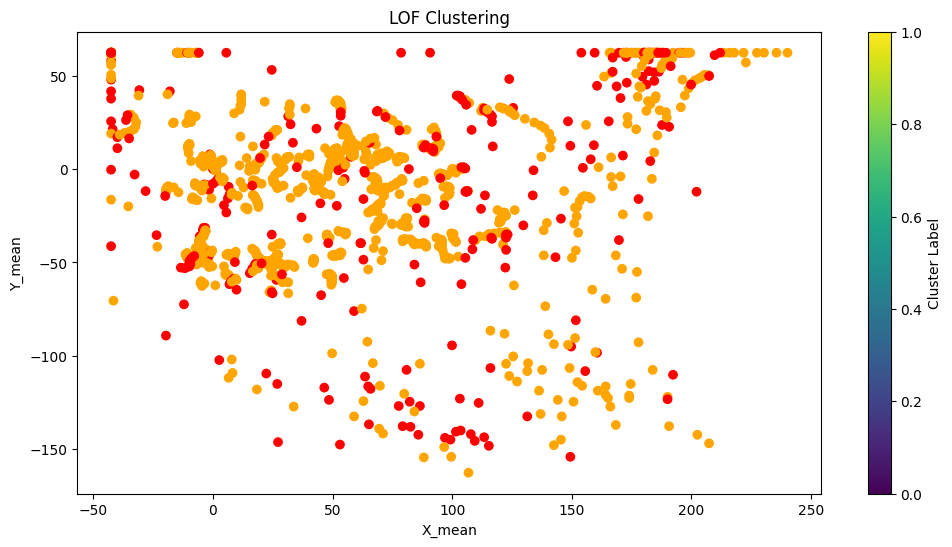

In [ ]:
plot_clusters(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], 'LOF', ['X_mean', 'Y_mean'])

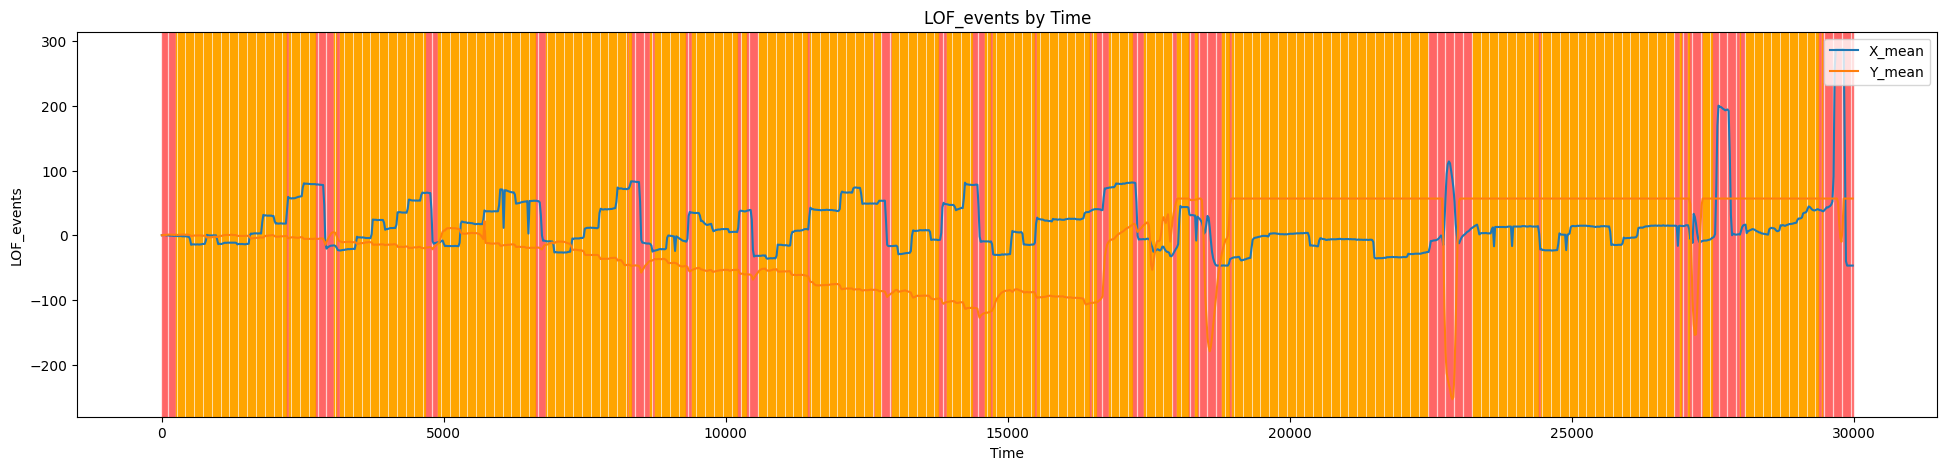

In [ ]:
plot_events(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['LOF'])

In [ ]:
DF_TOTAL.isna().sum()

T                    0
LX                   0
LY                   0
RX                   0
RY                   0
X_mean               0
Y_mean               0
id_patient           0
gender               0
disabled             0
velocity             0
IVT                  0
IDT                  0
X_mean_derivative    0
X_mean_sign          0
Y_mean_derivative    0
Y_mean_sign          0
NE_event             0
EN_event             0
MEAN_event           0
TRANS                0
DBSCAN_P             0
DBSCAN_FS            0
DBSCAN_T             0
HDBSCAN              0
LOF                  0
dtype: int64

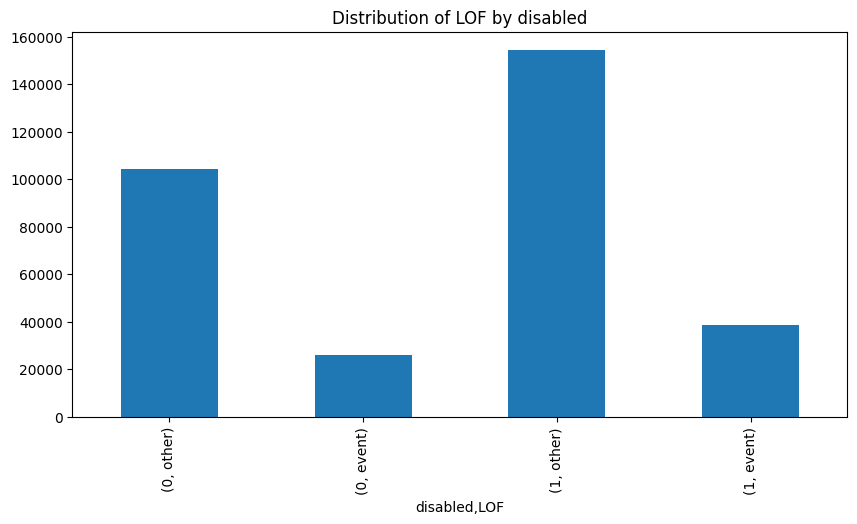

In [ ]:
get_grouped_data(DF_TOTAL, 'LOF')

### HDBSCAN

#### ОБЩИИЙЙ

In [ ]:
df = DATA_SET.copy()
df = find_fixations_hdbscan(df, ['T', 'X_mean', 'Y_mean'],
                             2, 2)

In [ ]:
df['HDBSCAN'] = df['HDBSCAN'].apply(lambda x: 'transition' if x == -1 else 'other')

<ipython-input-125-f1ae6447cbc2>:14: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



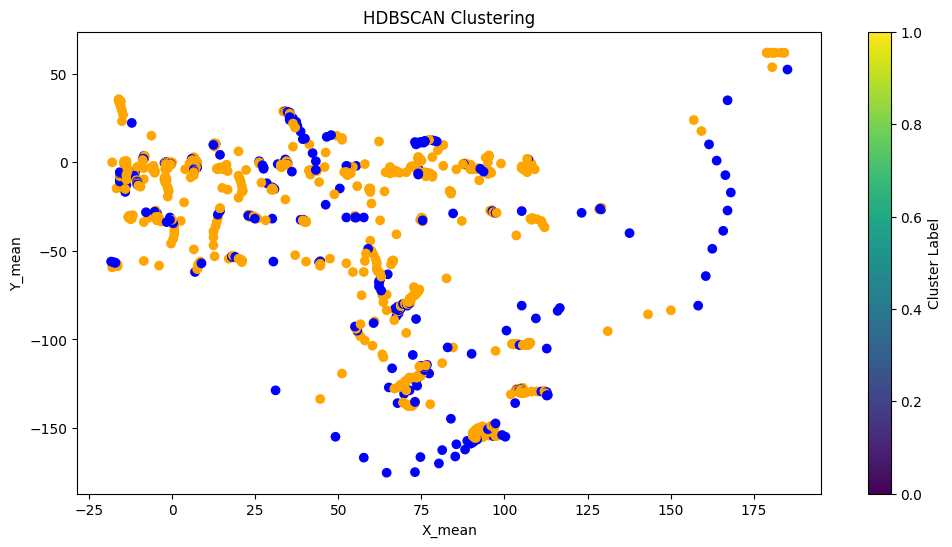

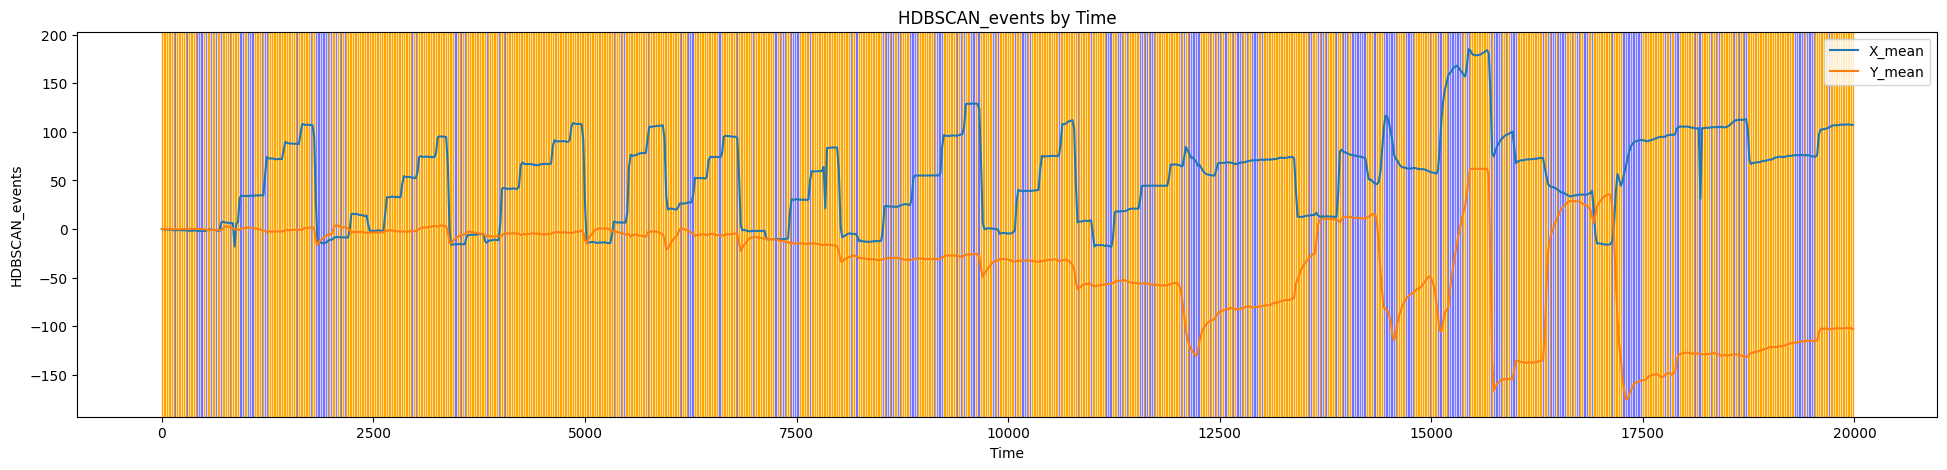

In [ ]:
plot_clusters(df[df['id_patient'] == ID_PATIENT], 'HDBSCAN', ['X_mean', 'Y_mean'])
plot_events(df[df['id_patient'] == ID_PATIENT], ['HDBSCAN'])
plotly_3d(df[df['id_patient'] == ID_PATIENT], ['T', 'X_mean', 'Y_mean'], 'HDBSCAN')

In [ ]:
df.groupby('disabled')['HDBSCAN'].value_counts()

disabled  HDBSCAN   
0         other          94243
          transition     36007
1         other         142685
          transition     50315
Name: count, dtype: int64

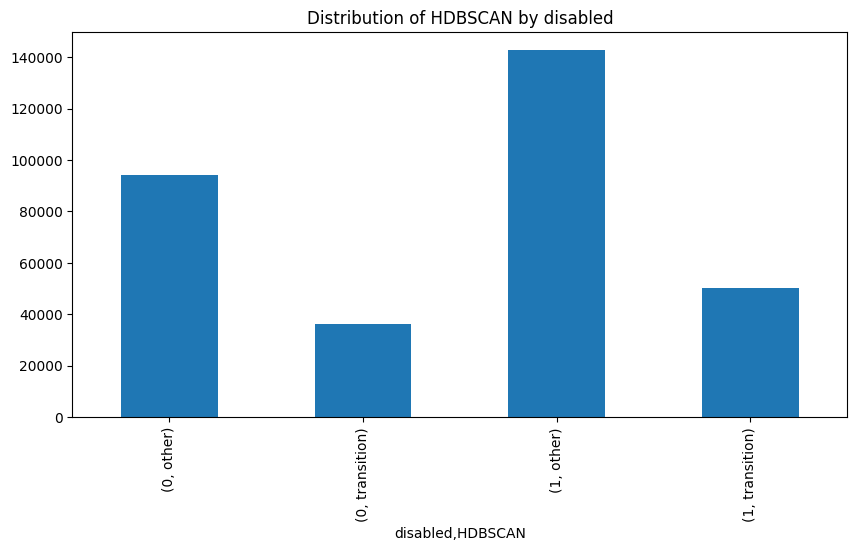

In [ ]:
get_grouped_data(df, 'HDBSCAN')

#### Ед. пац

In [ ]:
df_hdbscan_solo = find_fixations_hdbscan(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT],
                             ['T', 'X_mean', 'Y_mean'], # Без X
                             2, 2) # 2 - 3, 7, 8

<ipython-input-50-e55f8a034998>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#max_index = df_hdbscan_solo[df_hdbscan_solo['id_patient'] == ID_PATIENT]['HDBSCAN'].value_counts().idxmax()
df_hdbscan_solo['HDBSCAN'] = df_hdbscan_solo['HDBSCAN'].apply(lambda x: 'event' if x == -1 else 'other')
df_hdbscan_solo[df_hdbscan_solo['id_patient'] == ID_PATIENT]['HDBSCAN'].value_counts()

<ipython-input-1553-6c76e55546f5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



HDBSCAN
other    1467
event      33
Name: count, dtype: int64

<ipython-input-247-89838db643fc>:14: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



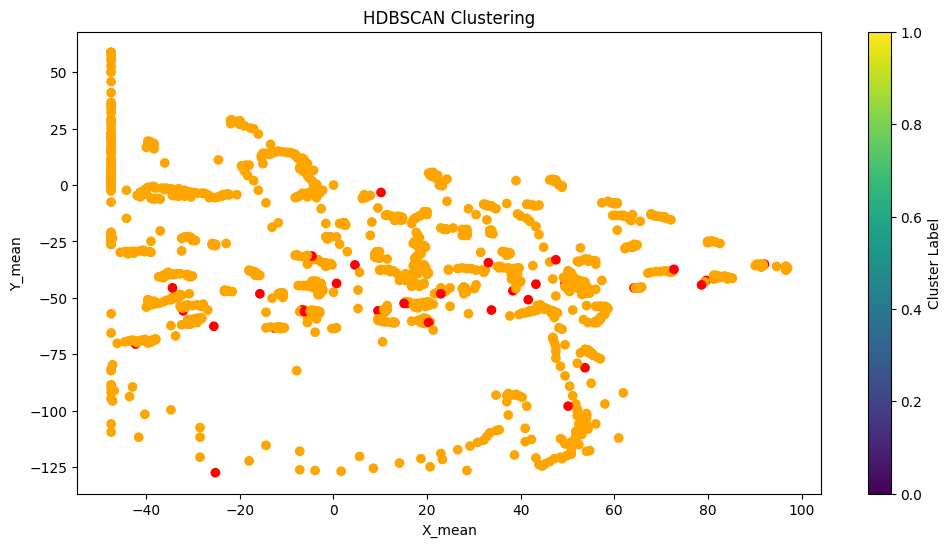

In [ ]:
plot_clusters(df_hdbscan_solo[df_hdbscan_solo['id_patient'] == ID_PATIENT], 'HDBSCAN', ['X_mean', 'Y_mean'])

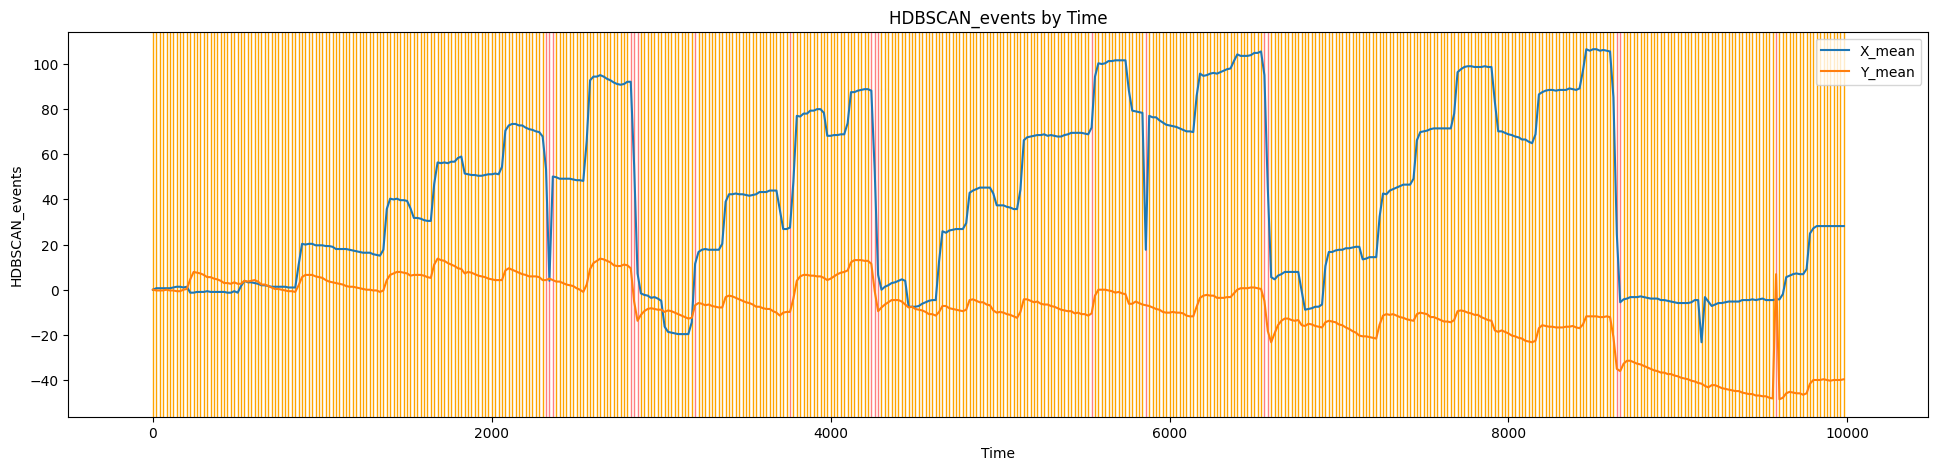

In [ ]:
plot_events(df_hdbscan_solo[df_hdbscan_solo['id_patient'] == ID_PATIENT][:500], ['HDBSCAN'])

In [ ]:
plotly_3d(df_hdbscan_solo[df_hdbscan_solo['id_patient'] == ID_PATIENT], ['T', 'X_mean', 'Y_mean'], 'HDBSCAN')

#### Общее

In [ ]:
DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: find_fixations_hdbscan(group,
                                                                                                ['T', 'X_mean', 'Y_mean'],
                                                                                                2, 2)) # 2 40 вносит смуту 3, 18
#max_index = df_hdbscan[df_hdbscan['id_patient'] == ID_PATIENT]['HDBSCAN'].value_counts().idxmax()
DF_TOTAL['HDBSCAN'] = DF_TOTAL['HDBSCAN'].apply(lambda x: 'event' if x == -1 else 'other')
DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_hdbscan.csv', index=False)

100%|██████████| 185/185 [00:25<00:00,  7.34it/s]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_hdbscan.csv')

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['HDBSCAN'].value_counts()

HDBSCAN
other    1467
event      33
Name: count, dtype: int64

<ipython-input-247-89838db643fc>:14: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



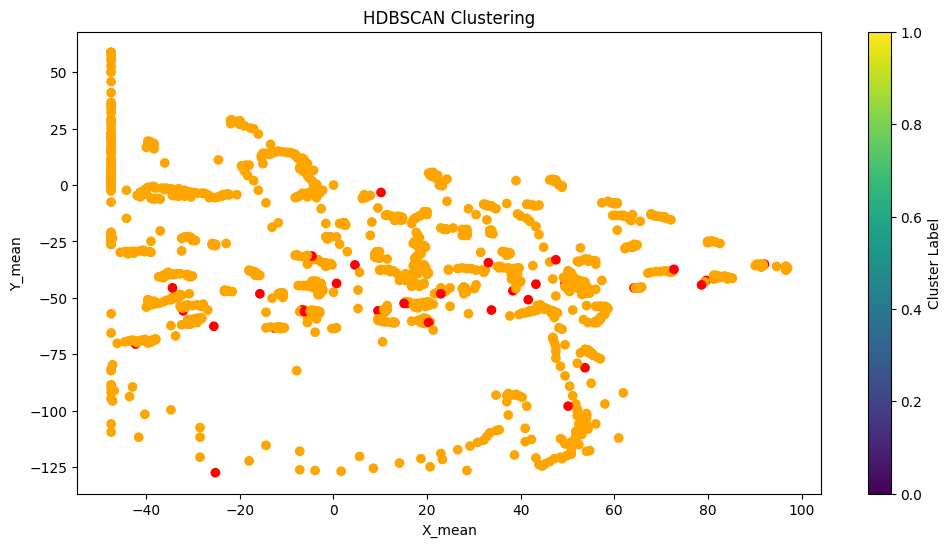

In [ ]:
plot_clusters(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], 'HDBSCAN', ['X_mean', 'Y_mean'])

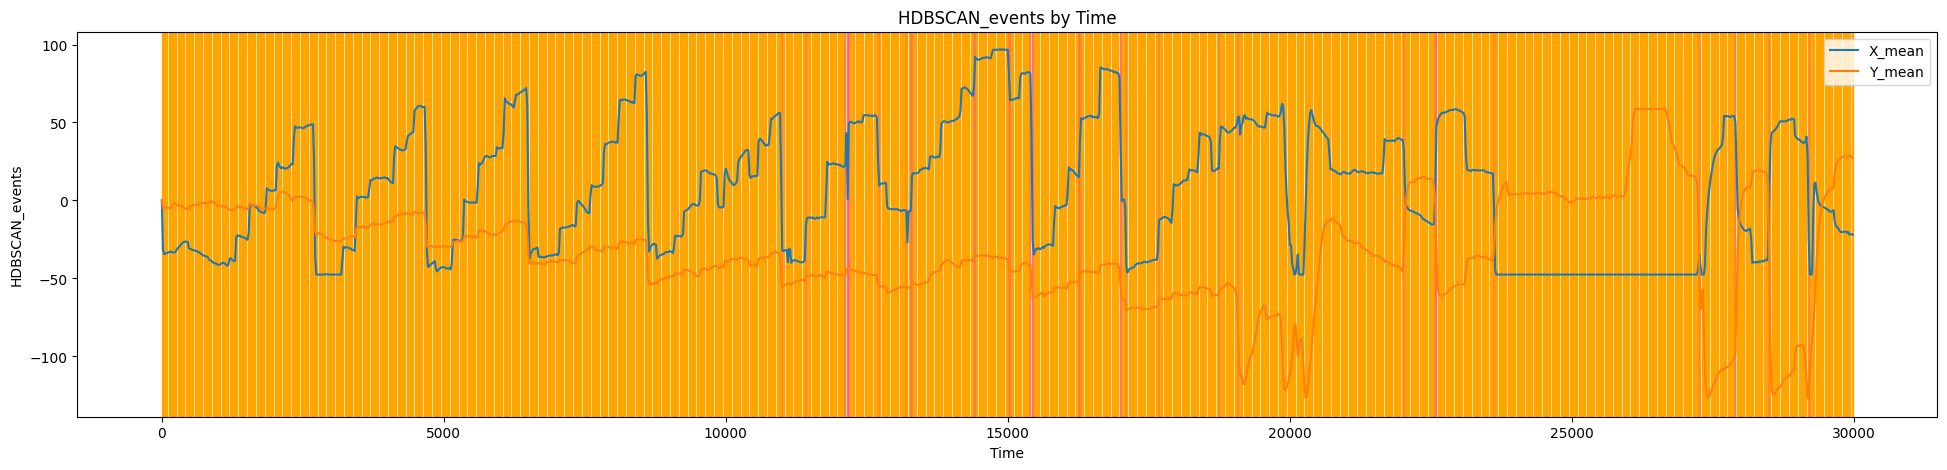

In [ ]:
plot_events(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['HDBSCAN'])

In [ ]:
plotly_3d(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['T', 'X_mean', 'Y_mean'], 'HDBSCAN')

In [ ]:
get_grouped_data(DF_TOTAL, 'HDBSCAN')

### Парафовеальное зрение

####СОЛО

In [ ]:
df_ff_solo = get_foveal_parafoveal(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT],
                                    window_size=10,
                                    radius_foveal=2,
                                    radius_parafoveal=10,
                                    radius_peripheral=60)


In [ ]:
df_ff_solo[df_ff_solo['id_patient'] == ID_PATIENT]['FV'].value_counts()

FV
parafoveal    680
other         650
peripheral    170
Name: count, dtype: int64

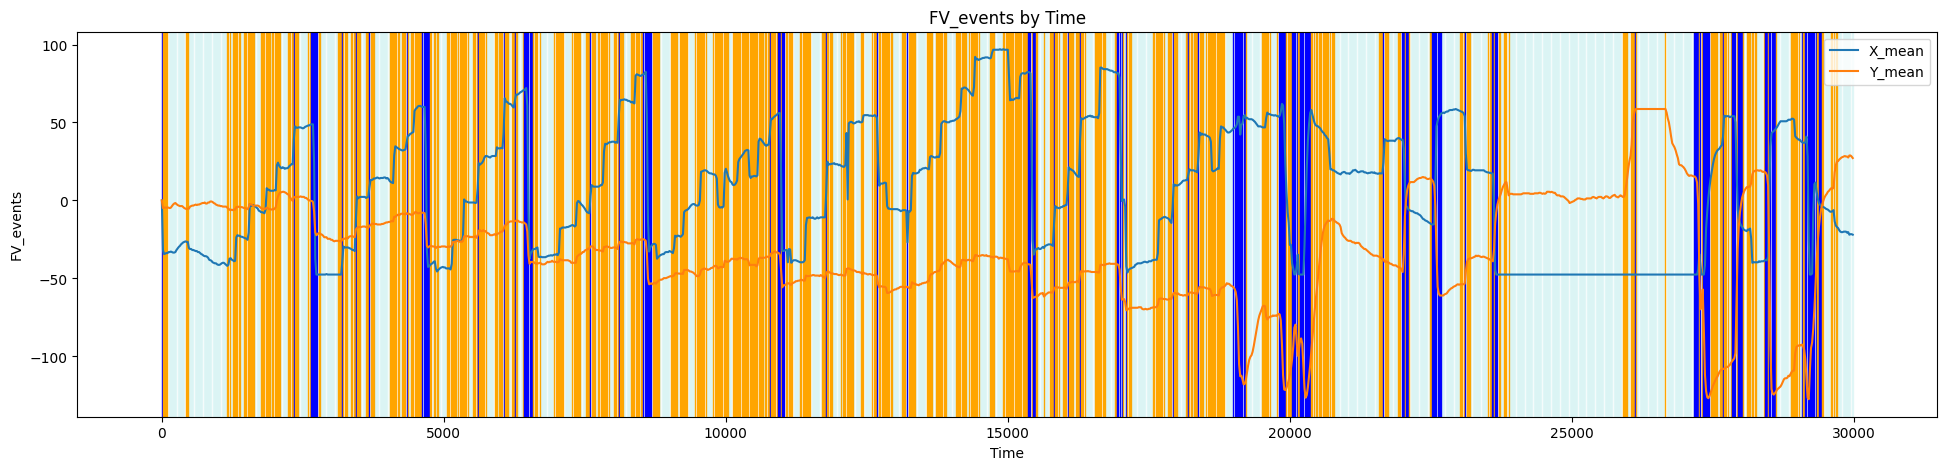

In [ ]:
plot_events(df_ff_solo[df_ff_solo['id_patient'] == ID_PATIENT], ['FV'])

#### Общее

In [ ]:
DF_TOTAL = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: get_foveal_parafoveal(group,
                                                                                        window_size=10,
                                                                                        radius_foveal=2,
                                                                                        radius_parafoveal=10,
                                                                                        radius_peripheral=60))

DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_ff.csv', index=False)

100%|██████████| 185/185 [08:33<00:00,  2.77s/it]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_ff.csv')

In [ ]:
DF_TOTAL

T        LX        LY        RX        RY     X_mean     Y_mean  \
0           0   0.00000   0.00000   0.00000   0.00000   0.000000   0.000000   
1          20   0.65535  -0.00001   0.65536  -0.65536   0.655355  -0.327685   
2          40   0.65534  -0.00001   0.65536  -0.65536   0.655350  -0.327685   
3          60   0.65534  -0.00001   0.65535  -0.65536   0.655345  -0.327685   
4          80   0.65534  -0.00001   0.65534   0.00000   0.655340  -0.000005   
...       ...       ...       ...       ...       ...        ...        ...   
323245  29900 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323246  29920 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323247  29940 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323248  29960 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323249  29980 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   

       id_patient  gender  disabled  ...            MEAN_event  TRANS  \
0          111GM3       0         0  ...                 other  other   
1          111GM3       0         0  ...  fixation_progressive  other   
2          111GM3       0         0  ...               unknown  other   
3          111GM3       0         0  ...  fixation_progressive  other   
4          111GM3       0         0  ...  fixation_progressive  other   
...           ...     ...       ...  ...                   ...    ...   
323245     831PA3       0         0  ...                 other  other   
323246     831PA3       0         0  ...                 other  other   
323247     831PA3       0         0  ...                 other  other   
323248     831PA3       0         0  ...                 other  other   
323249     831PA3       0         0  ...                 other  other   

       DBSCAN_P DBSCAN_FS  DBSCAN_T    LOF  HDBSCAN  X_mean_FV  Y_mean_FV  \
0         other     event     other  event    other   0.546121  -0.218457   
1         event     other     other  event    other   0.608534  -0.234061   
2         event     other     other  event    other   0.696304  -0.286724   
3         event     other     other  event    other   0.764568  -0.327684   
4         other     other     other  event    other   0.786412  -0.294916   
...         ...       ...       ...    ...      ...        ...        ...   
323245    event     other     other  event    other -48.825180  57.016930   
323246    event     other     other  event    other -48.825180  57.016930   
323247    event     other     other  event    other -48.825180  57.016930   
323248    event     other     other  event    other -48.825180  57.016930   
323249    event     other     other  event    other -48.825180  57.016930   

            FV  
0       foveal  
1       foveal  
2       foveal  
3       foveal  
4       foveal  
...        ...  
323245  foveal  
323246  foveal  
323247  foveal  
323248  foveal  
323249  foveal  

[323250 rows x 30 columns]

In [ ]:
DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT]['FV'].value_counts()

FV
parafoveal    680
other         650
peripheral    170
Name: count, dtype: int64

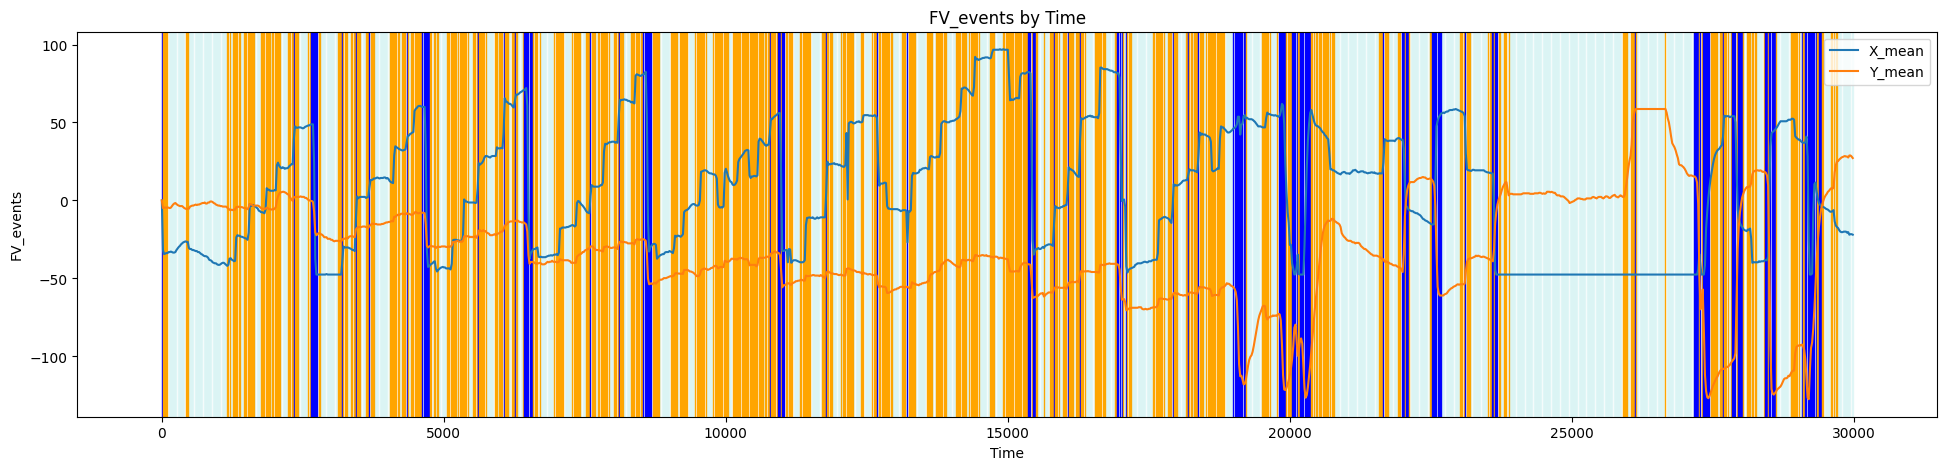

In [ ]:
plot_events(DF_TOTAL[DF_TOTAL['id_patient'] == ID_PATIENT], ['FV'])

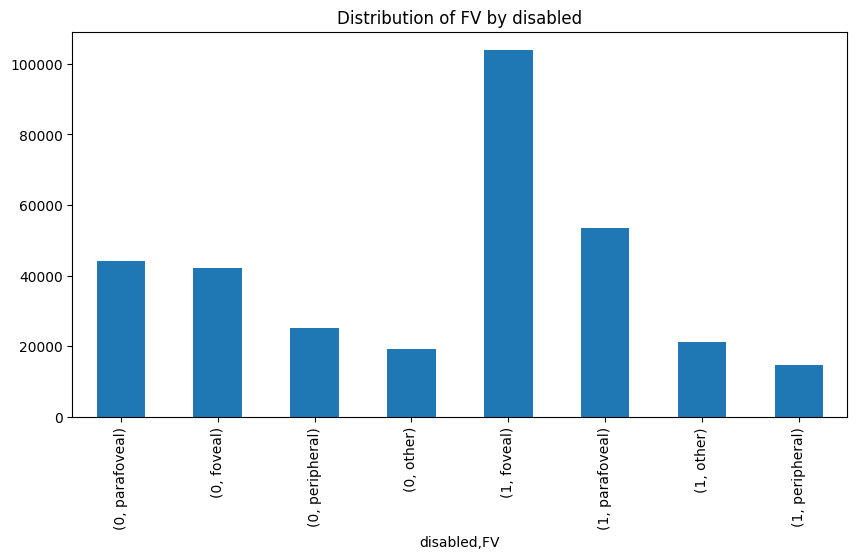

In [ ]:
get_grouped_data(DF_TOTAL, 'FV')

## Дополнительные методы


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_ff.csv')
DF_TOTAL['dispersion'] = DF_TOTAL.apply(lambda row: calculate_dispersion_eyes(row['LX'], row['LY'], row['RX'], row['RY']), axis=1)

In [ ]:
DF_TOTAL

T        LX        LY        RX        RY     X_mean     Y_mean  \
0           0   0.00000   0.00000   0.00000   0.00000   0.000000   0.000000   
1          20   0.65535  -0.00001   0.65536  -0.65536   0.655355  -0.327685   
2          40   0.65534  -0.00001   0.65536  -0.65536   0.655350  -0.327685   
3          60   0.65534  -0.00001   0.65535  -0.65536   0.655345  -0.327685   
4          80   0.65534  -0.00001   0.65534   0.00000   0.655340  -0.000005   
...       ...       ...       ...       ...       ...        ...        ...   
323245  29900 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323246  29920 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323247  29940 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323248  29960 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   
323249  29980 -49.15286  57.01693 -48.49750  57.01693 -48.825180  57.016930   

       id_patient  gender  disabled  ...  TRANS  DBSCAN_P DBSCAN_FS DBSCAN_T  \
0          111GM3       0         0  ...  other     other     event    other   
1          111GM3       0         0  ...  other     event     other    other   
2          111GM3       0         0  ...  other     event     other    other   
3          111GM3       0         0  ...  other     event     other    other   
4          111GM3       0         0  ...  other     other     other    other   
...           ...     ...       ...  ...    ...       ...       ...      ...   
323245     831PA3       0         0  ...  other     event     other    other   
323246     831PA3       0         0  ...  other     event     other    other   
323247     831PA3       0         0  ...  other     event     other    other   
323248     831PA3       0         0  ...  other     event     other    other   
323249     831PA3       0         0  ...  other     event     other    other   

          LOF  HDBSCAN  X_mean_FV  Y_mean_FV      FV    dispersion  
0       event    other   0.546121  -0.218457  foveal  0.000000e+00  
1       event    other   0.608534  -0.234061  foveal  4.294836e-01  
2       event    other   0.696304  -0.286724  foveal  4.294836e-01  
3       event    other   0.764568  -0.327684  foveal  4.294836e-01  
4       event    other   0.786412  -0.294916  foveal  1.000000e-10  
...       ...      ...        ...        ...     ...           ...  
323245  event    other -48.825180  57.016930  foveal  4.294967e-01  
323246  event    other -48.825180  57.016930  foveal  4.294967e-01  
323247  event    other -48.825180  57.016930  foveal  4.294967e-01  
323248  event    other -48.825180  57.016930  foveal  4.294967e-01  
323249  event    other -48.825180  57.016930  foveal  4.294967e-01  

[323250 rows x 31 columns]

## МАтематические алгоритмы

In [ ]:
DF_TOTAL= DATA_SET.groupby('id_patient').progress_apply(lambda group: add_math_features(group, [10]))

DF_TOTAL.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_math.csv', index=False)

100%|██████████| 185/185 [06:12<00:00,  2.01s/it]


In [ ]:
DF_TOTAL = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_math.csv')

# ОБРАБОТКА ДАННЫХ ИТОГОВОГО ДАТАСЕТА

## Датасеты

In [ ]:
prefixs = [
    'FV',
    'IVT',
    'IDT',
    'HDBSCAN',
    "LOF",
    'NE_event',
    'EN_event',
    'MEAN_event',
    'TRANS',
    'DBSCAN_P',
    'DBSCAN_FS',
    'DBSCAN_T',
    'HDBSCAN',
    'LOF'
    ]

df_grouped = DF_TOTAL.groupby('id_patient').progress_apply(lambda group: average_by_characteristics(group, prefixs))
#df_scaler = get_normalizer(df_grouped.fillna(0))
df_scaler = standardize(df_grouped)
df_scaler.isna().sum().sum()
df_scaler.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_scaler.csv', index=False)

100%|██████████| 185/185 [00:35<00:00,  5.26it/s]


In [ ]:
df_scaler = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_scaler.csv')

In [ ]:
df_scaler.describe()

T            LX            LY            RX            RY  \
count  1.850000e+02  1.850000e+02  1.850000e+02  1.850000e+02  1.850000e+02   
mean  -1.440289e-16 -9.601929e-18  2.160434e-17 -9.601929e-17 -6.481302e-17   
std    1.002714e+00  1.002714e+00  1.002714e+00  1.002714e+00  1.002714e+00   
min   -2.339652e+00 -3.250332e+00 -4.033706e+00 -3.226649e+00 -4.012010e+00   
25%   -7.742430e-01 -6.680885e-01 -6.222427e-01 -6.702408e-01 -6.261067e-01   
50%    7.911664e-01  6.700710e-02  1.531226e-01  5.500184e-02  1.432222e-01   
75%    7.911664e-01  6.421396e-01  6.167398e-01  6.291776e-01  6.148869e-01   
max    7.911664e-01  2.336555e+00  2.205214e+00  2.340408e+00  2.204471e+00   

             X_mean        Y_mean        lenght      velocity  \
count  1.850000e+02  1.850000e+02  1.850000e+02  1.850000e+02   
mean   9.601929e-17  1.488299e-16 -1.920386e-17  1.296260e-16   
std    1.002714e+00  1.002714e+00  1.002714e+00  1.002714e+00   
min   -3.239667e+00 -4.022998e+00 -2.339652e+00 -1.586622e+00   
25%   -6.694098e-01 -6.241973e-01 -7.742430e-01 -8.093336e-01   
50%    6.102317e-02  1.481764e-01  7.911664e-01 -9.521433e-02   
75%    6.378347e-01  6.158582e-01  7.911664e-01  5.831306e-01   
max    2.339337e+00  2.204921e+00  7.911664e-01  3.348961e+00   

       X_mean_derivative  ...  DBSCAN_FS_event_count  \
count       1.850000e+02  ...           1.850000e+02   
mean       -2.400482e-17  ...           2.088420e-16   
std         1.002714e+00  ...           1.002714e+00   
min        -1.440375e+00  ...          -2.651819e+00   
25%        -8.674562e-01  ...          -6.857623e-01   
50%        -7.737198e-02  ...          -8.117685e-02   
75%         5.134694e-01  ...           6.341723e-01   
max         3.701268e+00  ...           2.904829e+00   

       DBSCAN_FS_event_mean_duration  DBSCAN_FS_other_count  \
count                   1.850000e+02           1.850000e+02   
mean                    2.688540e-16          -1.296260e-16   
std                     1.002714e+00           1.002714e+00   
min                    -2.043793e+00          -1.888913e+00   
25%                    -8.200840e-01          -8.633688e-01   
50%                    -4.405554e-02          -7.823386e-02   
75%                     6.031869e-01           9.138359e-01   
max                     3.767884e+00           2.517581e+00   

       DBSCAN_FS_other_mean_duration  DBSCAN_T_other_count  \
count                   1.850000e+02          1.850000e+02   
mean                   -4.176839e-16         -7.681543e-17   
std                     1.002714e+00          1.002714e+00   
min                    -1.712447e+00         -2.359109e+00   
25%                    -7.852025e-01         -7.905232e-01   
50%                    -1.756515e-01          7.258783e-01   
75%                     4.940535e-01          8.302460e-01   
max                     5.121525e+00          8.732209e-01   

       DBSCAN_T_other_mean_duration  DBSCAN_T_event_count  \
count                  1.850000e+02          1.850000e+02   
mean                   5.761157e-17         -2.400482e-17   
std                    1.002714e+00          1.002714e+00   
min                   -1.017299e+00         -1.320326e+00   
25%                   -6.573738e-01         -7.800190e-01   
50%                   -3.578511e-01         -1.981500e-01   
75%                    3.332543e-01          5.915294e-01   
max                    5.352686e+00          5.163357e+00   

       DBSCAN_T_event_mean_duration      gender    disabled  
count                  1.850000e+02  185.000000  185.000000  
mean                   3.072617e-16    0.216216    0.524324  
std                    1.002714e+00    0.412781    0.500763  
min                   -1.190217e+00    0.000000    0.000000  
25%                   -7.928443e-01    0.000000    0.000000  
50%                   -2.310411e-01    0.000000    1.000000  
75%                    6.352149e-01    0.000000    1.000000  
max                    3.374477e+00    1.0

In [ ]:
# @title Поиск Nana
#df_idt_mod[df_idt_mod.isna().any(axis=1)][df_idt_mod['id_patient'] == ID_PATIENT][:50]
df_scaler.drop(columns=['T',
                        'LX',
                        'LY',
                        'RX',
                        'RY',	'X_mean',
                        'Y_mean',
                        'velocity',
                        'X_mean_derivative',
                        'X_mean_sign',
                        'Y_mean_derivative',
                        'Y_mean_sign',
                        'IVT_fixation_count',
                        'IVT_fixation_mean_duration',
                        'IVT_saccade_count',
                        'IVT_saccade_mean_duration',
                        'IDT_fixation_count',
                        'IDT_fixation_mean_duration',
                        'IDT_saccade_count',
                        'IDT_saccade_mean_duration',
                        'NE_event_fixation_regressive_count',
                        'NE_event_fixation_regressive_mean_duration',
                        'NE_event_fixation_progressive_count',
                        'NE_event_fixation_progressive_mean_duration',
                        'NE_event_saccade_progressive_count',
                        'NE_event_saccade_progressive_mean_duration',
                        'NE_event_saccade_regressive_count',
                        'NE_event_saccade_regressive_mean_duration',
                        'NE_event_other_count',
                        'NE_event_other_mean_duration',
                        'EN_event_fixation_progressive_count',
                        'EN_event_fixation_progressive_mean_duration',
                        'EN_event_saccade_regressive_count',
                        'EN_event_saccade_regressive_mean_duration',
                        'EN_event_saccade_progressive_count',
                        'EN_event_saccade_progressive_mean_duration',
                        'EN_event_fixation_regressive_count',
                        'EN_event_fixation_regressive_mean_duration',
                        'EN_event_other_count',
                        'EN_event_other_mean_duration',
                        'MEAN_event_unknown_count',
                        'MEAN_event_unknown_mean_duration',
                        'MEAN_event_fixation_progressive_count',
                        'MEAN_event_fixation_progressive_mean_duration',
                        'TRANS_other_count',
                        'TRANS_other_mean_duration',
                       # 'TRANS_event_count',
                       # 'TRANS_event_mean_duration',
                        #'HDBSCAN_other_count',
                        #'HDBSCAN_other_mean_duration',
                        #'HDBSCAN_transition_count',
                        #'HDBSCAN_transition_mean_duration',
                        'gender',
                        'disabled',
                        'LOF_other_count',
                        'LOF_other_mean_duration',
                        'LOF_event_count',
                        'LOF_event_mean_duration'])[df_scaler.isna().any(axis=1)]

Empty DataFrame
Columns: [lenght, X_mean_FV, Y_mean_FV, FV_parafoveal_count, FV_parafoveal_mean_duration, FV_peripheral_count, FV_peripheral_mean_duration, FV_foveal_count, FV_foveal_mean_duration, FV_other_count, FV_other_mean_duration, HDBSCAN_other_count, HDBSCAN_other_mean_duration, HDBSCAN_event_count, HDBSCAN_event_mean_duration, MEAN_event_saccade_progressive_count, MEAN_event_saccade_progressive_mean_duration, MEAN_event_other_count, MEAN_event_other_mean_duration, TRANS_event_count, TRANS_event_mean_duration, DBSCAN_P_other_count, DBSCAN_P_other_mean_duration, DBSCAN_P_event_count, DBSCAN_P_event_mean_duration, DBSCAN_FS_event_count, DBSCAN_FS_event_mean_duration, DBSCAN_FS_other_count, DBSCAN_FS_other_mean_duration, DBSCAN_T_other_count, DBSCAN_T_other_mean_duration, DBSCAN_T_event_count, DBSCAN_T_event_mean_duration, id_patient]
Index: []

[0 rows x 34 columns]

In [ ]:
df_scaler = df_scaler.fillna(0)
df_scaler.to_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/{df_name}_scaler.csv', index=False)

### ОТНОШЕНИЕ КОЛИЧЕСТВА СОБЫТИЙ К ДЛИТЕЛЬНОСТИ

In [ ]:
#df_scaler.to_csv('/content/drive/MyDrive/lectures/diplom/df_general/relative_scaler.csv', index=False)
df_scaler = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/relative_scaler.csv')
df_scaler

T        LX        LY        RX        RY    X_mean    Y_mean  \
0   -0.774243  0.799654  0.538475  0.791752  0.533619  0.795992  0.536065   
1    0.791166 -0.489176 -0.116257 -0.470127 -0.114037 -0.479821 -0.115151   
2    0.791166  0.810084 -0.211923  0.807676 -0.235742  0.809175 -0.223843   
3    0.791166  1.816849 -1.035145  1.837227 -1.040930  1.827712 -1.038075   
4    0.791166  1.881550 -0.213278  1.880161 -0.200378  1.881542 -0.206833   
..        ...       ...       ...       ...       ...       ...       ...   
180  0.791166 -0.207749 -0.006129 -0.208975 -0.021341 -0.208439 -0.013737   
181  0.791166  0.592727 -0.490197  0.584908 -0.493949  0.589030 -0.492091   
182  0.791166  0.046730  0.616786  0.044296  0.614887  0.045529  0.615858   
183  0.791166  0.422587 -0.994646  0.414902 -0.981417  0.418895 -0.988065   
184 -0.774243 -1.003712  1.366987 -0.987387  1.368735 -0.995909  1.367910   

       lenght  velocity  X_mean_derivative  ...  \
0   -0.774243  2.714769           0.144826  ...   
1    0.791166  0.207863          -0.958480  ...   
2    0.791166  0.588661          -1.025469  ...   
3    0.791166  1.019488          -0.841693  ...   
4    0.791166 -0.809567           0.391519  ...   
..        ...       ...                ...  ...   
180  0.791166 -0.711391           0.671484  ...   
181  0.791166  0.372330          -0.881195  ...   
182  0.791166 -0.707498           0.111559  ...   
183  0.791166 -0.037575           0.365764  ...   
184 -0.774243 -0.275062          -1.144555  ...   

     DBSCAN_FS_event_mean_duration  DBSCAN_FS_other_count  \
0                         0.583445              -1.105488   
1                         0.725728              -0.961768   
2                         0.242145              -0.325099   
3                        -0.018424              -0.345247   
4                        -1.262020               0.823321   
..                             ...                    ...   
180                      -1.170384               0.952267   
181                       0.423143              -0.687759   
182                      -0.044056              -0.498370   
183                       0.268588              -0.059149   
184                      -0.227879               0.243067   

     DBSCAN_FS_other_mean_duration  DBSCAN_T_other_count  \
0                        -1.105072             -3.642757   
1                        -0.849764             -0.108278   
2                        -0.291147             -0.330505   
3                        -0.578193             -0.933695   
4                        -0.364511              0.907621   
..                             ...                   ...   
180                       0.041756              0.780634   
181                      -0.696827              0.082203   
182                      -0.833061              0.844127   
183                       0.223682             -0.013037   
184                       0.138185              0.293849   

     DBSCAN_T_other_mean_duration  DBSCAN_T_event_count  \
0                       -1.017299              3.642757   
1                       -0.320123              0.108278   
2                       -0.536201              0.330505   
3                       -0.788120              0.933695   
4                        0.445615             -0.907621   
..                            ...                   ...   
180                      0.069954             -0.780634   
181                     -0.506104             -0.082203   
182                      0.333254             -0.844127   
183                     -0.422733              0.013037   
184                     -0.338901             -0.293849   

     DBSCAN_T_event_mean_duration  id_patient  gender  disabled  
0                        1.498673      111GM3     0.0       0.0  
1                        1.146336      111JA2     1.0       1.0  
2                        0.635215      111RP1     0.0       1.0  
3                        0.289363      112JU3  

### COUNT DATASET

In [ ]:
df_scaler = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/count_scaler.csv')
df_scaler

T        LX        LY        RX        RY    X_mean    Y_mean  \
0   -0.774243  0.799654  0.538475  0.791752  0.533619  0.795992  0.536065   
1    0.791166 -0.489176 -0.116257 -0.470127 -0.114037 -0.479821 -0.115151   
2    0.791166  0.810084 -0.211923  0.807676 -0.235742  0.809175 -0.223843   
3    0.791166  1.816849 -1.035145  1.837227 -1.040930  1.827712 -1.038075   
4    0.791166  1.881550 -0.213278  1.880161 -0.200378  1.881542 -0.206833   
..        ...       ...       ...       ...       ...       ...       ...   
180  0.791166 -0.207749 -0.006129 -0.208975 -0.021341 -0.208439 -0.013737   
181  0.791166  0.592727 -0.490197  0.584908 -0.493949  0.589030 -0.492091   
182  0.791166  0.046730  0.616786  0.044296  0.614887  0.045529  0.615858   
183  0.791166  0.422587 -0.994646  0.414902 -0.981417  0.418895 -0.988065   
184 -0.774243 -1.003712  1.366987 -0.987387  1.368735 -0.995909  1.367910   

       lenght  velocity  X_mean_derivative  ...  \
0   -0.774243  2.714769           0.144826  ...   
1    0.791166  0.207863          -0.958480  ...   
2    0.791166  0.588661          -1.025469  ...   
3    0.791166  1.019488          -0.841693  ...   
4    0.791166 -0.809567           0.391519  ...   
..        ...       ...                ...  ...   
180  0.791166 -0.711391           0.671484  ...   
181  0.791166  0.372330          -0.881195  ...   
182  0.791166 -0.707498           0.111559  ...   
183  0.791166 -0.037575           0.365764  ...   
184 -0.774243 -0.275062          -1.144555  ...   

     DBSCAN_FS_event_mean_duration  DBSCAN_FS_other_count  \
0                         0.583445              -1.085519   
1                         0.725728              -0.358204   
2                         0.242145               0.122615   
3                        -0.018424               0.107399   
4                        -1.262020               0.989915   
..                             ...                    ...   
180                      -1.170384               1.087296   
181                       0.423143              -0.151270   
182                      -0.044056              -0.008241   
183                       0.268588               0.323463   
184                      -0.227879              -0.321687   

     DBSCAN_FS_other_mean_duration  DBSCAN_T_other_count  \
0                        -1.105072             -1.014607   
1                        -0.849764              0.741226   
2                        -0.291147              0.719739   
3                        -0.578193              0.661416   
4                        -0.364511              0.839455   
..                             ...                   ...   
180                       0.041756              0.827176   
181                      -0.696827              0.759644   
182                      -0.833061              0.833316   
183                       0.223682              0.750435   
184                       0.138185             -0.729130   

     DBSCAN_T_other_mean_duration  DBSCAN_T_event_count  \
0                       -1.017299              3.459312   
1                       -0.320123              0.466843   
2                       -0.536201              0.757778   
3                       -0.788120              1.547457   
4                        0.445615             -0.863143   
..                            ...                   ...   
180                      0.069954             -0.696895   
181                     -0.506104              0.217471   
182                      0.333254             -0.780019   
183                     -0.422733              0.342157   
184                     -0.338901             -0.405960   

     DBSCAN_T_event_mean_duration  id_patient  gender  disabled  
0                        1.498673      111GM3     0.0       0.0  
1                        1.146336      111JA2     1.0       1.0  
2                        0.635215      111RP1     0.0       1.0  
3                        0.289363      112JU3  

### COUNT DATASET c MATH

In [ ]:
df_scaler = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/math_scaler.csv')
df_scaler

T        LX        LY        RX        RY    X_mean    Y_mean  \
0   -0.774243  0.799654  0.538475  0.791752  0.533619  0.795992  0.536065   
1    0.791166 -0.489176 -0.116257 -0.470127 -0.114037 -0.479821 -0.115151   
2    0.791166  0.810084 -0.211923  0.807676 -0.235742  0.809175 -0.223843   
3    0.791166  1.816849 -1.035145  1.837227 -1.040930  1.827712 -1.038075   
4    0.791166  1.881550 -0.213278  1.880161 -0.200378  1.881542 -0.206833   
..        ...       ...       ...       ...       ...       ...       ...   
180  0.791166 -0.207749 -0.006129 -0.208975 -0.021341 -0.208439 -0.013737   
181  0.791166  0.592727 -0.490197  0.584908 -0.493949  0.589030 -0.492091   
182  0.791166  0.046730  0.616786  0.044296  0.614887  0.045529  0.615858   
183  0.791166  0.422587 -0.994646  0.414902 -0.981417  0.418895 -0.988065   
184 -0.774243 -1.003712  1.366987 -0.987387  1.368735 -0.995909  1.367910   

       lenght  velocity  X_mean_derivative  ...  \
0   -0.774243  2.714769           0.144826  ...   
1    0.791166  0.207863          -0.958480  ...   
2    0.791166  0.588661          -1.025469  ...   
3    0.791166  1.019488          -0.841693  ...   
4    0.791166 -0.809567           0.391519  ...   
..        ...       ...                ...  ...   
180  0.791166 -0.711391           0.671484  ...   
181  0.791166  0.372330          -0.881195  ...   
182  0.791166 -0.707498           0.111559  ...   
183  0.791166 -0.037575           0.365764  ...   
184 -0.774243 -0.275062          -1.144555  ...   

     DBSCAN_FS_event_mean_duration  DBSCAN_FS_other_count  \
0                         0.583445              -1.085519   
1                         0.725728              -0.358204   
2                         0.242145               0.122615   
3                        -0.018424               0.107399   
4                        -1.262020               0.989915   
..                             ...                    ...   
180                      -1.170384               1.087296   
181                       0.423143              -0.151270   
182                      -0.044056              -0.008241   
183                       0.268588               0.323463   
184                      -0.227879              -0.321687   

     DBSCAN_FS_other_mean_duration  DBSCAN_T_other_count  \
0                        -1.105072             -1.014607   
1                        -0.849764              0.741226   
2                        -0.291147              0.719739   
3                        -0.578193              0.661416   
4                        -0.364511              0.839455   
..                             ...                   ...   
180                       0.041756              0.827176   
181                      -0.696827              0.759644   
182                      -0.833061              0.833316   
183                       0.223682              0.750435   
184                       0.138185             -0.729130   

     DBSCAN_T_other_mean_duration  DBSCAN_T_event_count  \
0                       -1.017299              3.459312   
1                       -0.320123              0.466843   
2                       -0.536201              0.757778   
3                       -0.788120              1.547457   
4                        0.445615             -0.863143   
..                            ...                   ...   
180                      0.069954             -0.696895   
181                     -0.506104              0.217471   
182                      0.333254             -0.780019   
183                     -0.422733              0.342157   
184                     -0.338901             -0.405960   

     DBSCAN_T_event_mean_duration  id_patient  gender  disabled  
0                        1.498673      111GM3     0.0       0.0  
1                        1.146336      111JA2     1.0       1.0  
2                        0.635215      111RP1     0.0       1.0  
3                        0.289363      112JU3  

## Фичи

In [ ]:
drop_columns = [
    'T',
    #'LX',
    #'LY',
    #'RX',
    #'RY',
   # 'X_mean',
   # 'Y_mean',
    #'velocity',
  #  'IVT_fixation_count',
   # 'IVT_fixation_mean_duration',
   # 'IVT_saccade_count',
   # 'IVT_saccade_mean_duration',
   # 'IDT_fixation_count',
#    'IDT_fixation_mean_duration',
 #   'IDT_saccade_count',
#    'IDT_saccade_mean_duration',
    'id_patient',
#    'gender',
 #   'lenght',
    'disabled'
    ]

# Классификация с отбором

In [ ]:
# @title Классификация
def svm_rfe_feature_selection(model, X_train, y_train, n_features):
    """
    Выполнить отбор признаков с помощью рекурсивного исключения признаков (RFE) с SVM.

    Параметры:
    - model: Модель SVM для отбора признаков.
    - X_train: Тренировочные данные.
    - y_train: Метки тренировочных данных.
    - n_features: Количество признаков для отбора.

    Возвращает:
    - selected_features: Булевый массив, указывающий, какие признаки были отобраны.
    """

    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected_features = rfe.support_
    return selected_features

def evaluate_classifier(model, X_train, y_train, X_test, y_test):
    """
    Оценить производительность классификатора.

    Параметры:
    - model: Модель классификатора для оценки.
    - X_train: Тренировочные данные.
    - y_train: Метки тренировочных данных.
    - X_test: Тестовые данные.
    - y_test: Метки тестовых данных.

    Возвращает:
    - accuracy: Точность классификатора.
    - sensitivity: Чувствительность классификатора.
    - specificity: Специфичность классификатора.
    - confusion_matrix: Матрица ошибок классификатора.
    """

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return accuracy, sensitivity, specificity, confusion_matrix(y_test, y_pred)

def perform_cross_validation(model, X, y, feature_selection_method, n_features, n_splits, n_repeats, results, progress_bar):
    """
    Выполнить кросс-валидацию с отбором признаков.

    Параметры:
    - model: Модель классификатора для использования.
    - X: Данные.
    - y: Метки.
    - feature_selection_method: Метод отбора признаков для использования.
    - n_features: Количество признаков для отбора.
    - n_splits: Количество折ок для кросс-валидации.
    - n_repeats: Количество повторений кросс-валидации.
    - results: Список для хранения результатов.
    - progress_bar: Индикатор прогресса.

    Возвращает:
    - None
    """

    selected_features = []
    accuracies = []
    sensitivities = []
    specificities = []
    confusion_matrices = []
######
    for i in range(n_features):
      #######
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=i)

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            selected_feature_indices = feature_selection_method(model, X_train, y_train, n_features)
            selected_features_names = [feature_names[i] for i in range(len(feature_names)) if selected_feature_indices[i]]

            X_train_selected = X_train.iloc[:, selected_feature_indices]
            X_test_selected = X_test.iloc[:, selected_feature_indices]

            (accuracy, sensitivity, specificity, confusion_matrix) = evaluate_classifier(model, X_train_selected, y_train, X_test_selected, y_test)

            result = {
                "n_feature": n_features,
                "selected_features": ', '.join(selected_features_names),
                "accuracy": accuracy,
                "sensitivity": sensitivity,
                "specificity": specificity,
                "confusion_matrices": confusion_matrix,
            }
            results.append(result)

            progress_bar.update(1)

def start_testing(model, num_feature, n_splits, n_repeats, output_path):
    """
    Начать тестирование с кросс-валидацией и отбором признаков.

    Параметры:
    - model: Модель классификатора для использования.
    - num_feature: Максимальное количество признаков для отбора.
    - n_splits: Количество фолдов
    - n_repeats: количество повторов
    - output_path: путь для сохранения набора данных в формате .csv

    Возвращает:
    - results_df: набор данных с результатами
    """
    total_iterations = (num_feature*(num_feature+1)/2) * n_splits# * n_repeats
    progress_bar = tqdm(total=total_iterations, desc="Progress", position=0, leave=False, file=sys.stdout)

    results = []

    for n_feature in range(num_feature, 0, -1):
        perform_cross_validation(model, X, y, svm_rfe_feature_selection, n_feature, n_splits, n_repeats, results, progress_bar)

    progress_bar.close()

    results_df = pd.DataFrame(results)

    if output_path:
        results_df.to_csv(output_path, index=False)
        print("Results saved to:", output_path)

    return results_df

X = df_scaler.drop(columns=drop_columns)
y = df_scaler['disabled']
feature_names = df_scaler.drop(columns=drop_columns).columns

model = LogisticRegression()

num_feature = 30
n_splits = 10
n_repeats = 100

output_path = "/content/drive/MyDrive/lectures/diplom/df_general/results_LG_quantitative_sequence_30_math.csv"
results_df = start_testing(model, num_feature, n_splits, n_repeats, output_path)

Progress: 100%|█████████▉| 4634/4650.0 [2:50:03<00:31,  1.97s/it]

In [ ]:
def get_result_total(data):
    """
    Рассчитывает и суммирует результаты экспериментов по отбору признаков.

    Параметры:
    data (pandas.DataFrame): DataFrame, содержащий результаты экспериментов по отбору признаков.

    Возвращает:
    pandas.DataFrame: DataFrame, суммирующий результаты, включая количество признаков, уникальные признаки, выбранные признаки, относительный размер группы, биномиальную вероятность, точность, чувствительность, специфичность и матрицу конфузии.

    Примечания:
    Функция предполагает, что входной DataFrame имеет следующие столбцы: "n_feature", "selected_features", "accuracy", "sensitivity", "specificity" и "confusion_matrices".
    """
    def binomial_probability(n, k, f, g):
        """
        Вычисляет вероятность биномиального распределения.

        Параметры
        ---------
        n : int
            Общее количество испытаний.
        k : int
            Количество успешных испытаний.
        f : int
            Количество успешных испытаний в аналогичном наборе данных.
        g : int
            Общее количество испытаний в аналогичном наборе данных.

        Возвращает
        ----------
        float
            Вероятность биномиального распределения.
        """
        def binomial_coefficient(n, k):
            """
            Вычисляет биномиальный коэффициент.

            Параметры
            ---------
            n : int
                Общее количество испытаний.
            k : int
                Количество успешных испытаний.

            Возвращает
            ----------
            float
                Биномиальный коэффициент.
            """
            return math.factorial(n) / (math.factorial(k) * math.factorial(n-k))

        #print(n, k, f, g)
        p = f /g
        probability = binomial_coefficient(n, k) * (p**k) * ((1-p)**(n-k))
       # return f"{probability:.5g}"
        return probability

    def average_matrices(matrix_list):
        """
        Вычисляет среднюю матрицу ошибок для списка матриц ошибок.

        Параметры
        ---------
        matrix_list : list
            Список матриц ошибок для усреднения.

        Возвращает
        ----------
        list
            Список, содержащий среднюю матрицу ошибок.

        Возбуждает
        ----------
        ValueError
            Если входной список пуст или содержит не 2x2 матрицы.
        """
        result_matrix = [[0, 0], [0, 0]]

        for matrix in matrix_list:
            for i in range(2):
                for j in range(2):
                    result_matrix[i][j] += matrix[i][j]

        for i in range(2):
            for j in range(2):
                result_matrix[i][j] /= len(matrix_list)

        return result_matrix

    results_summary = []
    data["confusion_matrices"] = data["confusion_matrices"].apply(lambda x: [list(map(int, line.strip('[] ').split())) for line in x.split('\n')])

    group_features = data.groupby("n_feature")
    top_groups_features = group_features.size().sort_values(ascending=False)

    for index, size_group_feature in top_groups_features.items():
####
        group_df_f = data[(data["n_feature"] == index)]
#####
        grouped = group_features.get_group(index).groupby("selected_features")
        top_groups = grouped.size().sort_values(ascending=False).head(1)

        for group, size in top_groups.items():
            group_df = data[(data["n_feature"] == index) & (data["selected_features"] == group)]
            n_feature = group_df["n_feature"].mean().astype(int)

            accuracy = np.round(group_df["accuracy"].mean(), 5)
            sensitivity = np.round(group_df["sensitivity"].mean(), 5)
            specificity = np.round(group_df["specificity"].mean(), 5)
            confusion_matrices = group_df["confusion_matrices"].tolist()
############
            unique_words = group_df_f['selected_features'].str.split(',').explode().str.strip().unique().tolist()
#############

            results_summary.extend([{'n_f': n_feature,
                                     "u_f": len(unique_words),
                                     "n_r": size_group_feature,
                                     "g_s": size,
                                     'g_r': np.round(size / size_group_feature, 2),
                                     "selected_features": group,
                                     'b_prob': binomial_probability(size_group_feature, size, n_feature, len(unique_words)),
                                     "acc": accuracy,
                                     "sens": sensitivity,
                                     "spec": specificity,
                                     "c_m": np.round(average_matrices(confusion_matrices)).astype(int)
                                    }])




    return pd.DataFrame(results_summary)

In [ ]:
df_relative = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/results_LG_relative.csv')
results_total_relative = get_result_total(df_relative)
results_total_relative

n_f  u_f   n_r  g_s   g_r  \
0     1    8  1000  717  0.72   
1     2   13  1000  492  0.49   
2     3   22  1000  250  0.25   
3     4   34  1000  149  0.15   
4     5   39  1000  120  0.12   
5     6   45  1000  123  0.12   
6     7   49  1000   77  0.08   
7     8   54  1000   66  0.07   
8     9   60  1000   42  0.04   
9    10   63  1000   38  0.04   
10   11   64  1000   41  0.04   
11   12   65  1000   22  0.02   
12   13   66  1000   25  0.02   
13   14   67  1000   19  0.02   
14   15   67  1000   20  0.02   

                                    selected_features      b_prob      acc  \
0                          IDT_fixation_mean_duration           0  0.86759   
1   IDT_fixation_mean_duration, NE_event_saccade_p...           0  0.88158   
2   FV_foveal_count, IDT_fixation_mean_duration, N...  4.0377e-22  0.89915   
3   FV_peripheral_count, FV_foveal_count, IDT_fixa...  0.00042904  0.87309   
4   FV_foveal_count, IDT_fixation_mean_duration, I...    0.028544  0.90448   
5   FV_peripheral_count, FV_foveal_count, IDT_fixa...     0.02393  0.90508   
6   FV_peripheral_count, FV_foveal_count, IDT_fixa...  4.6687e-11  0.91972   
7   FV_peripheral_count, FV_foveal_count, IDT_fixa...  3.4477e-16  0.90191   
8   FV_peripheral_count, FV_foveal_count, IDT_fixa...  1.7876e-28  0.93003   
9   FV_peripheral_count, FV_foveal_count, IDT_fixa...  2.4273e-34  0.90628   
10  FV_peripheral_count, FV_foveal_count, IDT_fixa...  1.6301e-37  0.90137   
11  FV_peripheral_count, FV_foveal_count, IDT_fixa...  1.0438e-58  0.91122   
12  LX, X_mean_derivative, FV_peripheral_count, FV...  1.4178e-61  0.95637   
13  LX, X_mean_derivative, FV_peripheral_count, FV...  1.1388e-73  0.94860   
14  LX, X_mean_derivative, FV_peripheral_count, FV...  4.5827e-80  0.96520   

       sens     spec                c_m  
0   0.84973  0.88718   [[8, 1], [1, 8]]  
1   0.86075  0.90481   [[8, 1], [1, 8]]  
2   0.89778  0.90094   [[8, 1], [1, 9]]  
3   0.85690  0.89066   [[8, 1], [1, 8]]  
4   0.90102  0.90868   [[8, 1], [1, 9]]  
5   0.89973  0.91102   [[8, 1], [1, 9]]  
6   0.92049  0.91955   [[8, 1], [1, 9]]  
7   0.92508  0.87647   [[8, 1], [1, 9]]  
8   0.93069  0.92890   [[8, 1], [1, 9]]  
9   0.86170  0.95577   [[8, 0], [1, 8]]  
10  0.86965  0.93699   [[8, 1], [1, 8]]  
11  0.92374  0.89583   [[8, 1], [1, 9]]  
12  0.96311  0.94889   [[8, 0], [0, 9]]  
13  0.96316  0.93129  [[8, 1], [0, 10]]  
14  0.94944  0.98264   [[8, 0], [0, 9]]

In [ ]:
results_total_relative['h_prob'].describe()

count    1.500000e+01
mean     3.526831e-03
std      9.261984e-03
min      0.000000e+00
25%      7.088917e-62
50%      2.427270e-34
75%      2.334384e-11
max      2.854375e-02
Name: h_prob, dtype: float64

In [ ]:
df_quantitative = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/results_LG_quantitative.csv')
results_total_quantitative = get_result_total(df_quantitative) #X.shape[1]
results_total_quantitative

n_f  u_f   n_r  g_s   g_r  \
0     1    7  1000  631  0.63   
1     2   14  1000  641  0.64   
2     3   16  1000  355  0.36   
3     4   22  1000  151  0.15   
4     5   27  1000  135  0.14   
5     6   33  1000  197  0.20   
6     7   39  1000   55  0.06   
7     8   48  1000   47  0.05   
8     9   50  1000   22  0.02   
9    10   51  1000   18  0.02   
10   11   53  1000   12  0.01   
11   12   54  1000   15  0.02   
12   13   56  1000   15  0.02   
13   14   59  1000    9  0.01   
14   15   60  1000    7  0.01   

                                    selected_features         b_prob      acc  \
0                                  IDT_fixation_count   0.000000e+00  0.94236   
1   IDT_fixation_count, EN_event_fixation_progress...   0.000000e+00  0.94460   
2   IDT_fixation_count, IDT_fixation_mean_duration...   4.735195e-36  0.95940   
3   FV_foveal_count, IDT_fixation_count, IDT_fixat...   1.239676e-03  0.94903   
4   FV_foveal_count, IDT_fixation_count, NE_event_...   4.423592e-06  0.96389   
5   FV_foveal_count, IDT_fixation_count, IDT_fixat...   1.484760e-02  0.96824   
6   FV_peripheral_count, IDT_fixation_count, IDT_f...   1.051624e-31  0.99415   
7   FV_peripheral_count, IDT_fixation_count, IDT_f...   1.195564e-31  0.95415   
8   FV_peripheral_count, FV_foveal_count, IDT_fixa...   1.493232e-56  0.96079   
9   FV_peripheral_count, FV_foveal_count, IDT_fixa...   2.043582e-68  0.99691   
10  FV_peripheral_count, IDT_fixation_count, IDT_f...   1.914391e-81  0.93665   
11  FV_peripheral_count, FV_foveal_count, IDT_fixa...   3.405551e-85  0.94659   
12  FV_peripheral_count, FV_foveal_count, IDT_fixa...   2.114606e-90  0.94250   
13  FV_peripheral_count, FV_foveal_count, IDT_fixa...  1.664561e-101  0.94672   
14  FV_peripheral_count, FV_peripheral_mean_durati...  1.022926e-111  0.94570   

       sens     spec                c_m  
0   0.97265  0.90909   [[8, 1], [0, 9]]  
1   0.95731  0.93077   [[8, 1], [0, 9]]  
2   0.96898  0.94875   [[8, 0], [0, 9]]  
3   0.96380  0.93203   [[8, 1], [0, 9]]  
4   0.98560  0.94053  [[8, 1], [0, 10]]  
5   0.98934  0.94487  [[8, 0], [0, 10]]  
6   0.99253  0.99596  [[9, 0], [0, 10]]  
7   0.93901  0.97104   [[9, 0], [1, 9]]  
8   0.96263  0.95770   [[8, 0], [0, 9]]  
9   1.00000  0.99383  [[9, 0], [0, 10]]  
10  0.89722  0.98032   [[9, 0], [1, 9]]  
11  0.90593  0.99259   [[9, 0], [1, 9]]  
12  0.89778  0.99259   [[9, 0], [1, 9]]  
13  0.89877  1.00000   [[9, 0], [1, 9]]  
14  1.00000  0.88690  [[8, 1], [0, 10]]

In [ ]:
results_total_quantitative['h_prob'].describe()

count    1.500000e+01
mean     1.072780e-03
std      3.824033e-03
min      0.000000e+00
25%      1.057303e-90
50%      2.043582e-68
75%      1.123594e-31
max      1.484760e-02
Name: h_prob, dtype: float64

In [ ]:
df_quantitative_30 = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/results_LG_quantitative_sequence_30.csv')
results_total_quantitative_30 = get_result_total(df_quantitative_30) #X.shape[1]
results_total_quantitative_30[::-1]

n_f  u_f  n_r  g_s   g_r  \
29    1    2   10    8  0.80   
28    2    8   20   13  0.65   
27    3   11   30   11  0.37   
26    4   14   40    7  0.18   
25    5   16   50    8  0.16   
24    6   18   60   11  0.18   
23    7   26   70    6  0.09   
22    8   31   80    4  0.05   
21    9   35   90    3  0.03   
20   10   36  100    3  0.03   
19   11   38  110    3  0.03   
18   12   40  120    3  0.02   
17   13   44  130    3  0.02   
16   14   46  140    3  0.02   
15   15   48  150    3  0.02   
14   16   54  160    3  0.02   
13   17   57  170    2  0.01   
12   18   60  180    3  0.02   
11   19   62  190    3  0.02   
10   20   65  200    4  0.02   
9    21   65  210    3  0.01   
8    22   65  220    4  0.02   
7    23   68  230    4  0.02   
6    24   69  240    4  0.02   
5    25   69  250    4  0.02   
4    26   69  260    4  0.02   
3    27   69  270    3  0.01   
2    28   70  280    4  0.01   
1    29   71  290    9  0.03   
0    30   74  300   15  0.05   

                                    selected_features        b_prob      acc  \
29                                 IDT_fixation_count  4.394531e-02  0.93165   
28  IDT_fixation_count, EN_event_fixation_progress...  1.541923e-04  0.94062   
27  IDT_fixation_count, IDT_fixation_mean_duration...  7.992318e-02  0.93567   
26  FV_foveal_count, IDT_fixation_count, IDT_fixat...  4.363423e-02  0.91395   
25  IDT_fixation_count, IDT_fixation_mean_duration...  7.147099e-03  0.98611   
24  FV_foveal_count, IDT_fixation_count, IDT_fixat...  4.551020e-03  0.98060   
23  FV_foveal_count, IDT_fixation_count, IDT_fixat...  9.557405e-05  0.99074   
22  FV_peripheral_count, IVT_fixation_count, IDT_f...  9.858961e-07  0.89035   
21  FV_peripheral_count, FV_foveal_count, IDT_fixa...  1.172867e-08  0.96296   
20  FV_peripheral_count, FV_peripheral_mean_durati...  6.774460e-11  1.00000   
19  FV_peripheral_count, FV_peripheral_mean_durati...  6.886474e-13  0.94542   
18  FV_peripheral_count, FV_peripheral_mean_durati...  5.705496e-15  0.94542   
17  FV_peripheral_count, FV_peripheral_mean_durati...  4.461789e-16  0.94542   
16  FV_peripheral_count, FV_peripheral_mean_durati...  3.226305e-18  0.94542   
15  FV_peripheral_count, FV_peripheral_mean_durati...  2.018484e-20  0.94542   
14  FV_peripheral_count, FV_peripheral_mean_durati...  1.911639e-20  1.00000   
13  FV_peripheral_count, FV_peripheral_mean_durati...  1.843132e-23  0.91959   
12  LX, X_mean_derivative, FV_peripheral_count, FV...  9.865319e-24  0.98246   
11  RX, X_mean_derivative, FV_peripheral_count, FV...  6.189606e-26  0.89279   
10  LX, X_mean_derivative, FV_peripheral_count, FV...  2.896707e-26  0.97295   
9   LX, X_mean_derivative, FV_peripheral_count, FV...  4.283854e-31  0.94542   
8   LX, X_mean_derivative, FV_peripheral_count, FV...  2.165262e-33  0.94591   
7   LX, X_mean_derivative, FV_peripheral_count, FV...  4.479219e-35  0.94591   
6   LX, X_mean_derivative, FV_peripheral_count, FV...  3.054497e-38  1.00000   
5   LX, X_mean_derivative, FV_peripheral_count, FV...  2.343811e-42  1.00000   
4   LX, X_mean_derivative, FV_peripheral_count, FV...  9.923597e-47  0.94591   
3   LX, X_mean_derivative, dispersion, FV_peripher...  5.290502e-53  0.94542   
2   LX, X_mean_derivative, FV_peripheral_count, FV...  3.776249e-55  1.00000   
1   LX, X_mean_derivative, FV_peripheral_count, FV...  9.486007e-52  1.00000   
0   LX, X_mean_derivative, FV_peripheral_count, FV...  4.540692e-46  1.00000   

       sens     spec                c_m  
29  0.96111  0.90104   [[8, 1], [0, 9]]  
28  0.95214  0.92842   [[8, 1], [0, 9]]  
27  0.93434  0.93687   [[8, 1], [1, 9]]  
26  0.92698  0.89683   [[8, 1], [1, 9]]  
25  0.97361  1.00000   [[9, 0], [0, 9]]  
24  1.00000  0.95833  [[8, 0], [0, 10]]  
23  1.00000  0.97917  [[8, 0], [0, 10]]  
22  0.94722  0.83333   [[8, 2], [0, 9]]  
21  0.96296  0.96296   [[9, 0], [0, 9]]  
20  1.00000  1.00000  [[9, 0], [0, 10]]  
19  0.89630  1.00000   [[9, 0], [1, 9]]  
18  0.89630  1.00000   [[9

In [ ]:
df_LG_quantitative_sequence_30_math = pd.read_csv(f'/content/drive/MyDrive/lectures/diplom/df_general/results_LG_quantitative_sequence_30_math.csv')
results_total_quantitative_30_math = get_result_total(df_LG_quantitative_sequence_30_math) #X.shape[1]
results_total_quantitative_30_math

n_f  u_f  n_r  g_s   g_r  \
0    30  105  300    2  0.01   
1    29  103  290    2  0.01   
2    28  102  280    2  0.01   
3    27  100  270    2  0.01   
4    26  100  260    2  0.01   
5    25   93  250    3  0.01   
6    24   88  240    3  0.01   
7    23   86  230    2  0.01   
8    22   84  220    3  0.01   
9    21   82  210    2  0.01   
10   20   76  200    3  0.02   
11   19   74  190    3  0.02   
12   18   72  180    4  0.02   
13   17   69  170    5  0.03   
14   16   66  160    4  0.02   
15   15   61  150    3  0.02   
16   14   57  140    3  0.02   
17   13   57  130    3  0.02   
18   12   52  120    3  0.02   
19   11   50  110    2  0.02   
20   10   46  100    2  0.02   
21    9   43   90    2  0.02   
22    8   40   80    6  0.08   
23    7   34   70    4  0.06   
24    6   25   60    7  0.12   
25    5   21   50    7  0.14   
26    4   19   40    5  0.12   
27    3   12   30    6  0.20   
28    2    6   20   11  0.55   
29    1    2   10    6  0.60   

                                    selected_features        b_prob      acc  \
0   lenght, X_abs, RX_std_10, R_acceleration, FV_p...  1.041050e-40  0.94737   
1   X_mean_derivative, dispersion, X_abs, X_mean_s...  1.455466e-38  0.94737   
2   lenght, X_mean_derivative, dispersion, X_abs, ...  5.301738e-36  0.94444   
3   lenght, RX_std_10, R_acceleration, FV_peripher...  6.213554e-34  0.94737   
4   dispersion, X_abs, X_mean_std_10, RX_ch_abs, R...  4.158852e-31  1.00000   
5   lenght, RX_std_10, FV_peripheral_count, FV_per...  1.297849e-29  0.89279   
6   lenght, RX_std_10, FV_peripheral_count, FV_per...  7.699829e-29  0.89279   
7   lenght, RX_std_10, FV_peripheral_count, FV_per...  2.877335e-28  0.89181   
8   X_mean_derivative, LX_RMS_10, RX_ch_abs, RX_RM...  7.550814e-25  0.94639   
9   lenght, RX_std_10, FV_peripheral_count, FV_per...  2.713132e-24  0.89181   
10  X_mean_derivative, RX_ch_abs, RX_RMS_10, RX_st...  1.785706e-22  0.89279   
11  X_abs, RX_ch_abs, RX_RMS_10, RX_std_10, FV_per...  1.518025e-20  1.00000   
12  X_abs, RX_ch_abs, RX_RMS_10, RX_std_10, FV_per...  1.693753e-17  1.00000   
13  X_abs, RX_ch_abs, RX_RMS_10, FV_peripheral_cou...  5.441756e-15  1.00000   
14  X_abs, RX_ch_abs, RX_RMS_10, FV_peripheral_cou...  1.408100e-14  1.00000   
15  RX_ch_abs, RX_RMS_10, RX_std_10, FV_peripheral...  7.862991e-15  0.94444   
16  RX_ch_abs, RX_RMS_10, FV_peripheral_count, FV_...  1.127077e-13  1.00000   
17  RX_ch_abs, RX_RMS_10, FV_peripheral_count, FV_...  2.239652e-11  1.00000   
18  RX_RMS_10, RX_std_10, FV_peripheral_count, FV_...  1.609239e-10  1.00000   
19  RX_RMS_10, RX_std_10, FV_peripheral_count, IDT...  6.439492e-10  0.91959   
20  FV_foveal_count, IDT_fixation_count, IDT_fixat...  8.639072e-09  0.89474   
21  FV_peripheral_count, FV_foveal_count, IDT_fixa...  1.858109e-07  1.00000   
22  FV_peripheral_count, FV_foveal_count, IDT_fixa...  1.296235e-03  1.00000   
23  FV_foveal_count, IDT_fixation_count, IDT_fixat...  4.066268e-04  1.00000   
24  FV_foveal_count, IDT_fixation_count, IDT_fixat...  8.539238e-03  0.99206   
25  FV_foveal_count, IDT_fixation_count, NE_event_...  3.618114e-02  0.97661   
26  FV_foveal_count, IDT_fixation_count, EN_event_...  6.943543e-02  0.97778   
27  IDT_fixation_count, IDT_fixation_mean_duration...  1.454562e-01  0.95468   
28  IDT_fixation_count, EN_event_fixation_progress...  2.466327e-02  0.94498   
29                                 IDT_fixation_count  2.050781e-01  0.93519   

       sens     spec                c_m  
0   1.00000  0.88889  [[8, 1], [0, 10]]  
1   1.00000  0.88889  [[8, 1], [0, 10]]  
2   1.00000  0.88194  [[8, 1], [0, 10]]  
3   1.00000  0.88889  [[8, 1], [0, 10]]  
4   1.00000  1.00000  [[9, 0], [0, 10]]  
5   1.00000  0.76852  [[7, 2], [0, 10]]  
6   1.00000  0.76852  [[7, 2], [0, 10]]  
7   1.00000  0.76389  [[6, 2], [0, 10]]  
8   1.00000  0.88426  [[8, 1], [0, 10]]  
9   1.00000  0.76389  [[6, 2], [0, 10]]  
10  0.89630  0.88889   [[8, 1], [1, 9]]  
11  1.00000  1.00000   [[9

# Классификация

In [ ]:
list_6_1 = ['FV_peripheral_count', 'IDT_fixation_count', 'IDT_fixation_mean_duration', 'NE_event_fixation_regressive_count', 'EN_event_fixation_progressive_count', 'DBSCAN_P_other_mean_duration', 'DBSCAN_T_other_count']
list_6_2 = ['FV_foveal_count', 'IDT_fixation_count', 'IDT_fixation_mean_duration', 'NE_event_fixation_regressive_count', 'EN_event_fixation_progressive_count', 'DBSCAN_P_other_mean_duration', 'DBSCAN_P_event_mean_duration']
list_6_3 = ['FV_foveal_count', 'IDT_fixation_count', 'IDT_fixation_mean_duration', 'NE_event_fixation_regressive_count', 'EN_event_fixation_progressive_count', 'DBSCAN_P_other_mean_duration']

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
#X = df_all_gaus.drop(columns=['id_patient', 'disabled'])
#y = df_all_gaus['disabled']
X = df_scaler.drop(columns=drop_columns)[list_6_2]
y = df_scaler['disabled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=1, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.972972972972973
Confusion Matrix:
 [[19  1]
 [ 0 17]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        20
         1.0       0.94      1.00      0.97        17

    accuracy                           0.97        37
   macro avg       0.97      0.97      0.97        37
weighted avg       0.97      0.97      0.97        37



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [1, 3, 5, 7, 9, 11, 13, 15],
    'learning_rate': [0.1, 0.01, 1],
    'subsample': [0.1, 0.5, 0.7, 1],
    'colsample_bytree': [0.1, 0.5, 0.7, 1],
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'n_jobs': [-1]
}

xgb_model = xgb.XGBClassifier()

random_search = RandomizedSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_iter=100)

random_search.fit(X_train, y_train)

print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

y_pred = random_search.best_estimator_.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_matrix)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

param_grid = {
    'max_depth': [1, 3, 5, 7, 9, 11, 13, 15],
    'learning_rate': [1, 0.1, 0.01, 0.001],
    'subsample': [0.1, 0.5, 0.7, 1],
    'colsample_bytree': [0.1, 0.5, 0.7, 1],
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'n_jobs': [-1]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

y_pred = grid_search.best_estimator_.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(conf_matrix)

Best set of hyperparameters:  {'colsample_bytree': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'n_jobs': -1, 'subsample': 1}
Best score:  0.953103448275862
Confusion matrix:
[[19  1]
 [ 0 17]]


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from scipy.stats import t

# Создание модели XGBClassifier
xgb_model = xgb.XGBClassifier(colsample_bytree=0.1, max_depth=3, learning_rate=0.01, n_estimators=100, n_jobs=-1, subsample=0.7)

# Обучение модели
xgb_model.fit(X_train, y_train)

# Вывод интервальной точности
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print("Интервальная точность:", scores)
print("Средняя точность:", np.mean(scores))
print(f"Точность: {np.mean(scores):.5f} (+/-{np.std(scores):.5f})")

stat, p = shapiro(scores)
print('Statistics=%.3f, p=%.3f' % (stat, p))

t_score = t.ppf(0.975, scores.size)
print(f"left: ({(t_score * np.std(scores) / np.sqrt(5)):.5f}")
print(f"right: ({(t_score * np.std(scores) / np.sqrt(5)):.5f})")

print(f"Интервал доверия для точности: ({(np.mean(scores) - t_score * np.std(scores) / np.sqrt(5)):.5f} , {(np.mean(scores) + t_score * np.std(scores) / np.sqrt(5)):.5f})")

# Вывод матрицы ошибок
y_pred = xgb_model.predict(X_test)
print("Матрица ошибок:")
print(confusion_matrix(y_test, y_pred))

# Вывод отчета о классификации
print("Отчет о классификации:")
print(classification_report(y_test, y_pred))

Интервальная точность: [0.93333333 0.96666667 0.9        1.         0.96551724]
Средняя точность: 0.953103448275862
Точность: 0.95310 (+/-0.03391)
Statistics=0.966, p=0.848
left: (0.03898
right: (0.03898)
Интервал доверия для точности: (0.91412 , 0.99208)
Матрица ошибок:
[[18  2]
 [ 0 17]]
Отчет о классификации:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        20
         1.0       0.89      1.00      0.94        17

    accuracy                           0.95        37
   macro avg       0.95      0.95      0.95        37
weighted avg       0.95      0.95      0.95        37



In [ ]:
from scipy.stats import shapiro
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import t


# Создание модели XGBClassifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree=0.7, max_depth=1, learning_rate=0.01, n_estimators=50, n_jobs=-1, subsample=0.5)

# Обучение модели
xgb_model.fit(X_train, y_train)

# Вывод интервальной точности
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print("Интервальная точность:", scores)
print("Средняя точность:", np.mean(scores))
print(f"Точность: {np.mean(scores):.5f} (+/-{np.std(scores):.5f})")

stat, p = shapiro(scores)
print('Statistics=%.3f, p=%.3f' % (stat, p))

t_score = t.ppf(0.975, scores.size - 1)
print(f"left: ({(t_score * np.std(scores) / np.sqrt(5)):.5f}")
print(f"right: ({(t_score * np.std(scores) / np.sqrt(5)):.5f})")

print(f"Интервал доверия для точности: ({(np.mean(scores) - t_score * np.std(scores) / np.sqrt(5)):.5f} , {(np.mean(scores) + t_score * np.std(scores) / np.sqrt(5)):.5f})")

# Вывод матрицы ошибок
y_pred = xgb_model.predict(X_test)
print("Матрица ошибок:")
print(confusion_matrix(y_test, y_pred))

# Вывод отчета о классификации
print("Отчет о классификации:")
print(classification_report(y_test, y_pred))

Интервальная точность: [0.96666667 0.96666667 0.9        1.         0.96551724]
Средняя точность: 0.9597701149425287
Точность: 0.95977 (+/-0.03262)
Statistics=0.837, p=0.158
left: (0.04050
right: (0.04050)
Интервал доверия для точности: (0.91927 , 1.00027)
Матрица ошибок:
[[18  2]
 [ 0 17]]
Отчет о классификации:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        20
         1.0       0.89      1.00      0.94        17

    accuracy                           0.95        37
   macro avg       0.95      0.95      0.95        37
weighted avg       0.95      0.95      0.95        37

